# Notebook 3 - Event Data Analysis and Modeling

In this Notebook we will explore the data available in the SpawningTool event dataset.

We will analyze some of the features that are available, identify any that may have linear correlations to our outcome (i.e. who wins the game), and decide on how best to use this information in creating our Neural Network model.

In [164]:
import os

from datetime import datetime, timedelta
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from scikeras.wrappers import KerasClassifier

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#other
from tqdm import tqdm
import multiprocessing as mp

#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 16 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 16
# set figure size
mpl.rcParams['figure.figsize'] = (18, 8)
# set grid on
mpl.rcParams['axes.grid'] = True
# set grid linestyle
mpl.rcParams['grid.linestyle'] = '--'
# set axis labels fontsize
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

#### Pandas options
# these are set to allow better exploration of the large dataframes in this 
# notebook
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

#IPython
from IPython.display import display
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 2: Modeling with RNN

In this section we will build and train an RNN model to predict the outcome of the game. Initial modeling attempts will use the first 5 minutes of every game, later attempts will use the entirety of each game, but this will involve longer training times, both because there will be more data needed (we will likely need to re-aggregate the data to larger windows) and because we will need to train the model one game at a time, increasing the run time significantly.

### 2.1 Extracting the datasets

Two methods are included to extract the dataset:
1. Extract the data directly from the cleaned SpawningTool event data. This will take the longest, but allows freedom for choosing how we set up the data (i.e. size of the train, validation and test sets; and how many minutes of data we use for each game). Once data are extracted we save them to `.npy` (numpy files) files for later use.
2. Use existing `.npy` files to extract the data. This will be faster, but requires that the data have already been extracted.

#### 2.1.1 Extracting the data directly from the cleaned SpawningTool event data
The code below can be uncommented to be extract data directly from the cleaned SpawningTool event data. The methodology is as follows:
1. Read filehashes from SpawningTool Metadata.
2. Remove the filehashes of games that we are not interested in based on `game_length` or any other criterion in the Metadata.
3. Load dataframes of each games event data into a dictionary, indexed by the filehash.
4. Split the keys up into train, validation and test sets. If required we can use stratify on any criteria in the Metadata to ensure that the train, validation and test sets are balanced.
5. Create 3D tensors of the data:
    * First make sure each dataframe contains the same columns (fill in missing columns with zeros) in the same order.
    * Convert to 3D arrays of shape (Number of Games, Number of Events, Number of Features).
    * Save to `.npy` files.
6. Create 3D tensors of the target:
    * 1 target for each game with a value of 1 if player 1 wins, and 0 if player 2 wins.
    * Convert to 3D arrays of shape (Number of Games, 1, 1). The last two dimensions are 1 because there is only one target at one time for each game.
    * Save to `.npy` files.


In [2]:
# # read in the data using os.walk, read into a dict keyed by filehash
# # create empty dict for the dataframes
# df_dict = {}
# for root, dirs, files in os.walk('data/clean_events'):
#     for file in files:
#         if file.endswith('.zip'):
#             filehash = file.split('/')[-1].split('.')[0]
#             df_dict[filehash] = pd.read_pickle(os.path.join(root, file))

# len(df_dict)

In [3]:
# # filter out dataframes by length
# min_frames = 5 * 60 * 22.4  # 5 minutes at 22.4 frames per second
# max_frames = 45 * 60 * 22.4 # 45 minutes at 22.4 frames per second

# list_dict_keys = list(df_dict.keys())

# # loop through df_dict and remove dataframes that are too short or too long
# for i, filehash in enumerate(list_dict_keys):
#     df = df_dict[filehash]
#     max_df_frames = df.index.max()
#     if min_frames <= max_df_frames <= max_frames:
#         pass
#     else:
#         print(f'Removing {filehash} for length')
#         del df_dict[filehash]
#         continue

#     # check that df has no nans
#     if df.isnull().values.any():
#         print(f'Removing {filehash} for nans')
#         del df_dict[filehash]
#         continue

# len(df_dict)

In [4]:
# list_dict_keys = list(df_dict.keys())

# # set random seed for reproducibility
# np.random.seed(42)

# dict_keys = np.random.choice(list_dict_keys, size=1000, replace=False)
# df_dict = {k: df_dict[k] for k in dict_keys}

# # split the data into train val and test
# # randomly sample df_dict keys to create train, val and test
# train_keys = np.random.choice(
#     list(df_dict.keys()),
#     size=int(len(df_dict) * 0.8), 
#     replace=False
# )
# # split the train keys into train and val
# val_keys = np.random.choice(
#     train_keys, 
#     size=int(len(train_keys) * 0.3),
#     replace=False
# )
# # train keys are train keys minus val keys
# train_keys = np.setdiff1d(train_keys, val_keys)

# # test keys are all keys minus train and val keys
# test_keys = np.setdiff1d(
#     list(df_dict.keys()), 
#     list(train_keys) + list(val_keys)
# )

# print('train keys:', len(train_keys))
# print('val keys:', len(val_keys))
# print('test keys:', len(test_keys))


In [5]:
def convert_to_3d(list_of_df, window_size, num_features):
    """
    List of dataframes to 3d numpy array
    """
    # create empty array
    # loop through the list of dataframes
    # create a 2d numpy array of the dataframe
    # append the 2d numpy array to the array
         
    # create empty array of form (num_batch, window_size, num_features)
    arr = np.empty((len(list_of_df), window_size, num_features))
    # loop through the list of dataframes
    for i, df in enumerate(list_of_df):
        # create a 2d numpy array of the dataframe
        arr[i, :, :] = df.values[:window_size, :]

    return arr

In [6]:
def complete_columns(df, columns_list):
    """
    Complete columns of dataframe with zeros
    """
    
    # create the new dataframe
    new_df = df.copy()

    # get all columns in columns_list that are not in df
    new_columns = [col for col in columns_list if col not in df.columns]

    # assign zeros to new columns
    new_df[new_columns] = 0
    
    # arrange the columns to all have the same order and return
    return new_df[columns_list].copy()


In [3]:
def create_target_array(keys, lookup_df):
    """
    Create game_winner from Metadata dataframe, 1 to 1, 2 to 0
    """
    # create empty array
    # loop through the keys
    # append the target value to the array
    arr = np.empty(len(keys))
    for i, key in enumerate(keys):
        # get row from lookup_df where key == filehash
        game_result = lookup_df.loc[
            lookup_df['filehash'] == key, 
            'game_winner'
        ].values[0]
        if game_result == 1:
            arr[i] = 1
        else:
            arr[i] = 0

    return arr.reshape(-1, 1, 1)

In [8]:
# get spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')
# get dummies_list
dummy_columns = pd.read_csv('info/dummies_list.csv', header=None)
# get non_dummies_list
non_dummy_columns = pd.read_csv('info/non_dummies_list.csv', header=None)
# combine dummy and non_dummy columns into a list
columns_list = dummy_columns[0].tolist() + non_dummy_columns[0].tolist()
len(columns_list)

383

In [9]:
# # create train labels
# train_lables = create_target_array(train_keys, spawningtool_df)
# # create train 3d
# train_3d = convert_to_3d(
#     [complete_columns(df_dict[key], columns_list) for key in train_keys],
#     int(5 * 60 * 22.4/112),
#     len(columns_list)
# )    

In [10]:
# # create val labels
# val_lables = create_target_array(val_keys, spawningtool_df)
# # create val 3d
# val_3d = convert_to_3d(
#     [complete_columns(df_dict[key], columns_list) for key in val_keys],
#     int(5 * 60 * 22.4/112),
#     len(columns_list)
# )

In [11]:
# # create test labels
# test_lables = create_target_array(test_keys, spawningtool_df)
# # create test 3d
# test_3d = convert_to_3d(
#     [complete_columns(df_dict[key], columns_list) for key in test_keys],
#     int(5 * 60 * 22.4/112),
#     len(columns_list)
# )

In [12]:
# # save the data to model/model001/
# np.save('models/model001/train_3d.npy', train_3d)
# np.save('models/model001/train_lables.npy', train_lables)
# np.save('models/model001/val_3d.npy', val_3d)
# np.save('models/model001/val_lables.npy', val_lables)
# np.save('models/model001/test_3d.npy', test_3d)
# np.save('models/model001/test_lables.npy', test_lables)

#### 2.1.2 Extracting the data from existing `.npy` files
Here we can simply use `np.load` to load all the datasets from `.npy` files.

In [13]:
# restore the data from model/model001/
train_3d = np.load('models/model001/train_3d.npy')
train_lables = np.load('models/model001/train_lables.npy')
val_3d = np.load('models/model001/val_3d.npy')
val_lables = np.load('models/model001/val_lables.npy')
test_3d = np.load('models/model001/test_3d.npy')
test_lables = np.load('models/model001/test_lables.npy')


### 2.2 Simple RNN model
Here we will train a simple RNN model with one layer of LSTM (long short term memory) cells. A default of 128 LSTM cells will be used, with BatchNormalization and Dropout layers added to avoid overfitting.

A basic explanation of the model architecture can be found [here](https://www.tensorflow.org/tutorials/structured_data/time_series) but a summary is included below:
* **LSTM**: LSTM is a type of recurrent neural network that is used to process time series and sequential data. It is different from a traditional neural network node in that it has feedback connections which allow it to learn patterns in the data. It was developed to be an improvement over traditional RNN, by dealing with the __[vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)__. The __[Wikipedia article](https://en.wikipedia.org/wiki/Long_short-term_memory)__ contain a nice summary of the LSTM use-cases and __[this](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)__ contains more information on setup and training. The most important options are:
    * `kernel_regularizer`: Regularization to avoid overfitting.
    * `return_sequences`: If True, returns the full sequence instead of only the last output. This setting allows multiple LSTM layers to be stacked. The final LSTM layer should have this set to False.
    * `return_state`: If True, returns the last state in addition to the output. This is useful for passing the state to the next layer, and may be implemented in further modeling attempts because we are interested in predicting the state of the game.
* **BatchNormalization**: `BatchNormalization` is a technique to reduce the effect of the vanishing gradient problem by normalizing the input and output of the network.
* **Dropout**: `Dropout` is a technique to reduce overfitting by randomly dropping units from the network. Dropout of 0.2 means 20% of the units will be dropped.

The input shape of the model is (Number of Events, Number of Features) so that the model knows how to process the 3D tensor we are passing it.

The final layer of the model will always be a `Dense` layer with a single node, and the activation function will be `sigmoid`. This is because we are trying to predict the probability of the game being won by player 1, and sigmoid is the function that returns this probability, similar to how Logistic Regression works.

We use `binary_crossentropy` as the loss function as this is the standard loss function for binary classification problems. __(This post)[https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a]__ contains an interesting exploration of binary crossentropy, but to summarize: It is a loss function that penalizes wrong predictions more the higher their probability is. In other words, if the model has 55% probability for one prediction and 80% for another, but both are wrong, the 80% probability prediction would be penalized more.


In [14]:
print('Shapes are (num_batch, window_size, num_features)')
print(f'train 3d - {train_3d.shape}')
print(f'train labels - {train_lables.shape}')
print(f'val 3d - {val_3d.shape}')
print(f'val labels - {val_lables.shape}')
print(f'test 3d - {test_3d.shape}')
print(f'test labels - {test_lables.shape}')

Shapes are (num_batch, window_size, num_features)
train 3d - (18919, 60, 383)
train labels - (18919, 1, 1)
val 3d - (8107, 60, 383)
val labels - (8107, 1, 1)
test 3d - (6757, 60, 383)
test labels - (6757, 1, 1)


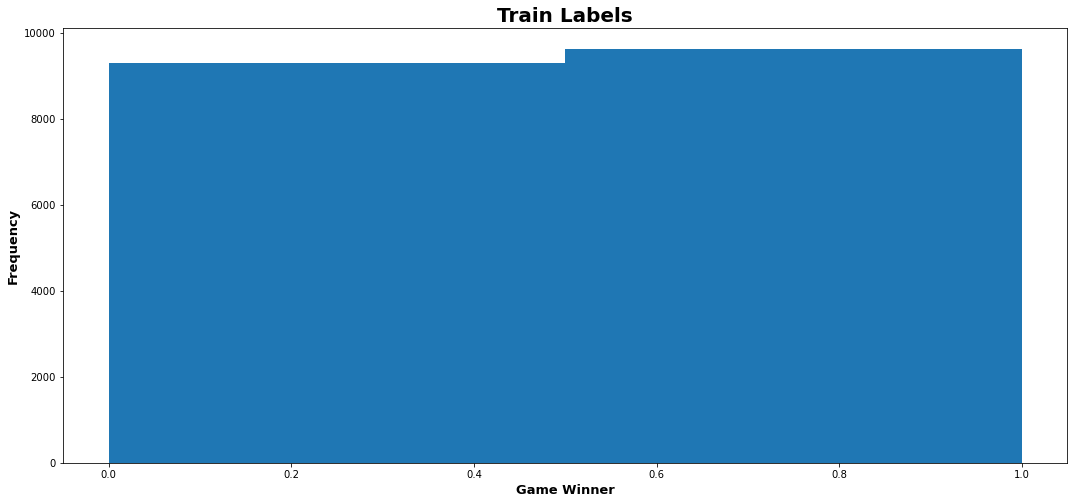

In [15]:
# plot hist of train_lables
plt.figure()
plt.hist(train_lables.reshape(-1, 1), bins=2)
plt.title('Train Labels')
plt.xlabel('Game Winner')
plt.ylabel('Frequency')
plt.show()

Our data is well balanced, with similar numbers of wins and losses for each player.

In [16]:
# scale the data using standard scaler
scaler = StandardScaler()

# reshape each array to 2d for scaling and then reshape back to original shape
train_3d_scaled = scaler.fit_transform(
    train_3d.reshape(-1, train_3d.shape[-1])
).reshape(train_3d.shape)

val_3d_scaled = scaler.transform(
    val_3d.reshape(-1, val_3d.shape[-1])
).reshape(val_3d.shape)

test_3d_scaled = scaler.transform(
    test_3d.reshape(-1, test_3d.shape[-1])
).reshape(test_3d.shape)


In [17]:
# instantiate RNN model
model = Sequential()

# add LSTM layer
model.add(GRU(
    units=128,
    input_shape=(train_3d.shape[1], train_3d.shape[2]),
    return_sequences=False
))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# add dense layer
model.add(Dense(
    1, 
    activation='sigmoid', 
    kernel_regularizer=keras.regularizers.l1(0.01)
))


In [18]:
# compile model using binary crossentropy loss and adam optimizer
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [19]:
# length=18919 # set this to the number of training images
# b_max=1024 # maximum batch size you will allow based on memory capacity
# batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
# steps=int(length/batch_size)
# print(f'batch_size: {batch_size}')
# print(f'steps: {steps}')


In [20]:
# create a callback which stops training when no improvement is being made
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss', # monitor validation loss to prevent overfitting
    patience=3, # stop after 3 epochs without improvement
    verbose=1,  # print a message when the callback is triggered
    mode='auto' # keras infers if the monitored variable should be increasing or decreasing
)



In [21]:
# batch size * steps per epoch ~number of games to get one batch of data per epoch

# fit the model and save to history
history = model.fit(
    train_3d_scaled,
    train_lables,
    epochs=100,
    batch_size=128,
    steps_per_epoch=145,
    validation_data=(val_3d_scaled, val_lables),
    callbacks=[earlystop]
)

Epoch 1/100
145/145 [==============================] - 5s 15ms/step - loss: 0.8138 - accuracy: 0.6094 - val_loss: 0.7221 - val_accuracy: 0.6441
Epoch 2/100
145/145 [==============================] - 2s 11ms/step - loss: 0.7053 - accuracy: 0.6448 - val_loss: 0.6833 - val_accuracy: 0.6471
Epoch 3/100
145/145 [==============================] - 2s 11ms/step - loss: 0.6572 - accuracy: 0.6575 - val_loss: 0.6410 - val_accuracy: 0.6647
Epoch 4/100
145/145 [==============================] - 2s 11ms/step - loss: 0.6301 - accuracy: 0.6680 - val_loss: 0.6294 - val_accuracy: 0.6586
Epoch 5/100
145/145 [==============================] - 2s 11ms/step - loss: 0.6173 - accuracy: 0.6699 - val_loss: 0.6187 - val_accuracy: 0.6692
Epoch 6/100
145/145 [==============================] - 2s 11ms/step - loss: 0.6096 - accuracy: 0.6758 - val_loss: 0.6499 - val_accuracy: 0.6361
Epoch 7/100
145/145 [==============================] - 2s 11ms/step - loss: 0.6060 - accuracy: 0.6784 - val_loss: 0.6247 - val_accuracy:

In [81]:
# # predict train data
# train_pred = model.predict(train_3d_scaled) # returns probabilities
# train_pred = np.where(train_pred > 0.5, 1, 0) # convert to binary using threshold

# # predict val data
# val_pred = model.predict(val_3d_scaled) # returns probabilities
# val_pred = np.where(val_pred > 0.5, 1, 0) # convert to binary using threshold

In [82]:
# # plot train and validation accuracy over epochs
# plt.figure()
# # multiply by 100 to get percentage
# plt.plot([v*100 for v in history.history['accuracy']])
# plt.plot([v*100 for v in history.history['val_accuracy']])
# plt.title('Model accuracy', style='italic')
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# # make x-ticks every integer
# plt.xticks(np.arange(0, len(history.history['accuracy'])))
# # make x-axis start at 0
# plt.gca().set_xlim(0, len(history.history['accuracy']))
# plt.grid(linestyle='--')
# plt.show()


Our model performs decently on its first run. Around epoch 6 we begin to see significant deviation between validation and training accuracy, this is the point at which we are beginning to overfit, which results in early stopping being triggered. To further explore the model outputs we will use the confusion matrix and precision and recall scores to evaluate the model.
* __[Precision Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)__: True positives divided by total true and false positives. This is a measure of how often the model was correct in labeling a prediction as 0. In our case this is a measure of how sure the model is that Player 2 did not win.
* __[Recall Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall%20score#sklearn.metrics.recall_score)__: True positives divided by total true and false negatives. This is a measure of how often the model was correct in labeling a prediction as 1. In our case this is a measure of how sure the model is that Player 1 did win.

In [22]:
# function to display the confusion matrix in a nice format
def display_confusion_matrix(
    y_true,
    y_pred,
    class_names
):
    """
    display_confusion_matrix
    Display a confusion matrix created by the sklearn module as a formatted pandas dataframe with styled background and class labels.

    Args:
        y_true (array): the true labels
        y_pred (array): the predicted labels
        class_names (array): the names of the classes
        figsize (tuple): the size of the figure
        fontsize (int): the font size of the labels
    Returns:
        None
    """    

    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true, y_pred)

    # create a pandas dataframe from the confusion matrix
    df_cm = pd.DataFrame(
        cm, 
        index=['true - ' + v for v in class_names], 
        columns=['predicted - ' + v for v in class_names]
    )

    display(df_cm.style.background_gradient())

In [23]:
# display_confusion_matrix(
#     val_lables.reshape(-1, 1), 
#     val_pred.reshape(-1, 1),
#     ['Player1 Win', 'Player2 Win']    
# )

# print('Precision Score: {}%'.format(
#     round(
#         precision_score(
#             val_lables.reshape(-1, 1), 
#             val_pred.reshape(-1, 1)
#         )*100, 2
#     )
# ))
# print('Recall Score: {}%'.format(
#     round(
#         recall_score(
#             val_lables.reshape(-1, 1),
#             val_pred.reshape(-1, 1)
#         )*100, 2
#     )
# ))

### 2.3 Building a Grid Search

To optimize the hyperparameters of the model, we could retry multiple times with different hyperparameters (such as number of LSTM cells, dropout rate, learning rate, etc) and then running the model on each of these hyperparameter combinations. This would take a long time, and we would have to manually reset the hyperparameters each time.

However, Scikit-Learn has a built-in `GridSearchCV` class that can be used to do this for us. This class will automatically run the model with different hyperparameters and return the best model. In order to use GridSearchCV we will be following the guide outlined __[here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)__ (**Note**: The `KerasClassifier` used in this post has since been deprecated. `scikeras.wrappers.KerasClassifier` is used here instead). 

The basic outline of the process is:
1. Define a `create_model()` function that returns a model which we can pass to `GridSearchCV`.
2. Use the `KerasClassifier` class to create a `GridSearchCV` object with the `create_model()` function.
3. Define a dictionary of hyperparameters over which we want to search.
4. Run the `GridSearchCV` object.

#### 2.3.1 Defining the model

We have now created a function that returns the model. The function allows for the optimization of:
* Number of nodes per layer.
* Number of hidden layers.
* Type of node (LSTM or GRU).
* Dropout rate.
* Learning rate.
* Optimizer (Adam, RMSprop, or Adagrad).

The function always adds a Dense layer, with a single node, and sigmoid activation, as this will this will always be the final output for the model.

Now we can use KerasClassifier to create a GridSearchCV object.

In [24]:
def _make_lstm(model, nodes, dropout):
    """
    _make_lstm
    Create a LSTM model with the given parameters.

    Args:
        nodes (list, int): the number of nodes in each hidden layer
        dropout (float): the dropout rate
    
    Returns:
        model (keras.models.Sequential): the LSTM model
    """

    for i, number_nodes in enumerate(nodes):
        if i == 0:
            model.add(LSTM(
                number_nodes,
                input_shape=(train_3d.shape[1], train_3d.shape[2]),
                return_sequences=True
            ))
        elif i == len(nodes) - 1:
            model.add(LSTM(
                number_nodes,
                return_sequences=False
            ))
        else:
            model.add(LSTM(
                number_nodes,
                return_sequences=True
            ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    return model


def _make_gru(model, nodes, dropout):
    """
    _make_gru
    Create a GRU model with the given parameters.

    Args:
        nodes (list, int): the number of nodes in each hidden layer
        dropout (float): the dropout rate
    
    Returns:
        model (keras.models.Sequential): the GRU model
    """

    for i, number_nodes in enumerate(nodes):
        if i == 0:
            model.add(GRU(
                number_nodes,
                input_shape=(train_3d.shape[1], train_3d.shape[2]),
                return_sequences=True
            ))
        elif i == len(nodes) - 1:
            model.add(GRU(
                number_nodes,
                return_sequences=False
            ))
        else:
            model.add(GRU(
                number_nodes,
                return_sequences=True
            ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    return model


def get_model(
    nodes,
    learning_rate,
    dropout_rate,
    node_type
):

    # model = Sequential()
    # model.add(LSTM(
    #     units=128,
    #     input_shape=(train_3d.shape[1], train_3d.shape[2]),
    #     return_sequences=False
    # ))
    # model.add(BatchNormalization())
    # model.add(Dropout(dropout_rate))

    if node_type == 'lstm':
        model = _make_lstm(
            model=Sequential(),
            nodes=nodes,
            dropout=dropout_rate
        )
    elif node_type == 'gru':
        model = _make_gru(
            model=Sequential(),
            nodes=nodes,
            dropout=dropout_rate
        )
    else:
        raise(ValueError('Node type not recognized'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


In [25]:
param_grid = {
    'nodes': [[128], [64, 64], [32, 32, 32]],
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'node_type': ['lstm', 'gru']
}    

rnn = KerasClassifier(
    build_fn=get_model,
    epochs=20,
    batch_size=128,
    callbacks=[earlystop],
    nodes=[128],
    dropout_rate=0.2,
    learning_rate=0.001,
    node_type='lstm'
)

grid = GridSearchCV(
    estimator=rnn,
    param_grid=param_grid,
    cv=3,
    verbose=3,
    scoring='accuracy'
)

grid.fit(
    train_3d_scaled,
    train_lables.reshape(-1, 1),
    validation_data=(
        val_3d_scaled,
        val_lables.reshape(-1, 1)
    )
)

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphse_z2ms\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphse_z2ms\assets


Fitting 3 folds for each of 72 candidates, totalling 216 fits


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8m6vqndp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8m6vqndp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 22ms/step - loss: 0.7188 - accuracy: 0.5317 - val_loss: 0.6790 - val_accuracy: 0.5570
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6879 - accuracy: 0.5506 - val_loss: 0.6729 - val_accuracy: 0.5659
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6787 - accuracy: 0.5606 - val_loss: 0.6693 - val_accuracy: 0.5741
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6730 - accuracy: 0.5657 - val_loss: 0.6678 - val_accuracy: 0.5773
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6686 - accuracy: 0.5701 - val_loss: 0.6661 - val_accuracy: 0.5784
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6640 - accuracy: 0.5748 - val_loss: 0.6657 - val_accuracy: 0.5808
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6605 - accuracy: 0.5775 - val_loss: 0.6724 - val_accuracy: 0.5662
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpklhoyfh6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpklhoyfh6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7084 - accuracy: 0.5366 - val_loss: 0.6789 - val_accuracy: 0.5527
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5558 - val_loss: 0.6740 - val_accuracy: 0.5663
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6755 - accuracy: 0.5636 - val_loss: 0.6694 - val_accuracy: 0.5697
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6692 - accuracy: 0.5703 - val_loss: 0.6727 - val_accuracy: 0.5670
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6660 - accuracy: 0.5738 - val_loss: 0.6649 - val_accuracy: 0.5752
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6620 - accuracy: 0.5775 - val_loss: 0.6661 - val_accuracy: 0.5735
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6589 - accuracy: 0.5793 - val_loss: 0.6661 - val_accuracy: 0.5759
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpannjeaiy\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpannjeaiy\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7168 - accuracy: 0.5337 - val_loss: 0.6814 - val_accuracy: 0.5546
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6858 - accuracy: 0.5554 - val_loss: 0.6716 - val_accuracy: 0.5736
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6777 - accuracy: 0.5632 - val_loss: 0.6680 - val_accuracy: 0.5745
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6717 - accuracy: 0.5675 - val_loss: 0.6649 - val_accuracy: 0.5784
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6670 - accuracy: 0.5729 - val_loss: 0.6649 - val_accuracy: 0.5815
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6619 - accuracy: 0.5787 - val_loss: 0.6638 - val_accuracy: 0.5804
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6593 - accuracy: 0.5816 - val_loss: 0.6652 - val_accuracy: 0.5792
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc58vxn78\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc58vxn78\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.7076 - accuracy: 0.5766 - val_loss: 0.6646 - val_accuracy: 0.5923
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6410 - accuracy: 0.6284 - val_loss: 0.6405 - val_accuracy: 0.6299
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6185 - accuracy: 0.6544 - val_loss: 0.6276 - val_accuracy: 0.6435
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6012 - accuracy: 0.6652 - val_loss: 0.6308 - val_accuracy: 0.6367
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5899 - accuracy: 0.6767 - val_loss: 0.6295 - val_accuracy: 0.6398
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5713 - accuracy: 0.6892 - val_loss: 0.6300 - val_accuracy: 0.6489
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpep24g5ca\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpep24g5ca\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7046 - accuracy: 0.5847 - val_loss: 0.6615 - val_accuracy: 0.6212
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6447 - accuracy: 0.6305 - val_loss: 0.6410 - val_accuracy: 0.6350
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6154 - accuracy: 0.6558 - val_loss: 0.6228 - val_accuracy: 0.6457
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6012 - accuracy: 0.6671 - val_loss: 0.6138 - val_accuracy: 0.6524
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.5862 - accuracy: 0.6775 - val_loss: 0.6394 - val_accuracy: 0.6388
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5737 - accuracy: 0.6880 - val_loss: 0.6317 - val_accuracy: 0.6415
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5631 - accuracy: 0.6944 - val_loss: 0.6270 - val_accuracy: 0.6462
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp92rvw3yd\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp92rvw3yd\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7053 - accuracy: 0.5840 - val_loss: 0.6643 - val_accuracy: 0.5915
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6437 - accuracy: 0.6260 - val_loss: 0.6361 - val_accuracy: 0.6468
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6159 - accuracy: 0.6537 - val_loss: 0.6307 - val_accuracy: 0.6330
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5990 - accuracy: 0.6705 - val_loss: 0.6301 - val_accuracy: 0.6396
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5889 - accuracy: 0.6749 - val_loss: 0.6227 - val_accuracy: 0.6473
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5742 - accuracy: 0.6854 - val_loss: 0.6291 - val_accuracy: 0.6534
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5633 - accuracy: 0.6980 - val_loss: 0.6286 - val_accuracy: 0.6492
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa18onnqz\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa18onnqz\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7286 - accuracy: 0.5538 - val_loss: 0.6750 - val_accuracy: 0.6029
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6756 - accuracy: 0.5965 - val_loss: 0.6598 - val_accuracy: 0.6018
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6465 - accuracy: 0.6307 - val_loss: 0.6381 - val_accuracy: 0.6227
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6277 - accuracy: 0.6508 - val_loss: 0.6301 - val_accuracy: 0.6397
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6175 - accuracy: 0.6572 - val_loss: 0.6279 - val_accuracy: 0.6498
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6087 - accuracy: 0.6637 - val_loss: 0.6512 - val_accuracy: 0.6176
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6007 - accuracy: 0.6671 - val_loss: 0.6325 - val_accuracy: 0.6466
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw6x09_c3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw6x09_c3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 29ms/step - loss: 0.7286 - accuracy: 0.5479 - val_loss: 0.6823 - val_accuracy: 0.5672
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6658 - accuracy: 0.6073 - val_loss: 0.6622 - val_accuracy: 0.5890
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6468 - accuracy: 0.6236 - val_loss: 0.6326 - val_accuracy: 0.6402
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6282 - accuracy: 0.6457 - val_loss: 0.6281 - val_accuracy: 0.6383
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6150 - accuracy: 0.6573 - val_loss: 0.6313 - val_accuracy: 0.6376
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6063 - accuracy: 0.6634 - val_loss: 0.6190 - val_accuracy: 0.6524
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.5932 - accuracy: 0.6728 - val_loss: 0.6182 - val_accuracy: 0.6556
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpelwrcu10\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpelwrcu10\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7460 - accuracy: 0.5398 - val_loss: 0.6813 - val_accuracy: 0.5643
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6860 - accuracy: 0.5859 - val_loss: 0.6608 - val_accuracy: 0.6074
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6540 - accuracy: 0.6170 - val_loss: 0.6384 - val_accuracy: 0.6348
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6368 - accuracy: 0.6348 - val_loss: 0.6267 - val_accuracy: 0.6445
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6204 - accuracy: 0.6506 - val_loss: 0.6216 - val_accuracy: 0.6452
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6101 - accuracy: 0.6600 - val_loss: 0.6238 - val_accuracy: 0.6483
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.5979 - accuracy: 0.6729 - val_loss: 0.6237 - val_accuracy: 0.6512
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw9hri7_u\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw9hri7_u\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7130 - accuracy: 0.5362 - val_loss: 0.6795 - val_accuracy: 0.5536
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6916 - accuracy: 0.5479 - val_loss: 0.6722 - val_accuracy: 0.5668
Epoch 3/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6832 - accuracy: 0.5559 - val_loss: 0.6696 - val_accuracy: 0.5723
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6786 - accuracy: 0.5605 - val_loss: 0.6674 - val_accuracy: 0.5760
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6740 - accuracy: 0.5641 - val_loss: 0.6660 - val_accuracy: 0.5779
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6707 - accuracy: 0.5679 - val_loss: 0.6657 - val_accuracy: 0.5763
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6689 - accuracy: 0.5695 - val_loss: 0.6640 - val_accuracy: 0.5810
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgnx01cid\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgnx01cid\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7115 - accuracy: 0.5376 - val_loss: 0.6773 - val_accuracy: 0.5612
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6890 - accuracy: 0.5511 - val_loss: 0.6698 - val_accuracy: 0.5721
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6824 - accuracy: 0.5559 - val_loss: 0.6686 - val_accuracy: 0.5700
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6774 - accuracy: 0.5610 - val_loss: 0.6679 - val_accuracy: 0.5735
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.5658 - val_loss: 0.6643 - val_accuracy: 0.5791
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6693 - accuracy: 0.5693 - val_loss: 0.6641 - val_accuracy: 0.5807
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6666 - accuracy: 0.5738 - val_loss: 0.6634 - val_accuracy: 0.5772
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_suhypq4\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_suhypq4\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7191 - accuracy: 0.5340 - val_loss: 0.6774 - val_accuracy: 0.5639
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6937 - accuracy: 0.5488 - val_loss: 0.6746 - val_accuracy: 0.5660
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6851 - accuracy: 0.5537 - val_loss: 0.6724 - val_accuracy: 0.5660
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6792 - accuracy: 0.5588 - val_loss: 0.6672 - val_accuracy: 0.5718
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6734 - accuracy: 0.5662 - val_loss: 0.6635 - val_accuracy: 0.5812
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6704 - accuracy: 0.5692 - val_loss: 0.6657 - val_accuracy: 0.5782
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6674 - accuracy: 0.5727 - val_loss: 0.6635 - val_accuracy: 0.5813
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvcs6uykc\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvcs6uykc\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.6986 - accuracy: 0.5842 - val_loss: 0.6499 - val_accuracy: 0.6187
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6406 - accuracy: 0.6330 - val_loss: 0.6318 - val_accuracy: 0.6376
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6230 - accuracy: 0.6494 - val_loss: 0.6480 - val_accuracy: 0.6163
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6083 - accuracy: 0.6633 - val_loss: 0.6251 - val_accuracy: 0.6460
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6013 - accuracy: 0.6693 - val_loss: 0.6175 - val_accuracy: 0.6551
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.5927 - accuracy: 0.6722 - val_loss: 0.6220 - val_accuracy: 0.6508
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5793 - accuracy: 0.6793 - val_loss: 0.6150 - val_accuracy: 0.6609
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxhgrfp2r\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxhgrfp2r\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.6971 - accuracy: 0.5961 - val_loss: 0.6431 - val_accuracy: 0.6291
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6418 - accuracy: 0.6332 - val_loss: 0.6286 - val_accuracy: 0.6473
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6205 - accuracy: 0.6542 - val_loss: 0.6175 - val_accuracy: 0.6486
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6067 - accuracy: 0.6623 - val_loss: 0.6070 - val_accuracy: 0.6644
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5958 - accuracy: 0.6697 - val_loss: 0.6113 - val_accuracy: 0.6518
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.5877 - accuracy: 0.6775 - val_loss: 0.6210 - val_accuracy: 0.6520
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5770 - accuracy: 0.6861 - val_loss: 0.6157 - val_accuracy: 0.6539
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3b5koy4z\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3b5koy4z\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.6933 - accuracy: 0.5929 - val_loss: 0.6461 - val_accuracy: 0.6138
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6430 - accuracy: 0.6292 - val_loss: 0.6238 - val_accuracy: 0.6444
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6239 - accuracy: 0.6471 - val_loss: 0.6234 - val_accuracy: 0.6411
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6112 - accuracy: 0.6573 - val_loss: 0.6135 - val_accuracy: 0.6587
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5954 - accuracy: 0.6691 - val_loss: 0.6109 - val_accuracy: 0.6646
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5882 - accuracy: 0.6809 - val_loss: 0.6232 - val_accuracy: 0.6546
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.5807 - accuracy: 0.6816 - val_loss: 0.6171 - val_accuracy: 0.6524
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpopxdn27q\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpopxdn27q\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 26ms/step - loss: 0.7066 - accuracy: 0.5785 - val_loss: 0.6541 - val_accuracy: 0.6253
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6538 - accuracy: 0.6231 - val_loss: 0.6318 - val_accuracy: 0.6472
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6361 - accuracy: 0.6378 - val_loss: 0.6239 - val_accuracy: 0.6417
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6235 - accuracy: 0.6533 - val_loss: 0.6189 - val_accuracy: 0.6518
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6148 - accuracy: 0.6558 - val_loss: 0.6139 - val_accuracy: 0.6524
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6066 - accuracy: 0.6629 - val_loss: 0.6113 - val_accuracy: 0.6538
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.5972 - accuracy: 0.6701 - val_loss: 0.6133 - val_accuracy: 0.6560
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpwvo_o30r\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpwvo_o30r\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.6829 - accuracy: 0.5935 - val_loss: 0.6534 - val_accuracy: 0.6124
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6436 - accuracy: 0.6301 - val_loss: 0.6265 - val_accuracy: 0.6524
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6256 - accuracy: 0.6468 - val_loss: 0.6104 - val_accuracy: 0.6561
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6177 - accuracy: 0.6557 - val_loss: 0.6106 - val_accuracy: 0.6545
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6119 - accuracy: 0.6561 - val_loss: 0.6219 - val_accuracy: 0.6445
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6009 - accuracy: 0.6661 - val_loss: 0.6192 - val_accuracy: 0.6570
Epoch 00006: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.1, learning_rate=0.001, node_type=gru, nodes=

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp86eloya9\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp86eloya9\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.6916 - accuracy: 0.5838 - val_loss: 0.6532 - val_accuracy: 0.6307
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6453 - accuracy: 0.6284 - val_loss: 0.6264 - val_accuracy: 0.6563
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6264 - accuracy: 0.6492 - val_loss: 0.6171 - val_accuracy: 0.6609
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6190 - accuracy: 0.6548 - val_loss: 0.6160 - val_accuracy: 0.6631
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6092 - accuracy: 0.6633 - val_loss: 0.6155 - val_accuracy: 0.6610
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6049 - accuracy: 0.6611 - val_loss: 0.6378 - val_accuracy: 0.6383
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.5968 - accuracy: 0.6734 - val_loss: 0.6198 - val_accuracy: 0.6578
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw5aj2jio\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw5aj2jio\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7610 - accuracy: 0.5246 - val_loss: 0.6841 - val_accuracy: 0.5332
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6800 - accuracy: 0.5516 - val_loss: 0.6768 - val_accuracy: 0.5663
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6750 - accuracy: 0.5614 - val_loss: 0.6755 - val_accuracy: 0.5665
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6714 - accuracy: 0.5651 - val_loss: 0.6767 - val_accuracy: 0.5482
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6689 - accuracy: 0.5702 - val_loss: 0.6680 - val_accuracy: 0.5729
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6686 - accuracy: 0.5700 - val_loss: 0.6770 - val_accuracy: 0.5491
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6657 - accuracy: 0.5749 - val_loss: 0.6692 - val_accuracy: 0.5697
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp6ap5nw1d\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp6ap5nw1d\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7174 - accuracy: 0.5303 - val_loss: 0.6810 - val_accuracy: 0.5566
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6774 - accuracy: 0.5565 - val_loss: 0.6760 - val_accuracy: 0.5654
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6728 - accuracy: 0.5628 - val_loss: 0.6721 - val_accuracy: 0.5696
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6710 - accuracy: 0.5672 - val_loss: 0.6794 - val_accuracy: 0.5554
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6684 - accuracy: 0.5700 - val_loss: 0.6926 - val_accuracy: 0.5441
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6671 - accuracy: 0.5714 - val_loss: 0.6650 - val_accuracy: 0.5795
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6647 - accuracy: 0.5745 - val_loss: 0.6676 - val_accuracy: 0.5755
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpryipbgcf\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpryipbgcf\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7366 - accuracy: 0.5274 - val_loss: 0.6794 - val_accuracy: 0.5570
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6783 - accuracy: 0.5546 - val_loss: 0.6764 - val_accuracy: 0.5623
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6731 - accuracy: 0.5633 - val_loss: 0.6731 - val_accuracy: 0.5680
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6702 - accuracy: 0.5692 - val_loss: 0.6699 - val_accuracy: 0.5657
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6687 - accuracy: 0.5716 - val_loss: 0.6678 - val_accuracy: 0.5768
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6665 - accuracy: 0.5745 - val_loss: 0.6682 - val_accuracy: 0.5745
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6642 - accuracy: 0.5771 - val_loss: 0.6831 - val_accuracy: 0.5531
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsgb8pvs2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsgb8pvs2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.6947 - accuracy: 0.5860 - val_loss: 0.6751 - val_accuracy: 0.5769
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6436 - accuracy: 0.6305 - val_loss: 0.6720 - val_accuracy: 0.5553
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6289 - accuracy: 0.6424 - val_loss: 0.6417 - val_accuracy: 0.6336
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6245 - accuracy: 0.6523 - val_loss: 0.6204 - val_accuracy: 0.6555
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6179 - accuracy: 0.6512 - val_loss: 0.6190 - val_accuracy: 0.6487
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6109 - accuracy: 0.6577 - val_loss: 0.6195 - val_accuracy: 0.6464
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6108 - accuracy: 0.6579 - val_loss: 0.6329 - val_accuracy: 0.6375
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppwe5y4e_\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppwe5y4e_\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.6967 - accuracy: 0.5875 - val_loss: 0.6665 - val_accuracy: 0.5996
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6325 - accuracy: 0.6354 - val_loss: 0.6518 - val_accuracy: 0.6255
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6235 - accuracy: 0.6461 - val_loss: 0.6394 - val_accuracy: 0.6411
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6175 - accuracy: 0.6512 - val_loss: 0.6302 - val_accuracy: 0.6449
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6236 - accuracy: 0.6494 - val_loss: 0.6722 - val_accuracy: 0.6144
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6150 - accuracy: 0.6574 - val_loss: 0.6281 - val_accuracy: 0.6486
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6127 - accuracy: 0.6615 - val_loss: 0.6320 - val_accuracy: 0.6139
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptzqsgb8b\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptzqsgb8b\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.6860 - accuracy: 0.5844 - val_loss: 0.6773 - val_accuracy: 0.5772
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6379 - accuracy: 0.6366 - val_loss: 0.6375 - val_accuracy: 0.6459
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6259 - accuracy: 0.6479 - val_loss: 0.6419 - val_accuracy: 0.6288
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6216 - accuracy: 0.6524 - val_loss: 0.6206 - val_accuracy: 0.6491
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6198 - accuracy: 0.6475 - val_loss: 0.6280 - val_accuracy: 0.6465
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6145 - accuracy: 0.6550 - val_loss: 0.6287 - val_accuracy: 0.6499
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6143 - accuracy: 0.6610 - val_loss: 0.6226 - val_accuracy: 0.6394
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpki2c5ro6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpki2c5ro6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 31ms/step - loss: 0.6950 - accuracy: 0.5595 - val_loss: 0.6868 - val_accuracy: 0.5196
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6483 - accuracy: 0.6212 - val_loss: 0.6614 - val_accuracy: 0.6181
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6319 - accuracy: 0.6430 - val_loss: 0.6435 - val_accuracy: 0.6356
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6252 - accuracy: 0.6486 - val_loss: 0.6273 - val_accuracy: 0.6498
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6198 - accuracy: 0.6516 - val_loss: 0.6273 - val_accuracy: 0.6541
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6158 - accuracy: 0.6568 - val_loss: 0.6225 - val_accuracy: 0.6486
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6065 - accuracy: 0.6659 - val_loss: 0.6244 - val_accuracy: 0.6383
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplehk7ix3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplehk7ix3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.6967 - accuracy: 0.5597 - val_loss: 0.6789 - val_accuracy: 0.5962
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6459 - accuracy: 0.6221 - val_loss: 0.6631 - val_accuracy: 0.6325
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6327 - accuracy: 0.6369 - val_loss: 0.6568 - val_accuracy: 0.6118
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6201 - accuracy: 0.6521 - val_loss: 0.6393 - val_accuracy: 0.6364
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6186 - accuracy: 0.6522 - val_loss: 0.6613 - val_accuracy: 0.5936
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6137 - accuracy: 0.6600 - val_loss: 0.7103 - val_accuracy: 0.6151
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6120 - accuracy: 0.6630 - val_loss: 0.6171 - val_accuracy: 0.6512
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpnpwas82w\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpnpwas82w\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 31ms/step - loss: 0.6976 - accuracy: 0.5604 - val_loss: 0.6724 - val_accuracy: 0.6053
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6517 - accuracy: 0.6183 - val_loss: 0.6605 - val_accuracy: 0.6198
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6342 - accuracy: 0.6454 - val_loss: 0.6423 - val_accuracy: 0.6475
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6307 - accuracy: 0.6514 - val_loss: 0.6311 - val_accuracy: 0.6486
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6262 - accuracy: 0.6516 - val_loss: 0.6305 - val_accuracy: 0.6486
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6223 - accuracy: 0.6513 - val_loss: 0.6270 - val_accuracy: 0.6370
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6183 - accuracy: 0.6591 - val_loss: 0.6291 - val_accuracy: 0.6502
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpww9aopj2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpww9aopj2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7581 - accuracy: 0.5332 - val_loss: 0.6781 - val_accuracy: 0.5542
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6795 - accuracy: 0.5519 - val_loss: 0.6727 - val_accuracy: 0.5648
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6734 - accuracy: 0.5636 - val_loss: 0.6842 - val_accuracy: 0.5468
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6701 - accuracy: 0.5681 - val_loss: 0.6702 - val_accuracy: 0.5689
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.5689 - val_loss: 0.6736 - val_accuracy: 0.5636
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6661 - accuracy: 0.5733 - val_loss: 0.6689 - val_accuracy: 0.5727
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6632 - accuracy: 0.5769 - val_loss: 0.6712 - val_accuracy: 0.5742
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpm8mzk3j2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpm8mzk3j2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7337 - accuracy: 0.5321 - val_loss: 0.6775 - val_accuracy: 0.5573
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6769 - accuracy: 0.5576 - val_loss: 0.6717 - val_accuracy: 0.5658
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6721 - accuracy: 0.5644 - val_loss: 0.6684 - val_accuracy: 0.5738
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6691 - accuracy: 0.5700 - val_loss: 0.6680 - val_accuracy: 0.5705
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6677 - accuracy: 0.5727 - val_loss: 0.6703 - val_accuracy: 0.5716
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6647 - accuracy: 0.5754 - val_loss: 0.6729 - val_accuracy: 0.5669
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6626 - accuracy: 0.5761 - val_loss: 0.6723 - val_accuracy: 0.5674
Epoch 00007: 

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpufbnzgu5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpufbnzgu5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7559 - accuracy: 0.5287 - val_loss: 0.6890 - val_accuracy: 0.5406
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6810 - accuracy: 0.5499 - val_loss: 0.6767 - val_accuracy: 0.5540
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6735 - accuracy: 0.5621 - val_loss: 0.6686 - val_accuracy: 0.5740
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6697 - accuracy: 0.5688 - val_loss: 0.6670 - val_accuracy: 0.5777
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6676 - accuracy: 0.5701 - val_loss: 0.6687 - val_accuracy: 0.5720
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6654 - accuracy: 0.5761 - val_loss: 0.6668 - val_accuracy: 0.5757
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6637 - accuracy: 0.5762 - val_loss: 0.6696 - val_accuracy: 0.5667
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqovhthm1\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqovhthm1\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.6831 - accuracy: 0.5985 - val_loss: 0.6441 - val_accuracy: 0.6324
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6304 - accuracy: 0.6411 - val_loss: 0.6271 - val_accuracy: 0.6423
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6267 - accuracy: 0.6413 - val_loss: 0.6399 - val_accuracy: 0.6160
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6216 - accuracy: 0.6484 - val_loss: 0.6565 - val_accuracy: 0.6110
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6144 - accuracy: 0.6593 - val_loss: 0.6210 - val_accuracy: 0.6428
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6098 - accuracy: 0.6571 - val_loss: 0.6240 - val_accuracy: 0.6552
Epoch 7/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6059 - accuracy: 0.6634 - val_loss: 0.6231 - val_accuracy: 0.6481
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp72o39frj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp72o39frj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.6755 - accuracy: 0.6041 - val_loss: 0.6442 - val_accuracy: 0.6168
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6305 - accuracy: 0.6393 - val_loss: 0.6325 - val_accuracy: 0.6483
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6237 - accuracy: 0.6473 - val_loss: 0.6153 - val_accuracy: 0.6551
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6206 - accuracy: 0.6540 - val_loss: 0.6316 - val_accuracy: 0.6366
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6120 - accuracy: 0.6576 - val_loss: 0.6370 - val_accuracy: 0.6207
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6088 - accuracy: 0.6586 - val_loss: 0.6233 - val_accuracy: 0.6385
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.1, learning_rate=0.01, node_type=gru, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpesb3h2k3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpesb3h2k3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.6734 - accuracy: 0.6056 - val_loss: 0.6420 - val_accuracy: 0.6267
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6321 - accuracy: 0.6375 - val_loss: 0.6217 - val_accuracy: 0.6462
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6202 - accuracy: 0.6496 - val_loss: 0.6231 - val_accuracy: 0.6478
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6171 - accuracy: 0.6574 - val_loss: 0.6120 - val_accuracy: 0.6584
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6134 - accuracy: 0.6598 - val_loss: 0.6360 - val_accuracy: 0.6245
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6125 - accuracy: 0.6603 - val_loss: 0.6195 - val_accuracy: 0.6593
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6074 - accuracy: 0.6684 - val_loss: 0.6253 - val_accuracy: 0.6393
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpflijt904\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpflijt904\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.6916 - accuracy: 0.5781 - val_loss: 0.6637 - val_accuracy: 0.5871
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6381 - accuracy: 0.6334 - val_loss: 0.6358 - val_accuracy: 0.6297
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6267 - accuracy: 0.6498 - val_loss: 0.6645 - val_accuracy: 0.5923
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6213 - accuracy: 0.6544 - val_loss: 0.6205 - val_accuracy: 0.6561
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6151 - accuracy: 0.6534 - val_loss: 0.6234 - val_accuracy: 0.6356
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6111 - accuracy: 0.6619 - val_loss: 0.6416 - val_accuracy: 0.6271
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6085 - accuracy: 0.6606 - val_loss: 0.6134 - val_accuracy: 0.6545
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsq7y1uph\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsq7y1uph\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.6777 - accuracy: 0.5915 - val_loss: 0.6448 - val_accuracy: 0.6371
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6329 - accuracy: 0.6405 - val_loss: 0.6386 - val_accuracy: 0.6333
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6246 - accuracy: 0.6482 - val_loss: 0.6157 - val_accuracy: 0.6587
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6192 - accuracy: 0.6523 - val_loss: 0.6232 - val_accuracy: 0.6524
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6131 - accuracy: 0.6573 - val_loss: 0.6190 - val_accuracy: 0.6456
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6072 - accuracy: 0.6627 - val_loss: 0.6312 - val_accuracy: 0.6438
Epoch 00006: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 2/3] END dropout_rate=0.1, learning_rate=0.01, node_type=gru, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp68zh7i88\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp68zh7i88\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.6782 - accuracy: 0.5928 - val_loss: 0.6395 - val_accuracy: 0.6460
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6364 - accuracy: 0.6419 - val_loss: 0.6218 - val_accuracy: 0.6584
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6238 - accuracy: 0.6513 - val_loss: 0.6332 - val_accuracy: 0.6255
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6161 - accuracy: 0.6612 - val_loss: 0.6505 - val_accuracy: 0.6129
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6110 - accuracy: 0.6601 - val_loss: 0.6121 - val_accuracy: 0.6614
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6107 - accuracy: 0.6591 - val_loss: 0.6087 - val_accuracy: 0.6607
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6011 - accuracy: 0.6675 - val_loss: 0.6216 - val_accuracy: 0.6452
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjeq0gt7y\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjeq0gt7y\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7706 - accuracy: 0.5066 - val_loss: 0.6924 - val_accuracy: 0.5198
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6915 - accuracy: 0.5219 - val_loss: 0.6878 - val_accuracy: 0.5303
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6867 - accuracy: 0.5383 - val_loss: 0.6882 - val_accuracy: 0.5319
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6851 - accuracy: 0.5416 - val_loss: 0.6793 - val_accuracy: 0.5550
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6819 - accuracy: 0.5501 - val_loss: 0.6792 - val_accuracy: 0.5494
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6814 - accuracy: 0.5472 - val_loss: 0.6785 - val_accuracy: 0.5567
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6834 - accuracy: 0.5472 - val_loss: 0.6977 - val_accuracy: 0.5332
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxbccgpmj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxbccgpmj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7619 - accuracy: 0.5148 - val_loss: 0.6927 - val_accuracy: 0.4991
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6894 - accuracy: 0.5319 - val_loss: 0.6861 - val_accuracy: 0.5452
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6838 - accuracy: 0.5455 - val_loss: 0.6818 - val_accuracy: 0.5565
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6822 - accuracy: 0.5511 - val_loss: 0.6830 - val_accuracy: 0.5502
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6822 - accuracy: 0.5501 - val_loss: 0.6748 - val_accuracy: 0.5607
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6810 - accuracy: 0.5547 - val_loss: 0.6865 - val_accuracy: 0.5470
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6817 - accuracy: 0.5517 - val_loss: 0.6874 - val_accuracy: 0.5412
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptr476yyw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptr476yyw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7629 - accuracy: 0.5125 - val_loss: 0.6926 - val_accuracy: 0.5172
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6906 - accuracy: 0.5305 - val_loss: 0.6856 - val_accuracy: 0.5376
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6850 - accuracy: 0.5402 - val_loss: 0.6819 - val_accuracy: 0.5466
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6832 - accuracy: 0.5473 - val_loss: 0.6779 - val_accuracy: 0.5583
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6808 - accuracy: 0.5511 - val_loss: 0.6779 - val_accuracy: 0.5526
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6827 - accuracy: 0.5498 - val_loss: 0.6789 - val_accuracy: 0.5584
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6824 - accuracy: 0.5496 - val_loss: 0.6847 - val_accuracy: 0.5465
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt3aykwkm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt3aykwkm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.7193 - accuracy: 0.5222 - val_loss: 0.7026 - val_accuracy: 0.5087
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6963 - accuracy: 0.5172 - val_loss: 0.6968 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.7002 - accuracy: 0.5101 - val_loss: 0.7062 - val_accuracy: 0.5089
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6964 - accuracy: 0.5201 - val_loss: 0.7077 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6967 - accuracy: 0.5102 - val_loss: 0.7658 - val_accuracy: 0.5088
Epoch 00005: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.1, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.509 total time=  14.1s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4nvn9qb5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4nvn9qb5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.7160 - accuracy: 0.5138 - val_loss: 0.7063 - val_accuracy: 0.5091
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6959 - accuracy: 0.5218 - val_loss: 0.6940 - val_accuracy: 0.4924
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.7006 - accuracy: 0.4998 - val_loss: 0.6936 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6979 - accuracy: 0.5077 - val_loss: 0.6927 - val_accuracy: 0.5162
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6995 - accuracy: 0.5019 - val_loss: 0.6930 - val_accuracy: 0.5089
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6967 - accuracy: 0.5041 - val_loss: 0.6930 - val_accuracy: 0.5089
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6974 - accuracy: 0.5015 - val_loss: 0.7172 - val_accuracy: 0.5091
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplukltpql\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplukltpql\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7167 - accuracy: 0.5253 - val_loss: 0.6907 - val_accuracy: 0.5360
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6948 - accuracy: 0.5138 - val_loss: 0.6911 - val_accuracy: 0.5482
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6964 - accuracy: 0.5027 - val_loss: 0.6927 - val_accuracy: 0.5089
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6964 - accuracy: 0.5065 - val_loss: 0.6986 - val_accuracy: 0.4874
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.1, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.487 total time=  12.4s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp29hk4zgh\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp29hk4zgh\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7128 - accuracy: 0.4975 - val_loss: 0.6947 - val_accuracy: 0.5087
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6938 - accuracy: 0.5167 - val_loss: 0.7051 - val_accuracy: 0.4902
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6960 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6963 - accuracy: 0.4973 - val_loss: 0.6947 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6954 - accuracy: 0.5029 - val_loss: 1.1736 - val_accuracy: 0.4914
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6961 - accuracy: 0.4975 - val_loss: 0.7164 - val_accuracy: 0.5087
Epoch 00006: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 1/3] END dropout_rate=0.1, learning_rate=0.1, node_type=lstm, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxwoe9d_4\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxwoe9d_4\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 31ms/step - loss: 0.7110 - accuracy: 0.5074 - val_loss: 0.6926 - val_accuracy: 0.5136
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6955 - accuracy: 0.5038 - val_loss: 0.6978 - val_accuracy: 0.5096
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6956 - accuracy: 0.5025 - val_loss: 0.6988 - val_accuracy: 0.5138
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6963 - accuracy: 0.5023 - val_loss: 0.6968 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 2/3] END dropout_rate=0.1, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.509 total time=  15.2s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpusq_pm5x\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpusq_pm5x\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7127 - accuracy: 0.5068 - val_loss: 0.6941 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6956 - accuracy: 0.5099 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6955 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6939 - accuracy: 0.5066 - val_loss: 0.6937 - val_accuracy: 0.4912
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6945 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4912
Epoch 00005: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 3/3] END dropout_rate=0.1, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.490 total time=  17.3s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprofwe15y\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprofwe15y\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7734 - accuracy: 0.5131 - val_loss: 0.7088 - val_accuracy: 0.5190
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6942 - accuracy: 0.5163 - val_loss: 0.6885 - val_accuracy: 0.5277
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6912 - accuracy: 0.5261 - val_loss: 0.6880 - val_accuracy: 0.5348
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6863 - accuracy: 0.5378 - val_loss: 0.6850 - val_accuracy: 0.5369
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6848 - accuracy: 0.5423 - val_loss: 0.6781 - val_accuracy: 0.5581
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6856 - accuracy: 0.5461 - val_loss: 0.6823 - val_accuracy: 0.5528
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6848 - accuracy: 0.5474 - val_loss: 0.6792 - val_accuracy: 0.5660
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp1mllphah\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp1mllphah\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7873 - accuracy: 0.5113 - val_loss: 0.6873 - val_accuracy: 0.5324
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6892 - accuracy: 0.5300 - val_loss: 0.6826 - val_accuracy: 0.5533
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6867 - accuracy: 0.5445 - val_loss: 0.6818 - val_accuracy: 0.5607
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6877 - accuracy: 0.5421 - val_loss: 0.6879 - val_accuracy: 0.5349
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6838 - accuracy: 0.5498 - val_loss: 0.6803 - val_accuracy: 0.5433
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6822 - accuracy: 0.5524 - val_loss: 0.6789 - val_accuracy: 0.5459
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6828 - accuracy: 0.5471 - val_loss: 0.6804 - val_accuracy: 0.5550
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpe2yw5xlh\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpe2yw5xlh\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7775 - accuracy: 0.5137 - val_loss: 0.6891 - val_accuracy: 0.5303
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6876 - accuracy: 0.5392 - val_loss: 0.6843 - val_accuracy: 0.5545
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6841 - accuracy: 0.5472 - val_loss: 0.6811 - val_accuracy: 0.5539
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6826 - accuracy: 0.5462 - val_loss: 0.6778 - val_accuracy: 0.5542
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6825 - accuracy: 0.5490 - val_loss: 0.6796 - val_accuracy: 0.5538
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6831 - accuracy: 0.5498 - val_loss: 0.6767 - val_accuracy: 0.5611
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6860 - accuracy: 0.5453 - val_loss: 0.6784 - val_accuracy: 0.5542
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd803t3cr\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd803t3cr\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7409 - accuracy: 0.5216 - val_loss: 0.7006 - val_accuracy: 0.5155
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6898 - accuracy: 0.5416 - val_loss: 0.6832 - val_accuracy: 0.5516
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.5400 - val_loss: 0.6963 - val_accuracy: 0.5382
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6914 - accuracy: 0.5320 - val_loss: 0.6925 - val_accuracy: 0.5196
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6980 - accuracy: 0.5128 - val_loss: 0.6886 - val_accuracy: 0.5371
Epoch 00005: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.1, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.533 total time=  12.6s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpv2b605f5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpv2b605f5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7270 - accuracy: 0.5090 - val_loss: 0.6990 - val_accuracy: 0.5092
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.5310 - val_loss: 0.7038 - val_accuracy: 0.4920
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6972 - accuracy: 0.5145 - val_loss: 0.6980 - val_accuracy: 0.5258
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6983 - accuracy: 0.5076 - val_loss: 0.6937 - val_accuracy: 0.4944
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6954 - accuracy: 0.5073 - val_loss: 0.6927 - val_accuracy: 0.5268
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6943 - accuracy: 0.5102 - val_loss: 0.6995 - val_accuracy: 0.5138
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7024 - accuracy: 0.5047 - val_loss: 0.6939 - val_accuracy: 0.5101
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprh3otta6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprh3otta6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7248 - accuracy: 0.5147 - val_loss: 0.6900 - val_accuracy: 0.5567
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6950 - accuracy: 0.5256 - val_loss: 0.6905 - val_accuracy: 0.5236
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6965 - accuracy: 0.5207 - val_loss: 0.6960 - val_accuracy: 0.5335
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7033 - accuracy: 0.5160 - val_loss: 0.6988 - val_accuracy: 0.5253
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 3/3] END dropout_rate=0.1, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.519 total time=  11.4s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdfdv14c6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdfdv14c6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7143 - accuracy: 0.5029 - val_loss: 0.6936 - val_accuracy: 0.5050
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6971 - accuracy: 0.4984 - val_loss: 0.7027 - val_accuracy: 0.4922
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6960 - accuracy: 0.5027 - val_loss: 0.7108 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6981 - accuracy: 0.4980 - val_loss: 0.6943 - val_accuracy: 0.4916
Epoch 00004: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 1/3] END dropout_rate=0.1, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.492 total time=  14.6s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuat8crgs\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuat8crgs\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7124 - accuracy: 0.5070 - val_loss: 0.7027 - val_accuracy: 0.4955
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6948 - accuracy: 0.5099 - val_loss: 0.6925 - val_accuracy: 0.5135
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6970 - accuracy: 0.5054 - val_loss: 0.6974 - val_accuracy: 0.4881
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6992 - accuracy: 0.5019 - val_loss: 0.7000 - val_accuracy: 0.4912
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6968 - accuracy: 0.5042 - val_loss: 0.6946 - val_accuracy: 0.5088
Epoch 00005: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 2/3] END dropout_rate=0.1, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.509 total time=  17.1s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpf9a4hiej\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpf9a4hiej\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7145 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5084
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6963 - accuracy: 0.5074 - val_loss: 0.6951 - val_accuracy: 0.4916
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6951 - accuracy: 0.5058 - val_loss: 0.6950 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6949 - accuracy: 0.4966 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6947 - accuracy: 0.4964 - val_loss: 0.6941 - val_accuracy: 0.4964
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6959 - accuracy: 0.5032 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6955 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4912
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmj5p_4e3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmj5p_4e3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7364 - accuracy: 0.5299 - val_loss: 0.6787 - val_accuracy: 0.5608
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6992 - accuracy: 0.5456 - val_loss: 0.6742 - val_accuracy: 0.5649
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6837 - accuracy: 0.5565 - val_loss: 0.6707 - val_accuracy: 0.5693
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6749 - accuracy: 0.5630 - val_loss: 0.6668 - val_accuracy: 0.5733
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6691 - accuracy: 0.5689 - val_loss: 0.6684 - val_accuracy: 0.5696
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6653 - accuracy: 0.5728 - val_loss: 0.6657 - val_accuracy: 0.5762
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6610 - accuracy: 0.5771 - val_loss: 0.6648 - val_accuracy: 0.5778
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt1fdi_e7\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt1fdi_e7\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7303 - accuracy: 0.5338 - val_loss: 0.6809 - val_accuracy: 0.5437
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6930 - accuracy: 0.5515 - val_loss: 0.6728 - val_accuracy: 0.5724
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6796 - accuracy: 0.5597 - val_loss: 0.6706 - val_accuracy: 0.5660
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6710 - accuracy: 0.5679 - val_loss: 0.6652 - val_accuracy: 0.5727
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6653 - accuracy: 0.5736 - val_loss: 0.6670 - val_accuracy: 0.5685
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6614 - accuracy: 0.5784 - val_loss: 0.6628 - val_accuracy: 0.5838
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6590 - accuracy: 0.5813 - val_loss: 0.6644 - val_accuracy: 0.5790
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8_9whuqe\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8_9whuqe\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7331 - accuracy: 0.5320 - val_loss: 0.6810 - val_accuracy: 0.5418
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6973 - accuracy: 0.5488 - val_loss: 0.6749 - val_accuracy: 0.5606
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6824 - accuracy: 0.5573 - val_loss: 0.6684 - val_accuracy: 0.5754
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.5652 - val_loss: 0.6674 - val_accuracy: 0.5722
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6676 - accuracy: 0.5708 - val_loss: 0.6640 - val_accuracy: 0.5796
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6623 - accuracy: 0.5770 - val_loss: 0.6637 - val_accuracy: 0.5792
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6589 - accuracy: 0.5798 - val_loss: 0.6734 - val_accuracy: 0.5696
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4e3vjtdr\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4e3vjtdr\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7530 - accuracy: 0.5721 - val_loss: 0.6611 - val_accuracy: 0.5969
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6777 - accuracy: 0.6082 - val_loss: 0.6421 - val_accuracy: 0.6391
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6404 - accuracy: 0.6415 - val_loss: 0.6217 - val_accuracy: 0.6462
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6232 - accuracy: 0.6488 - val_loss: 0.6241 - val_accuracy: 0.6476
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6074 - accuracy: 0.6624 - val_loss: 0.6447 - val_accuracy: 0.6327
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.5996 - accuracy: 0.6678 - val_loss: 0.6207 - val_accuracy: 0.6520
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.5850 - accuracy: 0.6787 - val_loss: 0.6221 - val_accuracy: 0.6546
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphx_ezdea\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphx_ezdea\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 25ms/step - loss: 0.7257 - accuracy: 0.5773 - val_loss: 0.6588 - val_accuracy: 0.6292
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6623 - accuracy: 0.6213 - val_loss: 0.6381 - val_accuracy: 0.6380
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6357 - accuracy: 0.6429 - val_loss: 0.6263 - val_accuracy: 0.6462
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6215 - accuracy: 0.6513 - val_loss: 0.6274 - val_accuracy: 0.6366
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6020 - accuracy: 0.6678 - val_loss: 0.6148 - val_accuracy: 0.6538
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.5908 - accuracy: 0.6815 - val_loss: 0.6185 - val_accuracy: 0.6451
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.5834 - accuracy: 0.6811 - val_loss: 0.6219 - val_accuracy: 0.6462
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgfffhp4b\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgfffhp4b\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.7404 - accuracy: 0.5697 - val_loss: 0.6621 - val_accuracy: 0.6201
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6776 - accuracy: 0.6083 - val_loss: 0.6525 - val_accuracy: 0.6060
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6400 - accuracy: 0.6377 - val_loss: 0.6248 - val_accuracy: 0.6414
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6220 - accuracy: 0.6471 - val_loss: 0.6186 - val_accuracy: 0.6531
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6089 - accuracy: 0.6670 - val_loss: 0.6178 - val_accuracy: 0.6518
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6008 - accuracy: 0.6728 - val_loss: 0.6162 - val_accuracy: 0.6483
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5901 - accuracy: 0.6741 - val_loss: 0.6143 - val_accuracy: 0.6573
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpu1i5b2jd\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpu1i5b2jd\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7317 - accuracy: 0.5468 - val_loss: 0.6745 - val_accuracy: 0.5962
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6790 - accuracy: 0.5916 - val_loss: 0.6533 - val_accuracy: 0.6276
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6515 - accuracy: 0.6258 - val_loss: 0.6385 - val_accuracy: 0.6235
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6355 - accuracy: 0.6432 - val_loss: 0.6332 - val_accuracy: 0.6296
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6249 - accuracy: 0.6498 - val_loss: 0.6216 - val_accuracy: 0.6457
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6140 - accuracy: 0.6532 - val_loss: 0.6224 - val_accuracy: 0.6461
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6119 - accuracy: 0.6579 - val_loss: 0.6176 - val_accuracy: 0.6501
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk9vda2sf\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk9vda2sf\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.7650 - accuracy: 0.5364 - val_loss: 0.6767 - val_accuracy: 0.5985
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6925 - accuracy: 0.5887 - val_loss: 0.6486 - val_accuracy: 0.6251
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6646 - accuracy: 0.6137 - val_loss: 0.6315 - val_accuracy: 0.6418
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6421 - accuracy: 0.6327 - val_loss: 0.6283 - val_accuracy: 0.6327
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6260 - accuracy: 0.6458 - val_loss: 0.6315 - val_accuracy: 0.6327
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6165 - accuracy: 0.6620 - val_loss: 0.6225 - val_accuracy: 0.6468
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6057 - accuracy: 0.6650 - val_loss: 0.6165 - val_accuracy: 0.6562
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa_rb_lkv\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa_rb_lkv\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 34ms/step - loss: 0.7845 - accuracy: 0.5480 - val_loss: 0.6737 - val_accuracy: 0.6008
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.7010 - accuracy: 0.5865 - val_loss: 0.6512 - val_accuracy: 0.6163
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6681 - accuracy: 0.6158 - val_loss: 0.6348 - val_accuracy: 0.6392
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6448 - accuracy: 0.6324 - val_loss: 0.6258 - val_accuracy: 0.6454
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6330 - accuracy: 0.6377 - val_loss: 0.6263 - val_accuracy: 0.6491
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6188 - accuracy: 0.6582 - val_loss: 0.6148 - val_accuracy: 0.6593
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6121 - accuracy: 0.6661 - val_loss: 0.6189 - val_accuracy: 0.6538
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplz5uo_as\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplz5uo_as\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7405 - accuracy: 0.5300 - val_loss: 0.6800 - val_accuracy: 0.5503
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7049 - accuracy: 0.5423 - val_loss: 0.6767 - val_accuracy: 0.5551
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6907 - accuracy: 0.5503 - val_loss: 0.6698 - val_accuracy: 0.5711
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6808 - accuracy: 0.5571 - val_loss: 0.6692 - val_accuracy: 0.5746
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6747 - accuracy: 0.5626 - val_loss: 0.6680 - val_accuracy: 0.5748
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6713 - accuracy: 0.5658 - val_loss: 0.6662 - val_accuracy: 0.5751
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6675 - accuracy: 0.5713 - val_loss: 0.6637 - val_accuracy: 0.5812
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3tih4bd2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3tih4bd2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7367 - accuracy: 0.5321 - val_loss: 0.6774 - val_accuracy: 0.5588
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.7001 - accuracy: 0.5460 - val_loss: 0.6704 - val_accuracy: 0.5727
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6875 - accuracy: 0.5522 - val_loss: 0.6684 - val_accuracy: 0.5751
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6782 - accuracy: 0.5598 - val_loss: 0.6655 - val_accuracy: 0.5807
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.5643 - val_loss: 0.6641 - val_accuracy: 0.5816
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6689 - accuracy: 0.5700 - val_loss: 0.6654 - val_accuracy: 0.5790
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6674 - accuracy: 0.5723 - val_loss: 0.6646 - val_accuracy: 0.5798
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4u9kwbz1\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp4u9kwbz1\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7382 - accuracy: 0.5289 - val_loss: 0.6762 - val_accuracy: 0.5613
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7032 - accuracy: 0.5433 - val_loss: 0.6734 - val_accuracy: 0.5654
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6882 - accuracy: 0.5522 - val_loss: 0.6688 - val_accuracy: 0.5732
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6804 - accuracy: 0.5570 - val_loss: 0.6655 - val_accuracy: 0.5778
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6737 - accuracy: 0.5641 - val_loss: 0.6659 - val_accuracy: 0.5757
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6695 - accuracy: 0.5695 - val_loss: 0.6649 - val_accuracy: 0.5783
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6660 - accuracy: 0.5731 - val_loss: 0.6625 - val_accuracy: 0.5838
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp51gtf1vm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp51gtf1vm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 25ms/step - loss: 0.7078 - accuracy: 0.5858 - val_loss: 0.6473 - val_accuracy: 0.6131
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6500 - accuracy: 0.6254 - val_loss: 0.6206 - val_accuracy: 0.6478
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6345 - accuracy: 0.6333 - val_loss: 0.6226 - val_accuracy: 0.6417
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6180 - accuracy: 0.6546 - val_loss: 0.6148 - val_accuracy: 0.6572
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6082 - accuracy: 0.6617 - val_loss: 0.6097 - val_accuracy: 0.6625
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5996 - accuracy: 0.6648 - val_loss: 0.6129 - val_accuracy: 0.6524
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5933 - accuracy: 0.6738 - val_loss: 0.6201 - val_accuracy: 0.6524
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpllkbgu0b\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpllkbgu0b\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7110 - accuracy: 0.5913 - val_loss: 0.6535 - val_accuracy: 0.5986
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6645 - accuracy: 0.6169 - val_loss: 0.6405 - val_accuracy: 0.6126
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6390 - accuracy: 0.6351 - val_loss: 0.6196 - val_accuracy: 0.6468
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6226 - accuracy: 0.6501 - val_loss: 0.6092 - val_accuracy: 0.6631
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6106 - accuracy: 0.6596 - val_loss: 0.6043 - val_accuracy: 0.6626
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6034 - accuracy: 0.6691 - val_loss: 0.6083 - val_accuracy: 0.6614
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.5977 - accuracy: 0.6685 - val_loss: 0.6068 - val_accuracy: 0.6614
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpyiusmfvj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpyiusmfvj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.7273 - accuracy: 0.5761 - val_loss: 0.6356 - val_accuracy: 0.6259
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6698 - accuracy: 0.6183 - val_loss: 0.6319 - val_accuracy: 0.6286
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6424 - accuracy: 0.6378 - val_loss: 0.6177 - val_accuracy: 0.6518
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6235 - accuracy: 0.6495 - val_loss: 0.6213 - val_accuracy: 0.6428
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6140 - accuracy: 0.6584 - val_loss: 0.6095 - val_accuracy: 0.6645
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6030 - accuracy: 0.6665 - val_loss: 0.6093 - val_accuracy: 0.6615
Epoch 7/20
99/99 [==============================] - 2s 15ms/step - loss: 0.5986 - accuracy: 0.6703 - val_loss: 0.6124 - val_accuracy: 0.6588
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk6ttqn2j\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk6ttqn2j\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 28ms/step - loss: 0.7415 - accuracy: 0.5526 - val_loss: 0.6590 - val_accuracy: 0.5990
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6784 - accuracy: 0.5997 - val_loss: 0.6295 - val_accuracy: 0.6325
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6535 - accuracy: 0.6254 - val_loss: 0.6152 - val_accuracy: 0.6518
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6330 - accuracy: 0.6391 - val_loss: 0.6136 - val_accuracy: 0.6583
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6257 - accuracy: 0.6470 - val_loss: 0.6118 - val_accuracy: 0.6577
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6160 - accuracy: 0.6586 - val_loss: 0.6126 - val_accuracy: 0.6620
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6112 - accuracy: 0.6604 - val_loss: 0.6100 - val_accuracy: 0.6646
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp5w3zo6i1\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp5w3zo6i1\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 29ms/step - loss: 0.7322 - accuracy: 0.5667 - val_loss: 0.6562 - val_accuracy: 0.5923
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6689 - accuracy: 0.6106 - val_loss: 0.6387 - val_accuracy: 0.6198
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6502 - accuracy: 0.6291 - val_loss: 0.6201 - val_accuracy: 0.6472
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6331 - accuracy: 0.6448 - val_loss: 0.6097 - val_accuracy: 0.6582
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6197 - accuracy: 0.6523 - val_loss: 0.6251 - val_accuracy: 0.6433
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6181 - accuracy: 0.6547 - val_loss: 0.6144 - val_accuracy: 0.6567
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6098 - accuracy: 0.6615 - val_loss: 0.6072 - val_accuracy: 0.6545
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpci9uivci\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpci9uivci\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7354 - accuracy: 0.5615 - val_loss: 0.6546 - val_accuracy: 0.6150
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6792 - accuracy: 0.6042 - val_loss: 0.6642 - val_accuracy: 0.5928
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6527 - accuracy: 0.6282 - val_loss: 0.6173 - val_accuracy: 0.6489
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6393 - accuracy: 0.6343 - val_loss: 0.6125 - val_accuracy: 0.6583
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6262 - accuracy: 0.6471 - val_loss: 0.6128 - val_accuracy: 0.6573
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6173 - accuracy: 0.6573 - val_loss: 0.6126 - val_accuracy: 0.6612
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6103 - accuracy: 0.6614 - val_loss: 0.6127 - val_accuracy: 0.6618
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz3cnb5tp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz3cnb5tp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 23ms/step - loss: 0.7594 - accuracy: 0.5241 - val_loss: 0.6835 - val_accuracy: 0.5548
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6782 - accuracy: 0.5554 - val_loss: 0.6764 - val_accuracy: 0.5682
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6741 - accuracy: 0.5630 - val_loss: 0.6733 - val_accuracy: 0.5676
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6714 - accuracy: 0.5667 - val_loss: 0.6724 - val_accuracy: 0.5679
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6704 - accuracy: 0.5679 - val_loss: 0.6680 - val_accuracy: 0.5736
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6686 - accuracy: 0.5710 - val_loss: 0.6671 - val_accuracy: 0.5729
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6671 - accuracy: 0.5729 - val_loss: 0.6740 - val_accuracy: 0.5667
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3rcg_f4u\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3rcg_f4u\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7328 - accuracy: 0.5263 - val_loss: 0.6827 - val_accuracy: 0.5505
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6784 - accuracy: 0.5544 - val_loss: 0.6769 - val_accuracy: 0.5630
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6737 - accuracy: 0.5635 - val_loss: 0.6737 - val_accuracy: 0.5692
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6711 - accuracy: 0.5675 - val_loss: 0.6682 - val_accuracy: 0.5741
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6701 - accuracy: 0.5687 - val_loss: 0.6701 - val_accuracy: 0.5658
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6668 - accuracy: 0.5749 - val_loss: 0.6706 - val_accuracy: 0.5726
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6661 - accuracy: 0.5734 - val_loss: 0.6668 - val_accuracy: 0.5707
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp01pb8zeh\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp01pb8zeh\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7842 - accuracy: 0.5194 - val_loss: 0.6848 - val_accuracy: 0.5388
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6809 - accuracy: 0.5484 - val_loss: 0.6774 - val_accuracy: 0.5629
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6741 - accuracy: 0.5636 - val_loss: 0.6715 - val_accuracy: 0.5706
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6719 - accuracy: 0.5654 - val_loss: 0.6696 - val_accuracy: 0.5752
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6702 - accuracy: 0.5686 - val_loss: 0.6686 - val_accuracy: 0.5757
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6679 - accuracy: 0.5734 - val_loss: 0.6676 - val_accuracy: 0.5737
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6680 - accuracy: 0.5723 - val_loss: 0.6711 - val_accuracy: 0.5673
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpo8h_2rl5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpo8h_2rl5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 28ms/step - loss: 0.6843 - accuracy: 0.5803 - val_loss: 0.6921 - val_accuracy: 0.5138
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6355 - accuracy: 0.6365 - val_loss: 0.6694 - val_accuracy: 0.5749
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6316 - accuracy: 0.6377 - val_loss: 0.6370 - val_accuracy: 0.6466
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6269 - accuracy: 0.6526 - val_loss: 0.6261 - val_accuracy: 0.6403
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6221 - accuracy: 0.6495 - val_loss: 0.6537 - val_accuracy: 0.6124
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6181 - accuracy: 0.6492 - val_loss: 0.6112 - val_accuracy: 0.6613
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6159 - accuracy: 0.6597 - val_loss: 0.6231 - val_accuracy: 0.6517
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt5o01gyw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt5o01gyw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.6923 - accuracy: 0.5827 - val_loss: 0.6815 - val_accuracy: 0.5488
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6399 - accuracy: 0.6309 - val_loss: 0.6419 - val_accuracy: 0.6483
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6301 - accuracy: 0.6457 - val_loss: 0.6215 - val_accuracy: 0.6526
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6259 - accuracy: 0.6466 - val_loss: 0.6310 - val_accuracy: 0.6277
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6208 - accuracy: 0.6495 - val_loss: 0.6215 - val_accuracy: 0.6507
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6187 - accuracy: 0.6552 - val_loss: 0.6248 - val_accuracy: 0.6369
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6130 - accuracy: 0.6622 - val_loss: 0.6415 - val_accuracy: 0.6318
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpnbhlqws1\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpnbhlqws1\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.6887 - accuracy: 0.5950 - val_loss: 0.6674 - val_accuracy: 0.6227
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6389 - accuracy: 0.6355 - val_loss: 0.6584 - val_accuracy: 0.6135
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6305 - accuracy: 0.6504 - val_loss: 0.6293 - val_accuracy: 0.6480
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6229 - accuracy: 0.6516 - val_loss: 0.7248 - val_accuracy: 0.5693
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6217 - accuracy: 0.6527 - val_loss: 0.6174 - val_accuracy: 0.6505
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6147 - accuracy: 0.6550 - val_loss: 0.6240 - val_accuracy: 0.6473
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6183 - accuracy: 0.6547 - val_loss: 0.6239 - val_accuracy: 0.6460
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjssa_r6k\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjssa_r6k\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 31ms/step - loss: 0.7068 - accuracy: 0.5692 - val_loss: 0.6742 - val_accuracy: 0.6184
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6437 - accuracy: 0.6286 - val_loss: 0.6435 - val_accuracy: 0.6333
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6281 - accuracy: 0.6531 - val_loss: 0.6346 - val_accuracy: 0.6460
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6194 - accuracy: 0.6567 - val_loss: 0.6262 - val_accuracy: 0.6411
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6199 - accuracy: 0.6572 - val_loss: 0.6467 - val_accuracy: 0.5994
Epoch 6/20
99/99 [==============================] - 2s 22ms/step - loss: 0.6169 - accuracy: 0.6565 - val_loss: 0.6262 - val_accuracy: 0.6422
Epoch 7/20
99/99 [==============================] - 2s 22ms/step - loss: 0.6164 - accuracy: 0.6621 - val_loss: 0.6130 - val_accuracy: 0.6592
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdmly2dm8\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdmly2dm8\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 31ms/step - loss: 0.7137 - accuracy: 0.5534 - val_loss: 0.6710 - val_accuracy: 0.6024
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6471 - accuracy: 0.6252 - val_loss: 0.6445 - val_accuracy: 0.6385
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6311 - accuracy: 0.6408 - val_loss: 0.6335 - val_accuracy: 0.6444
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6245 - accuracy: 0.6497 - val_loss: 0.6281 - val_accuracy: 0.6481
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6194 - accuracy: 0.6535 - val_loss: 0.6224 - val_accuracy: 0.6523
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6198 - accuracy: 0.6501 - val_loss: 0.6165 - val_accuracy: 0.6637
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6124 - accuracy: 0.6574 - val_loss: 0.6155 - val_accuracy: 0.6566
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp75yp8n6w\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp75yp8n6w\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 31ms/step - loss: 0.7018 - accuracy: 0.5652 - val_loss: 0.6909 - val_accuracy: 0.5318
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6477 - accuracy: 0.6267 - val_loss: 0.6655 - val_accuracy: 0.5677
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6317 - accuracy: 0.6494 - val_loss: 0.6290 - val_accuracy: 0.6545
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6265 - accuracy: 0.6527 - val_loss: 0.6287 - val_accuracy: 0.6522
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6264 - accuracy: 0.6497 - val_loss: 0.6419 - val_accuracy: 0.6260
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6194 - accuracy: 0.6544 - val_loss: 0.6945 - val_accuracy: 0.5896
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6160 - accuracy: 0.6578 - val_loss: 0.6266 - val_accuracy: 0.6411
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn3b777fa\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn3b777fa\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7500 - accuracy: 0.5255 - val_loss: 0.6813 - val_accuracy: 0.5481
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6792 - accuracy: 0.5518 - val_loss: 0.6734 - val_accuracy: 0.5681
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6742 - accuracy: 0.5620 - val_loss: 0.6737 - val_accuracy: 0.5638
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6725 - accuracy: 0.5637 - val_loss: 0.6692 - val_accuracy: 0.5643
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6707 - accuracy: 0.5664 - val_loss: 0.6691 - val_accuracy: 0.5713
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6684 - accuracy: 0.5703 - val_loss: 0.6681 - val_accuracy: 0.5746
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.5708 - val_loss: 0.6679 - val_accuracy: 0.5764
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpudy336jz\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpudy336jz\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7306 - accuracy: 0.5326 - val_loss: 0.6755 - val_accuracy: 0.5674
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.5595 - val_loss: 0.6722 - val_accuracy: 0.5638
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6723 - accuracy: 0.5655 - val_loss: 0.6746 - val_accuracy: 0.5580
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6692 - accuracy: 0.5704 - val_loss: 0.6675 - val_accuracy: 0.5748
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6681 - accuracy: 0.5711 - val_loss: 0.6682 - val_accuracy: 0.5742
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6663 - accuracy: 0.5751 - val_loss: 0.6660 - val_accuracy: 0.5755
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6641 - accuracy: 0.5773 - val_loss: 0.6696 - val_accuracy: 0.5711
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_fdq7bb2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_fdq7bb2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7479 - accuracy: 0.5283 - val_loss: 0.6783 - val_accuracy: 0.5615
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6778 - accuracy: 0.5566 - val_loss: 0.6764 - val_accuracy: 0.5541
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6733 - accuracy: 0.5652 - val_loss: 0.6697 - val_accuracy: 0.5723
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6715 - accuracy: 0.5668 - val_loss: 0.6653 - val_accuracy: 0.5818
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6694 - accuracy: 0.5695 - val_loss: 0.6680 - val_accuracy: 0.5748
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6666 - accuracy: 0.5749 - val_loss: 0.6672 - val_accuracy: 0.5719
Epoch 7/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6650 - accuracy: 0.5759 - val_loss: 0.6729 - val_accuracy: 0.5586
Epoch 00007: 

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxldzh9oo\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxldzh9oo\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 24ms/step - loss: 0.6831 - accuracy: 0.6009 - val_loss: 0.6469 - val_accuracy: 0.6369
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6327 - accuracy: 0.6398 - val_loss: 0.6297 - val_accuracy: 0.6461
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6270 - accuracy: 0.6449 - val_loss: 0.6326 - val_accuracy: 0.6323
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6225 - accuracy: 0.6537 - val_loss: 0.6248 - val_accuracy: 0.6575
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6193 - accuracy: 0.6445 - val_loss: 0.7518 - val_accuracy: 0.6170
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6231 - accuracy: 0.6461 - val_loss: 0.6334 - val_accuracy: 0.6378
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6171 - accuracy: 0.6528 - val_loss: 0.6838 - val_accuracy: 0.6042
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjfmjsvq6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjfmjsvq6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 24ms/step - loss: 0.6873 - accuracy: 0.5987 - val_loss: 0.6554 - val_accuracy: 0.6243
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6362 - accuracy: 0.6320 - val_loss: 0.6326 - val_accuracy: 0.6282
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6299 - accuracy: 0.6400 - val_loss: 0.6302 - val_accuracy: 0.6317
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6220 - accuracy: 0.6498 - val_loss: 0.6272 - val_accuracy: 0.6520
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6168 - accuracy: 0.6526 - val_loss: 0.6334 - val_accuracy: 0.6403
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6146 - accuracy: 0.6543 - val_loss: 0.6199 - val_accuracy: 0.6501
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6078 - accuracy: 0.6612 - val_loss: 0.6159 - val_accuracy: 0.6493
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2i8o1x_p\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2i8o1x_p\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.6851 - accuracy: 0.5987 - val_loss: 0.6507 - val_accuracy: 0.6055
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6350 - accuracy: 0.6428 - val_loss: 0.6290 - val_accuracy: 0.6378
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6275 - accuracy: 0.6495 - val_loss: 0.6446 - val_accuracy: 0.6159
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6218 - accuracy: 0.6521 - val_loss: 0.6317 - val_accuracy: 0.6360
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6176 - accuracy: 0.6538 - val_loss: 0.6301 - val_accuracy: 0.6390
Epoch 00005: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 3/3] END dropout_rate=0.2, learning_rate=0.01, node_type=gru, nodes=[64, 64];, score=0.634 total time=  12.9s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqypz16t3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqypz16t3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.6914 - accuracy: 0.5843 - val_loss: 0.6457 - val_accuracy: 0.6360
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6367 - accuracy: 0.6357 - val_loss: 0.6309 - val_accuracy: 0.6470
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6280 - accuracy: 0.6489 - val_loss: 0.6381 - val_accuracy: 0.6193
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6227 - accuracy: 0.6507 - val_loss: 0.6296 - val_accuracy: 0.6522
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6185 - accuracy: 0.6572 - val_loss: 0.6257 - val_accuracy: 0.6464
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6154 - accuracy: 0.6614 - val_loss: 0.6135 - val_accuracy: 0.6613
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6129 - accuracy: 0.6552 - val_loss: 0.6103 - val_accuracy: 0.6589
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp57vuqv0n\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp57vuqv0n\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.6777 - accuracy: 0.5955 - val_loss: 0.6480 - val_accuracy: 0.6340
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6347 - accuracy: 0.6362 - val_loss: 0.6308 - val_accuracy: 0.6438
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6269 - accuracy: 0.6512 - val_loss: 0.6411 - val_accuracy: 0.6364
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6246 - accuracy: 0.6452 - val_loss: 0.6305 - val_accuracy: 0.6378
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6191 - accuracy: 0.6554 - val_loss: 0.6120 - val_accuracy: 0.6641
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6135 - accuracy: 0.6599 - val_loss: 0.6205 - val_accuracy: 0.6411
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6088 - accuracy: 0.6621 - val_loss: 0.6195 - val_accuracy: 0.6466
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp5tzu42ze\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp5tzu42ze\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 32ms/step - loss: 0.6849 - accuracy: 0.5837 - val_loss: 0.6474 - val_accuracy: 0.6264
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6419 - accuracy: 0.6305 - val_loss: 0.6277 - val_accuracy: 0.6473
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6280 - accuracy: 0.6499 - val_loss: 0.6335 - val_accuracy: 0.6393
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6240 - accuracy: 0.6532 - val_loss: 0.6387 - val_accuracy: 0.6370
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6157 - accuracy: 0.6586 - val_loss: 0.6131 - val_accuracy: 0.6596
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6116 - accuracy: 0.6661 - val_loss: 0.6372 - val_accuracy: 0.6503
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6083 - accuracy: 0.6652 - val_loss: 0.6176 - val_accuracy: 0.6505
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbp1fwjpl\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbp1fwjpl\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7626 - accuracy: 0.5080 - val_loss: 0.6907 - val_accuracy: 0.5239
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6910 - accuracy: 0.5250 - val_loss: 0.6865 - val_accuracy: 0.5267
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.5366 - val_loss: 0.6863 - val_accuracy: 0.5438
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6867 - accuracy: 0.5387 - val_loss: 0.6916 - val_accuracy: 0.5128
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6857 - accuracy: 0.5420 - val_loss: 0.6781 - val_accuracy: 0.5556
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6836 - accuracy: 0.5470 - val_loss: 0.7012 - val_accuracy: 0.5052
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6839 - accuracy: 0.5435 - val_loss: 0.6801 - val_accuracy: 0.5540
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpay0pv3zr\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpay0pv3zr\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7714 - accuracy: 0.5117 - val_loss: 0.6920 - val_accuracy: 0.5122
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6891 - accuracy: 0.5284 - val_loss: 0.6832 - val_accuracy: 0.5456
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6855 - accuracy: 0.5429 - val_loss: 0.6866 - val_accuracy: 0.5473
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6825 - accuracy: 0.5466 - val_loss: 0.6815 - val_accuracy: 0.5495
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6840 - accuracy: 0.5461 - val_loss: 0.6781 - val_accuracy: 0.5625
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6824 - accuracy: 0.5465 - val_loss: 0.6859 - val_accuracy: 0.5574
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6813 - accuracy: 0.5511 - val_loss: 0.6775 - val_accuracy: 0.5578
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpch5uv4j3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpch5uv4j3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7615 - accuracy: 0.5102 - val_loss: 0.6963 - val_accuracy: 0.5093
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6903 - accuracy: 0.5323 - val_loss: 0.6893 - val_accuracy: 0.5273
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6861 - accuracy: 0.5414 - val_loss: 0.6800 - val_accuracy: 0.5634
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6838 - accuracy: 0.5457 - val_loss: 0.6853 - val_accuracy: 0.5321
Epoch 5/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6820 - accuracy: 0.5485 - val_loss: 0.6771 - val_accuracy: 0.5614
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6816 - accuracy: 0.5513 - val_loss: 0.6829 - val_accuracy: 0.5496
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6825 - accuracy: 0.5504 - val_loss: 0.6789 - val_accuracy: 0.5647
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsg86vx0q\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsg86vx0q\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7172 - accuracy: 0.5138 - val_loss: 0.6953 - val_accuracy: 0.5077
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6960 - accuracy: 0.5085 - val_loss: 0.7012 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6996 - accuracy: 0.5038 - val_loss: 0.7075 - val_accuracy: 0.4913
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.7053 - accuracy: 0.5021 - val_loss: 0.7184 - val_accuracy: 0.4912
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.2, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.491 total time=  12.2s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp6yhbi4qv\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp6yhbi4qv\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7221 - accuracy: 0.5042 - val_loss: 0.7152 - val_accuracy: 0.5089
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6994 - accuracy: 0.5081 - val_loss: 0.6972 - val_accuracy: 0.4911
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6952 - accuracy: 0.5189 - val_loss: 0.6889 - val_accuracy: 0.5413
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7043 - accuracy: 0.5066 - val_loss: 0.6972 - val_accuracy: 0.5084
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7052 - accuracy: 0.5036 - val_loss: 0.6952 - val_accuracy: 0.5096
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7066 - accuracy: 0.5078 - val_loss: 0.7848 - val_accuracy: 0.5119
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.2, learning_rate=0.1, node_type=lstm, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpme_j2zfn\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpme_j2zfn\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7218 - accuracy: 0.5103 - val_loss: 0.6907 - val_accuracy: 0.5327
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7021 - accuracy: 0.5072 - val_loss: 0.7078 - val_accuracy: 0.4996
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6977 - accuracy: 0.5208 - val_loss: 0.6932 - val_accuracy: 0.5097
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7011 - accuracy: 0.5139 - val_loss: 0.6935 - val_accuracy: 0.5234
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.2, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.524 total time=  11.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpcxfu5274\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpcxfu5274\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 30ms/step - loss: 0.7102 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6953 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.4949
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6992 - accuracy: 0.4959 - val_loss: 0.6940 - val_accuracy: 0.5089
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6954 - accuracy: 0.4948 - val_loss: 0.6944 - val_accuracy: 0.4908
Epoch 00004: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 1/3] END dropout_rate=0.2, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.491 total time=  14.9s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3vu0whv8\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3vu0whv8\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 29ms/step - loss: 0.7126 - accuracy: 0.5073 - val_loss: 0.6938 - val_accuracy: 0.4898
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6959 - accuracy: 0.4965 - val_loss: 0.6968 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6982 - accuracy: 0.4992 - val_loss: 0.7019 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6959 - accuracy: 0.4967 - val_loss: 0.6943 - val_accuracy: 0.5089
Epoch 00004: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 2/3] END dropout_rate=0.2, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.509 total time=  14.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptvxrm3br\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptvxrm3br\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 28ms/step - loss: 0.7190 - accuracy: 0.4934 - val_loss: 0.6942 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6948 - accuracy: 0.5012 - val_loss: 0.6958 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6975 - accuracy: 0.5015 - val_loss: 0.7004 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6945 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6968 - accuracy: 0.4989 - val_loss: 0.6950 - val_accuracy: 0.4911
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6943 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6944 - accuracy: 0.5031 - val_loss: 0.6939 - val_accuracy: 0.4912
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpetoyowvk\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpetoyowvk\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 20ms/step - loss: 0.7888 - accuracy: 0.5127 - val_loss: 0.6869 - val_accuracy: 0.5359
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6888 - accuracy: 0.5313 - val_loss: 0.6838 - val_accuracy: 0.5427
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6852 - accuracy: 0.5407 - val_loss: 0.6961 - val_accuracy: 0.5356
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5421 - val_loss: 0.6885 - val_accuracy: 0.5474
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5462 - val_loss: 0.6876 - val_accuracy: 0.5372
Epoch 00005: early stopping
50/50 [==============================] - 0s 4ms/step
[CV 1/3] END dropout_rate=0.2, learning_rate=0.1, node_type=gru, nodes=[128];, score=nan total time=   9.8s


C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpb1bqfbez\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpb1bqfbez\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7740 - accuracy: 0.5122 - val_loss: 0.6902 - val_accuracy: 0.5282
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6914 - accuracy: 0.5216 - val_loss: 0.6853 - val_accuracy: 0.5315
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6872 - accuracy: 0.5354 - val_loss: 0.6830 - val_accuracy: 0.5445
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6849 - accuracy: 0.5435 - val_loss: 0.6803 - val_accuracy: 0.5495
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5456 - val_loss: 0.6871 - val_accuracy: 0.5386
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6837 - accuracy: 0.5432 - val_loss: 0.6818 - val_accuracy: 0.5348
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6864 - accuracy: 0.5363 - val_loss: 0.6818 - val_accuracy: 0.5423
Epoch 00007: 

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpscfw_lnw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpscfw_lnw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7964 - accuracy: 0.5056 - val_loss: 0.6951 - val_accuracy: 0.5033
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6901 - accuracy: 0.5287 - val_loss: 0.6848 - val_accuracy: 0.5429
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6872 - accuracy: 0.5381 - val_loss: 0.6921 - val_accuracy: 0.5348
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6877 - accuracy: 0.5382 - val_loss: 0.6807 - val_accuracy: 0.5515
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6843 - accuracy: 0.5470 - val_loss: 0.6827 - val_accuracy: 0.5464
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6836 - accuracy: 0.5491 - val_loss: 0.6801 - val_accuracy: 0.5557
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6825 - accuracy: 0.5513 - val_loss: 0.6814 - val_accuracy: 0.5540
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk19zvtkb\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpk19zvtkb\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7297 - accuracy: 0.5124 - val_loss: 0.7017 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6959 - accuracy: 0.5014 - val_loss: 0.6924 - val_accuracy: 0.5189
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6948 - accuracy: 0.5040 - val_loss: 0.6930 - val_accuracy: 0.5124
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6948 - accuracy: 0.5033 - val_loss: 0.6940 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6956 - accuracy: 0.4999 - val_loss: 0.6939 - val_accuracy: 0.5102
Epoch 00005: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.2, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.509 total time=  12.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfmw35edw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfmw35edw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7390 - accuracy: 0.5163 - val_loss: 0.6948 - val_accuracy: 0.4919
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6961 - accuracy: 0.5124 - val_loss: 0.7107 - val_accuracy: 0.4929
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6959 - accuracy: 0.5098 - val_loss: 0.6979 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6966 - accuracy: 0.5226 - val_loss: 0.7668 - val_accuracy: 0.4908
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.2, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.490 total time=  10.8s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp17_d3zpo\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp17_d3zpo\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7263 - accuracy: 0.5284 - val_loss: 0.6987 - val_accuracy: 0.4939
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6956 - accuracy: 0.5218 - val_loss: 0.7337 - val_accuracy: 0.4980
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6962 - accuracy: 0.5253 - val_loss: 0.6923 - val_accuracy: 0.5070
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6971 - accuracy: 0.4981 - val_loss: 0.7032 - val_accuracy: 0.4907
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7005 - accuracy: 0.5054 - val_loss: 0.7008 - val_accuracy: 0.5091
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6998 - accuracy: 0.5038 - val_loss: 0.6951 - val_accuracy: 0.4999
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.2, learning_rate=0.1, node_type=gru, nodes=[6

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8z81s_g3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8z81s_g3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7150 - accuracy: 0.5090 - val_loss: 0.6934 - val_accuracy: 0.5105
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6951 - accuracy: 0.5117 - val_loss: 0.7148 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6955 - accuracy: 0.4954 - val_loss: 0.7037 - val_accuracy: 0.4814
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6957 - accuracy: 0.5134 - val_loss: 0.6980 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.2, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.509 total time=  13.9s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_xhwi8m7\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_xhwi8m7\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7146 - accuracy: 0.5036 - val_loss: 0.7088 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6955 - accuracy: 0.5114 - val_loss: 0.6957 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6960 - accuracy: 0.5133 - val_loss: 0.7650 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6984 - accuracy: 0.5028 - val_loss: 0.6994 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6966 - accuracy: 0.5090 - val_loss: 0.6934 - val_accuracy: 0.5049
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6966 - accuracy: 0.5033 - val_loss: 0.6981 - val_accuracy: 0.4912
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6971 - accuracy: 0.4996 - val_loss: 0.6930 - val_accuracy: 0.5117
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9xunods9\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9xunods9\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.7102 - accuracy: 0.4985 - val_loss: 0.6965 - val_accuracy: 0.4885
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6993 - accuracy: 0.4939 - val_loss: 0.6966 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6984 - accuracy: 0.5047 - val_loss: 0.6949 - val_accuracy: 0.4918
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6969 - accuracy: 0.4986 - val_loss: 0.6967 - val_accuracy: 0.4912
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6947 - accuracy: 0.5008 - val_loss: 0.6935 - val_accuracy: 0.4881
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6957 - accuracy: 0.4975 - val_loss: 0.7014 - val_accuracy: 0.4912
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6946 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.5088
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpit6qe6qf\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpit6qe6qf\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7374 - accuracy: 0.5310 - val_loss: 0.6797 - val_accuracy: 0.5531
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6923 - accuracy: 0.5490 - val_loss: 0.6742 - val_accuracy: 0.5685
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6766 - accuracy: 0.5605 - val_loss: 0.6711 - val_accuracy: 0.5740
Epoch 4/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6696 - accuracy: 0.5671 - val_loss: 0.6682 - val_accuracy: 0.5755
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6666 - accuracy: 0.5712 - val_loss: 0.6658 - val_accuracy: 0.5748
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6638 - accuracy: 0.5736 - val_loss: 0.6677 - val_accuracy: 0.5678
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6614 - accuracy: 0.5762 - val_loss: 0.6662 - val_accuracy: 0.5777
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppamjqxh0\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppamjqxh0\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7645 - accuracy: 0.5275 - val_loss: 0.6789 - val_accuracy: 0.5533
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.7090 - accuracy: 0.5457 - val_loss: 0.6744 - val_accuracy: 0.5616
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6861 - accuracy: 0.5556 - val_loss: 0.6679 - val_accuracy: 0.5742
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6741 - accuracy: 0.5659 - val_loss: 0.6666 - val_accuracy: 0.5760
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6674 - accuracy: 0.5716 - val_loss: 0.6652 - val_accuracy: 0.5774
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6624 - accuracy: 0.5766 - val_loss: 0.6633 - val_accuracy: 0.5779
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6592 - accuracy: 0.5810 - val_loss: 0.6630 - val_accuracy: 0.5794
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuii9wqn9\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuii9wqn9\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7815 - accuracy: 0.5255 - val_loss: 0.6792 - val_accuracy: 0.5561
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7224 - accuracy: 0.5402 - val_loss: 0.6728 - val_accuracy: 0.5681
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6967 - accuracy: 0.5498 - val_loss: 0.6699 - val_accuracy: 0.5764
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6795 - accuracy: 0.5599 - val_loss: 0.6658 - val_accuracy: 0.5825
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6704 - accuracy: 0.5683 - val_loss: 0.6643 - val_accuracy: 0.5812
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6650 - accuracy: 0.5732 - val_loss: 0.6690 - val_accuracy: 0.5714
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6624 - accuracy: 0.5773 - val_loss: 0.6622 - val_accuracy: 0.5853
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphe2mryd5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphe2mryd5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7653 - accuracy: 0.5610 - val_loss: 0.6653 - val_accuracy: 0.6176
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6835 - accuracy: 0.6037 - val_loss: 0.6441 - val_accuracy: 0.6328
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6504 - accuracy: 0.6250 - val_loss: 0.6296 - val_accuracy: 0.6360
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6273 - accuracy: 0.6476 - val_loss: 0.6193 - val_accuracy: 0.6531
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6155 - accuracy: 0.6539 - val_loss: 0.6235 - val_accuracy: 0.6427
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6044 - accuracy: 0.6626 - val_loss: 0.6156 - val_accuracy: 0.6544
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5904 - accuracy: 0.6762 - val_loss: 0.6191 - val_accuracy: 0.6523
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpunulm1y2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpunulm1y2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7694 - accuracy: 0.5647 - val_loss: 0.6588 - val_accuracy: 0.6033
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6936 - accuracy: 0.5935 - val_loss: 0.6541 - val_accuracy: 0.5994
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6583 - accuracy: 0.6168 - val_loss: 0.6534 - val_accuracy: 0.6114
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6348 - accuracy: 0.6304 - val_loss: 0.6193 - val_accuracy: 0.6483
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6206 - accuracy: 0.6460 - val_loss: 0.6203 - val_accuracy: 0.6524
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6032 - accuracy: 0.6669 - val_loss: 0.6185 - val_accuracy: 0.6587
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5940 - accuracy: 0.6714 - val_loss: 0.6154 - val_accuracy: 0.6587
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmph3ax6wjh\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmph3ax6wjh\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7756 - accuracy: 0.5528 - val_loss: 0.6576 - val_accuracy: 0.6140
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6877 - accuracy: 0.6058 - val_loss: 0.6400 - val_accuracy: 0.6350
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6522 - accuracy: 0.6290 - val_loss: 0.6440 - val_accuracy: 0.6172
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6295 - accuracy: 0.6471 - val_loss: 0.6131 - val_accuracy: 0.6520
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6139 - accuracy: 0.6548 - val_loss: 0.6175 - val_accuracy: 0.6503
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6069 - accuracy: 0.6606 - val_loss: 0.6300 - val_accuracy: 0.6504
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.5944 - accuracy: 0.6723 - val_loss: 0.6123 - val_accuracy: 0.6568
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmtmtdmb7\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmtmtdmb7\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7896 - accuracy: 0.5333 - val_loss: 0.6780 - val_accuracy: 0.5698
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7083 - accuracy: 0.5809 - val_loss: 0.6607 - val_accuracy: 0.6081
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6769 - accuracy: 0.6053 - val_loss: 0.6451 - val_accuracy: 0.6206
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6549 - accuracy: 0.6205 - val_loss: 0.6454 - val_accuracy: 0.6211
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6401 - accuracy: 0.6351 - val_loss: 0.6339 - val_accuracy: 0.6367
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6321 - accuracy: 0.6402 - val_loss: 0.6177 - val_accuracy: 0.6493
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6164 - accuracy: 0.6589 - val_loss: 0.6205 - val_accuracy: 0.6468
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpypdkulux\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpypdkulux\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7698 - accuracy: 0.5501 - val_loss: 0.6687 - val_accuracy: 0.6076
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6991 - accuracy: 0.5911 - val_loss: 0.6523 - val_accuracy: 0.6223
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.6686 - accuracy: 0.6079 - val_loss: 0.6400 - val_accuracy: 0.6266
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6507 - accuracy: 0.6207 - val_loss: 0.6300 - val_accuracy: 0.6365
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6366 - accuracy: 0.6431 - val_loss: 0.6251 - val_accuracy: 0.6454
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6230 - accuracy: 0.6477 - val_loss: 0.6210 - val_accuracy: 0.6485
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6149 - accuracy: 0.6584 - val_loss: 0.6409 - val_accuracy: 0.6293
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp80_s4bwh\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp80_s4bwh\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.7697 - accuracy: 0.5419 - val_loss: 0.6782 - val_accuracy: 0.5863
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7058 - accuracy: 0.5707 - val_loss: 0.6595 - val_accuracy: 0.6124
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6746 - accuracy: 0.5955 - val_loss: 0.6357 - val_accuracy: 0.6370
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6490 - accuracy: 0.6244 - val_loss: 0.6242 - val_accuracy: 0.6473
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6353 - accuracy: 0.6372 - val_loss: 0.6173 - val_accuracy: 0.6476
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6238 - accuracy: 0.6525 - val_loss: 0.6268 - val_accuracy: 0.6372
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6143 - accuracy: 0.6591 - val_loss: 0.6110 - val_accuracy: 0.6551
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpq897_8o9\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpq897_8o9\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7534 - accuracy: 0.5285 - val_loss: 0.6775 - val_accuracy: 0.5563
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.7064 - accuracy: 0.5426 - val_loss: 0.6736 - val_accuracy: 0.5663
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6874 - accuracy: 0.5505 - val_loss: 0.6700 - val_accuracy: 0.5723
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6778 - accuracy: 0.5583 - val_loss: 0.6677 - val_accuracy: 0.5785
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6733 - accuracy: 0.5635 - val_loss: 0.6682 - val_accuracy: 0.5746
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6696 - accuracy: 0.5673 - val_loss: 0.6676 - val_accuracy: 0.5702
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6678 - accuracy: 0.5703 - val_loss: 0.6656 - val_accuracy: 0.5764
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9d2btdw5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9d2btdw5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 21ms/step - loss: 0.7515 - accuracy: 0.5319 - val_loss: 0.6773 - val_accuracy: 0.5662
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.7036 - accuracy: 0.5450 - val_loss: 0.6719 - val_accuracy: 0.5737
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6859 - accuracy: 0.5523 - val_loss: 0.6689 - val_accuracy: 0.5760
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6750 - accuracy: 0.5623 - val_loss: 0.6673 - val_accuracy: 0.5766
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6702 - accuracy: 0.5685 - val_loss: 0.6667 - val_accuracy: 0.5725
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6671 - accuracy: 0.5730 - val_loss: 0.6631 - val_accuracy: 0.5826
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6648 - accuracy: 0.5752 - val_loss: 0.6638 - val_accuracy: 0.5808
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt45e6o91\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpt45e6o91\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7561 - accuracy: 0.5305 - val_loss: 0.6769 - val_accuracy: 0.5668
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7077 - accuracy: 0.5415 - val_loss: 0.6724 - val_accuracy: 0.5690
Epoch 3/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6871 - accuracy: 0.5510 - val_loss: 0.6684 - val_accuracy: 0.5760
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6772 - accuracy: 0.5594 - val_loss: 0.6686 - val_accuracy: 0.5777
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6707 - accuracy: 0.5680 - val_loss: 0.6639 - val_accuracy: 0.5803
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.5713 - val_loss: 0.6647 - val_accuracy: 0.5770
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6661 - accuracy: 0.5746 - val_loss: 0.6624 - val_accuracy: 0.5816
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpl_1ftbfb\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpl_1ftbfb\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7353 - accuracy: 0.5866 - val_loss: 0.6439 - val_accuracy: 0.6280
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6828 - accuracy: 0.6056 - val_loss: 0.6280 - val_accuracy: 0.6351
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6475 - accuracy: 0.6308 - val_loss: 0.6141 - val_accuracy: 0.6575
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6352 - accuracy: 0.6410 - val_loss: 0.6129 - val_accuracy: 0.6557
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6179 - accuracy: 0.6535 - val_loss: 0.6103 - val_accuracy: 0.6565
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6102 - accuracy: 0.6608 - val_loss: 0.6110 - val_accuracy: 0.6597
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6026 - accuracy: 0.6641 - val_loss: 0.6089 - val_accuracy: 0.6662
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpft1yfrmj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpft1yfrmj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7733 - accuracy: 0.5708 - val_loss: 0.6449 - val_accuracy: 0.6246
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6979 - accuracy: 0.5968 - val_loss: 0.6454 - val_accuracy: 0.6052
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6611 - accuracy: 0.6172 - val_loss: 0.6260 - val_accuracy: 0.6357
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6441 - accuracy: 0.6296 - val_loss: 0.6128 - val_accuracy: 0.6551
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6258 - accuracy: 0.6448 - val_loss: 0.6081 - val_accuracy: 0.6600
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6153 - accuracy: 0.6562 - val_loss: 0.6109 - val_accuracy: 0.6568
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6089 - accuracy: 0.6584 - val_loss: 0.6113 - val_accuracy: 0.6581
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphq6fz13l\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphq6fz13l\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7542 - accuracy: 0.5649 - val_loss: 0.6504 - val_accuracy: 0.6137
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6799 - accuracy: 0.6093 - val_loss: 0.6237 - val_accuracy: 0.6487
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6528 - accuracy: 0.6236 - val_loss: 0.6179 - val_accuracy: 0.6515
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6325 - accuracy: 0.6400 - val_loss: 0.6156 - val_accuracy: 0.6561
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6252 - accuracy: 0.6507 - val_loss: 0.6181 - val_accuracy: 0.6476
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6113 - accuracy: 0.6592 - val_loss: 0.6116 - val_accuracy: 0.6600
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6044 - accuracy: 0.6657 - val_loss: 0.6106 - val_accuracy: 0.6613
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9ch55n4d\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9ch55n4d\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 27ms/step - loss: 0.7512 - accuracy: 0.5544 - val_loss: 0.6632 - val_accuracy: 0.6061
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6898 - accuracy: 0.5879 - val_loss: 0.6351 - val_accuracy: 0.6357
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6604 - accuracy: 0.6185 - val_loss: 0.6179 - val_accuracy: 0.6514
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6462 - accuracy: 0.6300 - val_loss: 0.6230 - val_accuracy: 0.6454
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6312 - accuracy: 0.6470 - val_loss: 0.6121 - val_accuracy: 0.6566
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6200 - accuracy: 0.6529 - val_loss: 0.6112 - val_accuracy: 0.6608
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6152 - accuracy: 0.6575 - val_loss: 0.6074 - val_accuracy: 0.6647
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqj__9r30\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqj__9r30\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7849 - accuracy: 0.5590 - val_loss: 0.6579 - val_accuracy: 0.6182
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7212 - accuracy: 0.5846 - val_loss: 0.6310 - val_accuracy: 0.6332
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6850 - accuracy: 0.6003 - val_loss: 0.6263 - val_accuracy: 0.6417
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6567 - accuracy: 0.6202 - val_loss: 0.6286 - val_accuracy: 0.6515
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6436 - accuracy: 0.6350 - val_loss: 0.6157 - val_accuracy: 0.6599
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6319 - accuracy: 0.6431 - val_loss: 0.6161 - val_accuracy: 0.6560
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6266 - accuracy: 0.6453 - val_loss: 0.6131 - val_accuracy: 0.6578
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw9if0k7w\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpw9if0k7w\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7553 - accuracy: 0.5551 - val_loss: 0.6632 - val_accuracy: 0.5926
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6958 - accuracy: 0.5892 - val_loss: 0.6484 - val_accuracy: 0.6091
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6664 - accuracy: 0.6148 - val_loss: 0.6286 - val_accuracy: 0.6371
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6493 - accuracy: 0.6304 - val_loss: 0.6222 - val_accuracy: 0.6422
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6339 - accuracy: 0.6388 - val_loss: 0.6176 - val_accuracy: 0.6465
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6236 - accuracy: 0.6518 - val_loss: 0.6135 - val_accuracy: 0.6647
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6153 - accuracy: 0.6588 - val_loss: 0.6090 - val_accuracy: 0.6645
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpr85bzj_n\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpr85bzj_n\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7351 - accuracy: 0.5233 - val_loss: 0.6859 - val_accuracy: 0.5371
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6793 - accuracy: 0.5539 - val_loss: 0.6796 - val_accuracy: 0.5549
Epoch 3/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6748 - accuracy: 0.5603 - val_loss: 0.6799 - val_accuracy: 0.5500
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6714 - accuracy: 0.5679 - val_loss: 0.6766 - val_accuracy: 0.5571
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6720 - accuracy: 0.5664 - val_loss: 0.6748 - val_accuracy: 0.5652
Epoch 6/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6701 - accuracy: 0.5699 - val_loss: 0.6698 - val_accuracy: 0.5708
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6683 - accuracy: 0.5696 - val_loss: 0.6728 - val_accuracy: 0.5714
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppvg9tc8q\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppvg9tc8q\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7583 - accuracy: 0.5240 - val_loss: 0.6849 - val_accuracy: 0.5483
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6786 - accuracy: 0.5541 - val_loss: 0.6779 - val_accuracy: 0.5539
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6735 - accuracy: 0.5636 - val_loss: 0.6724 - val_accuracy: 0.5707
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5680 - val_loss: 0.6670 - val_accuracy: 0.5700
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6692 - accuracy: 0.5716 - val_loss: 0.6689 - val_accuracy: 0.5701
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6690 - accuracy: 0.5692 - val_loss: 0.6751 - val_accuracy: 0.5605
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6661 - accuracy: 0.5746 - val_loss: 0.6690 - val_accuracy: 0.5751
Epoch 00007: 

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz7v6yzo3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz7v6yzo3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7316 - accuracy: 0.5310 - val_loss: 0.6842 - val_accuracy: 0.5410
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6777 - accuracy: 0.5579 - val_loss: 0.6795 - val_accuracy: 0.5614
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6743 - accuracy: 0.5614 - val_loss: 0.6769 - val_accuracy: 0.5665
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6715 - accuracy: 0.5685 - val_loss: 0.6719 - val_accuracy: 0.5699
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6702 - accuracy: 0.5698 - val_loss: 0.6673 - val_accuracy: 0.5742
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6690 - accuracy: 0.5695 - val_loss: 0.6690 - val_accuracy: 0.5751
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6664 - accuracy: 0.5750 - val_loss: 0.6758 - val_accuracy: 0.5682
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa8liiom4\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpa8liiom4\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.6992 - accuracy: 0.5814 - val_loss: 0.6716 - val_accuracy: 0.6079
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6414 - accuracy: 0.6315 - val_loss: 0.6403 - val_accuracy: 0.6488
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6300 - accuracy: 0.6407 - val_loss: 0.6484 - val_accuracy: 0.6137
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6258 - accuracy: 0.6516 - val_loss: 0.6413 - val_accuracy: 0.6370
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6213 - accuracy: 0.6556 - val_loss: 0.6434 - val_accuracy: 0.6256
Epoch 00005: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.01, node_type=lstm, nodes=[64, 64];, score=0.628 total time=  12.6s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpzlnkgb21\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpzlnkgb21\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7027 - accuracy: 0.5775 - val_loss: 0.6635 - val_accuracy: 0.6205
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6450 - accuracy: 0.6221 - val_loss: 0.6640 - val_accuracy: 0.5855
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6337 - accuracy: 0.6408 - val_loss: 0.6377 - val_accuracy: 0.6470
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6250 - accuracy: 0.6489 - val_loss: 0.6419 - val_accuracy: 0.6135
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6252 - accuracy: 0.6501 - val_loss: 0.6277 - val_accuracy: 0.6476
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6189 - accuracy: 0.6519 - val_loss: 0.6167 - val_accuracy: 0.6485
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6138 - accuracy: 0.6602 - val_loss: 0.6188 - val_accuracy: 0.6598
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpg28wy349\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpg28wy349\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7069 - accuracy: 0.5631 - val_loss: 0.6645 - val_accuracy: 0.6243
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6442 - accuracy: 0.6270 - val_loss: 0.6552 - val_accuracy: 0.6175
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6323 - accuracy: 0.6454 - val_loss: 0.6214 - val_accuracy: 0.6535
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6257 - accuracy: 0.6481 - val_loss: 0.6224 - val_accuracy: 0.6588
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6209 - accuracy: 0.6550 - val_loss: 0.6866 - val_accuracy: 0.6253
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6168 - accuracy: 0.6543 - val_loss: 0.6562 - val_accuracy: 0.6239
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.3, learning_rate=0.01, node_type=lstm, nodes=

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp402o6oqo\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp402o6oqo\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 29ms/step - loss: 0.7360 - accuracy: 0.5287 - val_loss: 0.6852 - val_accuracy: 0.5725
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6538 - accuracy: 0.6178 - val_loss: 0.6664 - val_accuracy: 0.6439
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6362 - accuracy: 0.6376 - val_loss: 0.6327 - val_accuracy: 0.6444
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6253 - accuracy: 0.6544 - val_loss: 0.6225 - val_accuracy: 0.6546
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6227 - accuracy: 0.6523 - val_loss: 0.6300 - val_accuracy: 0.6460
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6198 - accuracy: 0.6568 - val_loss: 0.7085 - val_accuracy: 0.5921
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6130 - accuracy: 0.6584 - val_loss: 0.6848 - val_accuracy: 0.5775
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8q_ou1qg\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8q_ou1qg\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.6983 - accuracy: 0.5711 - val_loss: 0.6617 - val_accuracy: 0.6335
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6466 - accuracy: 0.6259 - val_loss: 0.6494 - val_accuracy: 0.6282
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6352 - accuracy: 0.6385 - val_loss: 0.6583 - val_accuracy: 0.6318
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6308 - accuracy: 0.6374 - val_loss: 0.6181 - val_accuracy: 0.6572
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6256 - accuracy: 0.6477 - val_loss: 0.6698 - val_accuracy: 0.5694
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6245 - accuracy: 0.6495 - val_loss: 0.6235 - val_accuracy: 0.6491
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6232 - accuracy: 0.6474 - val_loss: 0.6120 - val_accuracy: 0.6584
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpf0t_wuc2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpf0t_wuc2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7094 - accuracy: 0.5645 - val_loss: 0.6829 - val_accuracy: 0.5495
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6495 - accuracy: 0.6254 - val_loss: 0.6603 - val_accuracy: 0.6093
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6395 - accuracy: 0.6347 - val_loss: 0.6370 - val_accuracy: 0.6413
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6286 - accuracy: 0.6480 - val_loss: 0.6305 - val_accuracy: 0.6441
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6222 - accuracy: 0.6566 - val_loss: 0.6229 - val_accuracy: 0.6512
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6199 - accuracy: 0.6558 - val_loss: 0.6424 - val_accuracy: 0.6244
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6216 - accuracy: 0.6544 - val_loss: 0.6274 - val_accuracy: 0.6545
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplsu8sw4d\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplsu8sw4d\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7670 - accuracy: 0.5270 - val_loss: 0.6788 - val_accuracy: 0.5578
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6790 - accuracy: 0.5524 - val_loss: 0.6755 - val_accuracy: 0.5687
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6748 - accuracy: 0.5594 - val_loss: 0.6736 - val_accuracy: 0.5679
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6732 - accuracy: 0.5645 - val_loss: 0.6691 - val_accuracy: 0.5700
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6716 - accuracy: 0.5670 - val_loss: 0.6660 - val_accuracy: 0.5763
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6698 - accuracy: 0.5675 - val_loss: 0.6672 - val_accuracy: 0.5769
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.5701 - val_loss: 0.6656 - val_accuracy: 0.5778
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkjhi2ixn\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkjhi2ixn\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7325 - accuracy: 0.5338 - val_loss: 0.6810 - val_accuracy: 0.5507
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6770 - accuracy: 0.5578 - val_loss: 0.6800 - val_accuracy: 0.5466
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.5634 - val_loss: 0.6680 - val_accuracy: 0.5743
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6720 - accuracy: 0.5662 - val_loss: 0.6834 - val_accuracy: 0.5496
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6720 - accuracy: 0.5658 - val_loss: 0.6729 - val_accuracy: 0.5680
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6698 - accuracy: 0.5693 - val_loss: 0.6659 - val_accuracy: 0.5783
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.5727 - val_loss: 0.6835 - val_accuracy: 0.5566
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplb3o8sz9\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplb3o8sz9\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7324 - accuracy: 0.5290 - val_loss: 0.6787 - val_accuracy: 0.5552
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5565 - val_loss: 0.6731 - val_accuracy: 0.5706
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6729 - accuracy: 0.5640 - val_loss: 0.6714 - val_accuracy: 0.5628
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6710 - accuracy: 0.5693 - val_loss: 0.6711 - val_accuracy: 0.5606
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6694 - accuracy: 0.5685 - val_loss: 0.6697 - val_accuracy: 0.5671
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6669 - accuracy: 0.5719 - val_loss: 0.6683 - val_accuracy: 0.5718
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6654 - accuracy: 0.5738 - val_loss: 0.6697 - val_accuracy: 0.5726
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn18oif4v\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn18oif4v\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.6955 - accuracy: 0.5907 - val_loss: 0.6364 - val_accuracy: 0.6362
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6352 - accuracy: 0.6368 - val_loss: 0.6461 - val_accuracy: 0.6032
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6273 - accuracy: 0.6495 - val_loss: 0.6456 - val_accuracy: 0.6182
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6221 - accuracy: 0.6557 - val_loss: 0.6477 - val_accuracy: 0.6163
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.01, node_type=gru, nodes=[64, 64];, score=0.609 total time=  10.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp993yy3cj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp993yy3cj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.6891 - accuracy: 0.5910 - val_loss: 0.6437 - val_accuracy: 0.6288
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6353 - accuracy: 0.6338 - val_loss: 0.6405 - val_accuracy: 0.6232
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6300 - accuracy: 0.6386 - val_loss: 0.6270 - val_accuracy: 0.6497
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6241 - accuracy: 0.6477 - val_loss: 0.6203 - val_accuracy: 0.6523
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6178 - accuracy: 0.6539 - val_loss: 0.6328 - val_accuracy: 0.6481
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6181 - accuracy: 0.6546 - val_loss: 0.6566 - val_accuracy: 0.6200
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6147 - accuracy: 0.6541 - val_loss: 0.6259 - val_accuracy: 0.6406
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppiqy0bcb\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmppiqy0bcb\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.6858 - accuracy: 0.5921 - val_loss: 0.6331 - val_accuracy: 0.6409
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6371 - accuracy: 0.6344 - val_loss: 0.6517 - val_accuracy: 0.6037
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6304 - accuracy: 0.6396 - val_loss: 0.6186 - val_accuracy: 0.6493
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6271 - accuracy: 0.6506 - val_loss: 0.6540 - val_accuracy: 0.6110
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6277 - accuracy: 0.6443 - val_loss: 0.6264 - val_accuracy: 0.6513
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6169 - accuracy: 0.6550 - val_loss: 0.6223 - val_accuracy: 0.6418
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.3, learning_rate=0.01, node_type=gru, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_sa8mx4f\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_sa8mx4f\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7084 - accuracy: 0.5695 - val_loss: 0.6490 - val_accuracy: 0.6293
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6437 - accuracy: 0.6296 - val_loss: 0.6322 - val_accuracy: 0.6312
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6353 - accuracy: 0.6431 - val_loss: 0.6282 - val_accuracy: 0.6402
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6295 - accuracy: 0.6466 - val_loss: 0.6318 - val_accuracy: 0.6431
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6272 - accuracy: 0.6487 - val_loss: 0.6335 - val_accuracy: 0.6340
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6184 - accuracy: 0.6563 - val_loss: 0.6200 - val_accuracy: 0.6498
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6172 - accuracy: 0.6568 - val_loss: 0.6146 - val_accuracy: 0.6629
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfla7naht\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfla7naht\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.6945 - accuracy: 0.5842 - val_loss: 0.6534 - val_accuracy: 0.6348
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6404 - accuracy: 0.6346 - val_loss: 0.6294 - val_accuracy: 0.6473
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6331 - accuracy: 0.6432 - val_loss: 0.6429 - val_accuracy: 0.6108
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6267 - accuracy: 0.6447 - val_loss: 0.6184 - val_accuracy: 0.6487
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6220 - accuracy: 0.6496 - val_loss: 0.6563 - val_accuracy: 0.6327
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6182 - accuracy: 0.6542 - val_loss: 0.6239 - val_accuracy: 0.6536
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6141 - accuracy: 0.6573 - val_loss: 0.6188 - val_accuracy: 0.6472
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8uhiwekw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8uhiwekw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.6961 - accuracy: 0.5810 - val_loss: 0.6502 - val_accuracy: 0.6290
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6400 - accuracy: 0.6343 - val_loss: 0.6393 - val_accuracy: 0.6335
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6320 - accuracy: 0.6454 - val_loss: 0.6160 - val_accuracy: 0.6562
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6267 - accuracy: 0.6483 - val_loss: 0.6145 - val_accuracy: 0.6635
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6227 - accuracy: 0.6512 - val_loss: 0.6280 - val_accuracy: 0.6493
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6219 - accuracy: 0.6491 - val_loss: 0.6162 - val_accuracy: 0.6561
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6158 - accuracy: 0.6549 - val_loss: 0.6195 - val_accuracy: 0.6509
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphapf1b6e\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphapf1b6e\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7715 - accuracy: 0.5096 - val_loss: 0.6913 - val_accuracy: 0.5172
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6907 - accuracy: 0.5251 - val_loss: 0.6917 - val_accuracy: 0.5017
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6865 - accuracy: 0.5387 - val_loss: 0.6805 - val_accuracy: 0.5551
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6862 - accuracy: 0.5412 - val_loss: 0.6844 - val_accuracy: 0.5311
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6852 - accuracy: 0.5427 - val_loss: 0.6896 - val_accuracy: 0.5304
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6884 - accuracy: 0.5415 - val_loss: 0.6937 - val_accuracy: 0.5556
Epoch 00006: early stopping
50/50 [==============================] - 0s 4ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn0m8e7df\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn0m8e7df\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7467 - accuracy: 0.5103 - val_loss: 0.6958 - val_accuracy: 0.5053
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6884 - accuracy: 0.5308 - val_loss: 0.6822 - val_accuracy: 0.5559
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6854 - accuracy: 0.5419 - val_loss: 0.6900 - val_accuracy: 0.5378
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6851 - accuracy: 0.5448 - val_loss: 0.6790 - val_accuracy: 0.5601
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6843 - accuracy: 0.5440 - val_loss: 0.6762 - val_accuracy: 0.5609
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6841 - accuracy: 0.5467 - val_loss: 0.6844 - val_accuracy: 0.5482
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6822 - accuracy: 0.5490 - val_loss: 0.6906 - val_accuracy: 0.5355
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpb_mghcdc\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpb_mghcdc\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7564 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.5122
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5267 - val_loss: 0.6872 - val_accuracy: 0.5363
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6877 - accuracy: 0.5363 - val_loss: 0.6826 - val_accuracy: 0.5486
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6879 - accuracy: 0.5369 - val_loss: 0.6803 - val_accuracy: 0.5510
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5433 - val_loss: 0.6764 - val_accuracy: 0.5652
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6829 - accuracy: 0.5484 - val_loss: 0.6822 - val_accuracy: 0.5416
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6821 - accuracy: 0.5508 - val_loss: 0.6778 - val_accuracy: 0.5647
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxetcfxzl\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxetcfxzl\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7311 - accuracy: 0.4965 - val_loss: 0.6926 - val_accuracy: 0.5124
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6994 - accuracy: 0.5040 - val_loss: 0.6959 - val_accuracy: 0.5156
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7023 - accuracy: 0.5013 - val_loss: 0.6949 - val_accuracy: 0.4917
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7060 - accuracy: 0.5057 - val_loss: 0.7759 - val_accuracy: 0.4912
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.491 total time=  11.0s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_iauamhq\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_iauamhq\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7186 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5089
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6970 - accuracy: 0.5218 - val_loss: 0.6915 - val_accuracy: 0.5220
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6990 - accuracy: 0.5096 - val_loss: 0.6967 - val_accuracy: 0.4993
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7032 - accuracy: 0.5073 - val_loss: 0.7594 - val_accuracy: 0.4906
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7060 - accuracy: 0.4993 - val_loss: 0.6983 - val_accuracy: 0.4939
Epoch 00005: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.494 total time=  13.0s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpizbyf_yk\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpizbyf_yk\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7178 - accuracy: 0.5019 - val_loss: 0.6945 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6996 - accuracy: 0.5069 - val_loss: 0.7090 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6982 - accuracy: 0.5015 - val_loss: 0.7066 - val_accuracy: 0.5092
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6999 - accuracy: 0.4973 - val_loss: 0.6942 - val_accuracy: 0.4912
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6995 - accuracy: 0.4978 - val_loss: 0.6987 - val_accuracy: 0.5086
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6961 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.5088
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6981 - accuracy: 0.5038 - val_loss: 0.6958 - val_accuracy: 0.4912
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpu1yzcz27\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpu1yzcz27\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7090 - accuracy: 0.5059 - val_loss: 0.6999 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6991 - accuracy: 0.4998 - val_loss: 0.6949 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6969 - accuracy: 0.5029 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6969 - accuracy: 0.5066 - val_loss: 0.6993 - val_accuracy: 0.4912
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6985 - accuracy: 0.4989 - val_loss: 0.6978 - val_accuracy: 0.5036
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7040 - accuracy: 0.4971 - val_loss: 0.7208 - val_accuracy: 0.5124
Epoch 00006: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp87fik_0m\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp87fik_0m\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 28ms/step - loss: 0.7113 - accuracy: 0.5057 - val_loss: 0.6925 - val_accuracy: 0.5103
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6964 - accuracy: 0.5008 - val_loss: 0.6935 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6962 - accuracy: 0.4992 - val_loss: 0.6979 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6953 - accuracy: 0.5028 - val_loss: 0.6937 - val_accuracy: 0.4911
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.491 total time=  14.2s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphio5ex5o\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphio5ex5o\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7093 - accuracy: 0.5015 - val_loss: 0.7006 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6972 - accuracy: 0.5008 - val_loss: 0.7020 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6969 - accuracy: 0.5065 - val_loss: 0.7093 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6964 - accuracy: 0.4994 - val_loss: 0.7126 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 7ms/step
[CV 3/3] END dropout_rate=0.3, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.509 total time=  13.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7or_vrxc\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7or_vrxc\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7726 - accuracy: 0.5149 - val_loss: 0.6875 - val_accuracy: 0.5350
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6882 - accuracy: 0.5341 - val_loss: 0.6906 - val_accuracy: 0.5269
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6865 - accuracy: 0.5403 - val_loss: 0.6779 - val_accuracy: 0.5623
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6847 - accuracy: 0.5453 - val_loss: 0.6804 - val_accuracy: 0.5589
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6857 - accuracy: 0.5461 - val_loss: 0.6785 - val_accuracy: 0.5647
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6854 - accuracy: 0.5454 - val_loss: 0.6825 - val_accuracy: 0.5549
Epoch 00006: early stopping
50/50 [==============================] - 0s 4ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[1

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp0ssga2aa\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp0ssga2aa\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7770 - accuracy: 0.5107 - val_loss: 0.6999 - val_accuracy: 0.5118
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6890 - val_accuracy: 0.5224
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5218 - val_loss: 0.6848 - val_accuracy: 0.5342
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6890 - accuracy: 0.5289 - val_loss: 0.6915 - val_accuracy: 0.5422
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6872 - accuracy: 0.5395 - val_loss: 0.6795 - val_accuracy: 0.5548
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6848 - accuracy: 0.5431 - val_loss: 0.6831 - val_accuracy: 0.5572
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6874 - accuracy: 0.5426 - val_loss: 0.6884 - val_accuracy: 0.5427
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp1vbo_deb\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp1vbo_deb\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7461 - accuracy: 0.5095 - val_loss: 0.6958 - val_accuracy: 0.5219
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.5285 - val_loss: 0.6818 - val_accuracy: 0.5569
Epoch 3/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6872 - accuracy: 0.5425 - val_loss: 0.7204 - val_accuracy: 0.5182
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6913 - accuracy: 0.5318 - val_loss: 0.6857 - val_accuracy: 0.5483
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6888 - accuracy: 0.5371 - val_loss: 0.6810 - val_accuracy: 0.5468
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6856 - accuracy: 0.5419 - val_loss: 0.6823 - val_accuracy: 0.5416
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6870 - accuracy: 0.5423 - val_loss: 0.6951 - val_accuracy: 0.5341
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjjinz9aj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpjjinz9aj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7284 - accuracy: 0.5026 - val_loss: 0.6941 - val_accuracy: 0.5031
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6982 - accuracy: 0.5062 - val_loss: 0.7190 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6972 - accuracy: 0.5050 - val_loss: 0.6939 - val_accuracy: 0.5173
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7007 - accuracy: 0.5113 - val_loss: 0.7145 - val_accuracy: 0.5094
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7044 - accuracy: 0.4973 - val_loss: 0.7004 - val_accuracy: 0.4903
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7021 - accuracy: 0.5124 - val_loss: 0.7149 - val_accuracy: 0.5088
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[6

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmt2rljw5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmt2rljw5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7253 - accuracy: 0.5039 - val_loss: 0.7004 - val_accuracy: 0.4941
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6988 - accuracy: 0.5061 - val_loss: 0.7135 - val_accuracy: 0.4917
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6981 - accuracy: 0.5126 - val_loss: 0.6942 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6965 - accuracy: 0.5084 - val_loss: 0.6986 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6996 - accuracy: 0.5168 - val_loss: 0.7072 - val_accuracy: 0.5088
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7103 - accuracy: 0.5066 - val_loss: 0.7387 - val_accuracy: 0.5082
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[6

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn63g5yc5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpn63g5yc5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7300 - accuracy: 0.5028 - val_loss: 0.6958 - val_accuracy: 0.5093
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6977 - accuracy: 0.5014 - val_loss: 0.7142 - val_accuracy: 0.5094
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6996 - accuracy: 0.4984 - val_loss: 0.6930 - val_accuracy: 0.5133
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.5126 - val_loss: 0.6998 - val_accuracy: 0.4914
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6994 - accuracy: 0.5018 - val_loss: 0.6936 - val_accuracy: 0.5052
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6997 - accuracy: 0.5099 - val_loss: 0.6940 - val_accuracy: 0.4976
Epoch 00006: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[6

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuvxgdwke\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuvxgdwke\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7140 - accuracy: 0.4999 - val_loss: 0.6927 - val_accuracy: 0.5118
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6966 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4940
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7009 - accuracy: 0.5025 - val_loss: 0.6955 - val_accuracy: 0.5099
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6982 - accuracy: 0.4999 - val_loss: 0.6943 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.509 total time=  13.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplwed9o_2\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplwed9o_2\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 30ms/step - loss: 0.7134 - accuracy: 0.5017 - val_loss: 0.6935 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6965 - accuracy: 0.4969 - val_loss: 0.6951 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6957 - accuracy: 0.5018 - val_loss: 0.6933 - val_accuracy: 0.5088
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6988 - accuracy: 0.5050 - val_loss: 0.7099 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7051 - accuracy: 0.5004 - val_loss: 0.7440 - val_accuracy: 0.5088
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6995 - accuracy: 0.4993 - val_loss: 0.7117 - val_accuracy: 0.5061
Epoch 00006: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.3, learning_rate=0.1, node_type=gru, nodes=[3

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc040f80o\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc040f80o\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7154 - accuracy: 0.5041 - val_loss: 0.6956 - val_accuracy: 0.4969
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6976 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5120
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6973 - accuracy: 0.5084 - val_loss: 0.6969 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6966 - accuracy: 0.4986 - val_loss: 0.6944 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6979 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5088
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6977 - accuracy: 0.5099 - val_loss: 0.6930 - val_accuracy: 0.5070
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7005 - accuracy: 0.5046 - val_loss: 0.7510 - val_accuracy: 0.4922
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp235wc8x0\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp235wc8x0\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 21ms/step - loss: 0.8188 - accuracy: 0.5250 - val_loss: 0.6794 - val_accuracy: 0.5495
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7175 - accuracy: 0.5409 - val_loss: 0.6738 - val_accuracy: 0.5718
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6834 - accuracy: 0.5560 - val_loss: 0.6698 - val_accuracy: 0.5787
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6725 - accuracy: 0.5655 - val_loss: 0.6703 - val_accuracy: 0.5699
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6674 - accuracy: 0.5706 - val_loss: 0.6676 - val_accuracy: 0.5750
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6655 - accuracy: 0.5740 - val_loss: 0.6652 - val_accuracy: 0.5817
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6632 - accuracy: 0.5765 - val_loss: 0.6645 - val_accuracy: 0.5804
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpat7sysu7\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpat7sysu7\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.8077 - accuracy: 0.5267 - val_loss: 0.6780 - val_accuracy: 0.5624
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7113 - accuracy: 0.5447 - val_loss: 0.6742 - val_accuracy: 0.5624
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6807 - accuracy: 0.5586 - val_loss: 0.6700 - val_accuracy: 0.5780
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6695 - accuracy: 0.5696 - val_loss: 0.6665 - val_accuracy: 0.5785
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6662 - accuracy: 0.5727 - val_loss: 0.6669 - val_accuracy: 0.5735
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6640 - accuracy: 0.5753 - val_loss: 0.6661 - val_accuracy: 0.5741
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6608 - accuracy: 0.5803 - val_loss: 0.6639 - val_accuracy: 0.5770
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgwb7c_tt\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgwb7c_tt\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.8155 - accuracy: 0.5258 - val_loss: 0.6786 - val_accuracy: 0.5675
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7152 - accuracy: 0.5425 - val_loss: 0.6733 - val_accuracy: 0.5751
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6818 - accuracy: 0.5585 - val_loss: 0.6706 - val_accuracy: 0.5695
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6704 - accuracy: 0.5666 - val_loss: 0.6662 - val_accuracy: 0.5789
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6669 - accuracy: 0.5725 - val_loss: 0.6661 - val_accuracy: 0.5786
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6640 - accuracy: 0.5766 - val_loss: 0.6636 - val_accuracy: 0.5824
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6612 - accuracy: 0.5803 - val_loss: 0.6652 - val_accuracy: 0.5781
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkyp6ws8a\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkyp6ws8a\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 26ms/step - loss: 0.8612 - accuracy: 0.5373 - val_loss: 0.6585 - val_accuracy: 0.6165
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7320 - accuracy: 0.5848 - val_loss: 0.6421 - val_accuracy: 0.6292
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6889 - accuracy: 0.5946 - val_loss: 0.6314 - val_accuracy: 0.6369
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6516 - accuracy: 0.6229 - val_loss: 0.6209 - val_accuracy: 0.6496
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6364 - accuracy: 0.6391 - val_loss: 0.6196 - val_accuracy: 0.6475
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6205 - accuracy: 0.6492 - val_loss: 0.6186 - val_accuracy: 0.6498
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6143 - accuracy: 0.6601 - val_loss: 0.6218 - val_accuracy: 0.6556
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvncz0hs5\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvncz0hs5\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.8400 - accuracy: 0.5424 - val_loss: 0.6605 - val_accuracy: 0.6134
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7220 - accuracy: 0.5798 - val_loss: 0.6367 - val_accuracy: 0.6357
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6663 - accuracy: 0.6145 - val_loss: 0.6260 - val_accuracy: 0.6414
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6433 - accuracy: 0.6333 - val_loss: 0.6154 - val_accuracy: 0.6551
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6269 - accuracy: 0.6492 - val_loss: 0.6175 - val_accuracy: 0.6483
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6181 - accuracy: 0.6547 - val_loss: 0.6087 - val_accuracy: 0.6528
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6084 - accuracy: 0.6604 - val_loss: 0.6115 - val_accuracy: 0.6599
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgq39ss0x\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpgq39ss0x\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.8412 - accuracy: 0.5463 - val_loss: 0.6722 - val_accuracy: 0.5706
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7349 - accuracy: 0.5777 - val_loss: 0.6502 - val_accuracy: 0.6073
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6868 - accuracy: 0.5938 - val_loss: 0.6316 - val_accuracy: 0.6365
Epoch 4/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6493 - accuracy: 0.6287 - val_loss: 0.6217 - val_accuracy: 0.6494
Epoch 5/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6295 - accuracy: 0.6391 - val_loss: 0.6235 - val_accuracy: 0.6502
Epoch 6/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6202 - accuracy: 0.6533 - val_loss: 0.6220 - val_accuracy: 0.6473
Epoch 7/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6128 - accuracy: 0.6599 - val_loss: 0.6143 - val_accuracy: 0.6549
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbt7i2prp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbt7i2prp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.8695 - accuracy: 0.5193 - val_loss: 0.6795 - val_accuracy: 0.5727
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7639 - accuracy: 0.5483 - val_loss: 0.6630 - val_accuracy: 0.6038
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7132 - accuracy: 0.5730 - val_loss: 0.6472 - val_accuracy: 0.6234
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6776 - accuracy: 0.5975 - val_loss: 0.6393 - val_accuracy: 0.6323
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6575 - accuracy: 0.6127 - val_loss: 0.6304 - val_accuracy: 0.6396
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6444 - accuracy: 0.6288 - val_loss: 0.6283 - val_accuracy: 0.6445
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6348 - accuracy: 0.6408 - val_loss: 0.6263 - val_accuracy: 0.6457
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp830gearp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp830gearp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.9146 - accuracy: 0.5130 - val_loss: 0.6748 - val_accuracy: 0.5753
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7894 - accuracy: 0.5379 - val_loss: 0.6610 - val_accuracy: 0.5963
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7189 - accuracy: 0.5658 - val_loss: 0.6494 - val_accuracy: 0.6090
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6835 - accuracy: 0.5937 - val_loss: 0.6382 - val_accuracy: 0.6328
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6597 - accuracy: 0.6129 - val_loss: 0.6324 - val_accuracy: 0.6427
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6452 - accuracy: 0.6265 - val_loss: 0.6267 - val_accuracy: 0.6480
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6349 - accuracy: 0.6443 - val_loss: 0.6235 - val_accuracy: 0.6499
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_kofvmbm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_kofvmbm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 29ms/step - loss: 0.8594 - accuracy: 0.5221 - val_loss: 0.6794 - val_accuracy: 0.5699
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7492 - accuracy: 0.5505 - val_loss: 0.6679 - val_accuracy: 0.5889
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.7032 - accuracy: 0.5762 - val_loss: 0.6475 - val_accuracy: 0.6175
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6759 - accuracy: 0.5987 - val_loss: 0.6366 - val_accuracy: 0.6360
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6571 - accuracy: 0.6204 - val_loss: 0.6381 - val_accuracy: 0.6360
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6409 - accuracy: 0.6366 - val_loss: 0.6326 - val_accuracy: 0.6423
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6341 - accuracy: 0.6440 - val_loss: 0.6249 - val_accuracy: 0.6533
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqpuspmy3\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqpuspmy3\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.8270 - accuracy: 0.5260 - val_loss: 0.6756 - val_accuracy: 0.5682
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7241 - accuracy: 0.5389 - val_loss: 0.6732 - val_accuracy: 0.5705
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6881 - accuracy: 0.5488 - val_loss: 0.6699 - val_accuracy: 0.5765
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.5607 - val_loss: 0.6667 - val_accuracy: 0.5783
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5663 - val_loss: 0.6669 - val_accuracy: 0.5776
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6693 - accuracy: 0.5689 - val_loss: 0.6663 - val_accuracy: 0.5792
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6676 - accuracy: 0.5725 - val_loss: 0.6660 - val_accuracy: 0.5781
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprjgowl0h\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmprjgowl0h\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.8042 - accuracy: 0.5257 - val_loss: 0.6763 - val_accuracy: 0.5645
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.7143 - accuracy: 0.5393 - val_loss: 0.6729 - val_accuracy: 0.5726
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6833 - accuracy: 0.5524 - val_loss: 0.6696 - val_accuracy: 0.5768
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6731 - accuracy: 0.5646 - val_loss: 0.6675 - val_accuracy: 0.5763
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6693 - accuracy: 0.5697 - val_loss: 0.6671 - val_accuracy: 0.5716
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6676 - accuracy: 0.5728 - val_loss: 0.6654 - val_accuracy: 0.5782
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6664 - accuracy: 0.5736 - val_loss: 0.6646 - val_accuracy: 0.5776
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkmibk81o\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkmibk81o\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.8262 - accuracy: 0.5211 - val_loss: 0.6749 - val_accuracy: 0.5710
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.7267 - accuracy: 0.5372 - val_loss: 0.6718 - val_accuracy: 0.5743
Epoch 3/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6891 - accuracy: 0.5493 - val_loss: 0.6703 - val_accuracy: 0.5734
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6763 - accuracy: 0.5588 - val_loss: 0.6668 - val_accuracy: 0.5777
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6703 - accuracy: 0.5694 - val_loss: 0.6659 - val_accuracy: 0.5789
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6691 - accuracy: 0.5703 - val_loss: 0.6665 - val_accuracy: 0.5737
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6674 - accuracy: 0.5728 - val_loss: 0.6657 - val_accuracy: 0.5751
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpyogl8s8v\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpyogl8s8v\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.8630 - accuracy: 0.5477 - val_loss: 0.6482 - val_accuracy: 0.6142
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7471 - accuracy: 0.5720 - val_loss: 0.6389 - val_accuracy: 0.6224
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6884 - accuracy: 0.6032 - val_loss: 0.6406 - val_accuracy: 0.6182
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6588 - accuracy: 0.6185 - val_loss: 0.6195 - val_accuracy: 0.6613
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6397 - accuracy: 0.6337 - val_loss: 0.6203 - val_accuracy: 0.6541
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6316 - accuracy: 0.6372 - val_loss: 0.6279 - val_accuracy: 0.6473
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6226 - accuracy: 0.6500 - val_loss: 0.6172 - val_accuracy: 0.6534
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplika5emp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmplika5emp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.8456 - accuracy: 0.5480 - val_loss: 0.6461 - val_accuracy: 0.6177
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7412 - accuracy: 0.5756 - val_loss: 0.6307 - val_accuracy: 0.6402
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6788 - accuracy: 0.6087 - val_loss: 0.6354 - val_accuracy: 0.6323
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6520 - accuracy: 0.6263 - val_loss: 0.6225 - val_accuracy: 0.6510
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6362 - accuracy: 0.6338 - val_loss: 0.6245 - val_accuracy: 0.6423
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6240 - accuracy: 0.6404 - val_loss: 0.6115 - val_accuracy: 0.6596
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6146 - accuracy: 0.6550 - val_loss: 0.6058 - val_accuracy: 0.6671
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2sw49qc6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2sw49qc6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.8795 - accuracy: 0.5500 - val_loss: 0.6500 - val_accuracy: 0.6075
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7585 - accuracy: 0.5796 - val_loss: 0.6336 - val_accuracy: 0.6370
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7034 - accuracy: 0.5922 - val_loss: 0.6268 - val_accuracy: 0.6448
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6591 - accuracy: 0.6204 - val_loss: 0.6443 - val_accuracy: 0.6168
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6374 - accuracy: 0.6353 - val_loss: 0.6151 - val_accuracy: 0.6515
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6282 - accuracy: 0.6507 - val_loss: 0.6285 - val_accuracy: 0.6398
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6173 - accuracy: 0.6575 - val_loss: 0.6173 - val_accuracy: 0.6600
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvcfu4o8p\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpvcfu4o8p\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.8756 - accuracy: 0.5308 - val_loss: 0.6624 - val_accuracy: 0.6036
Epoch 2/20
99/99 [==============================] - 2s 20ms/step - loss: 0.7685 - accuracy: 0.5496 - val_loss: 0.6413 - val_accuracy: 0.6281
Epoch 3/20
99/99 [==============================] - 2s 20ms/step - loss: 0.7136 - accuracy: 0.5755 - val_loss: 0.6374 - val_accuracy: 0.6334
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6780 - accuracy: 0.5978 - val_loss: 0.6314 - val_accuracy: 0.6468
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6568 - accuracy: 0.6181 - val_loss: 0.6248 - val_accuracy: 0.6561
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6428 - accuracy: 0.6355 - val_loss: 0.6221 - val_accuracy: 0.6628
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6349 - accuracy: 0.6395 - val_loss: 0.6337 - val_accuracy: 0.6465
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpv579qtkx\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpv579qtkx\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 26ms/step - loss: 0.8586 - accuracy: 0.5368 - val_loss: 0.6562 - val_accuracy: 0.6188
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7455 - accuracy: 0.5653 - val_loss: 0.6449 - val_accuracy: 0.6150
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6980 - accuracy: 0.5848 - val_loss: 0.6302 - val_accuracy: 0.6399
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6723 - accuracy: 0.6008 - val_loss: 0.6295 - val_accuracy: 0.6480
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6506 - accuracy: 0.6258 - val_loss: 0.6265 - val_accuracy: 0.6430
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6398 - accuracy: 0.6371 - val_loss: 0.6195 - val_accuracy: 0.6598
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6364 - accuracy: 0.6431 - val_loss: 0.6214 - val_accuracy: 0.6581
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphd7ktetm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmphd7ktetm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.9248 - accuracy: 0.5275 - val_loss: 0.6634 - val_accuracy: 0.5997
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7902 - accuracy: 0.5473 - val_loss: 0.6449 - val_accuracy: 0.6238
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7294 - accuracy: 0.5685 - val_loss: 0.6399 - val_accuracy: 0.6390
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6857 - accuracy: 0.5951 - val_loss: 0.6403 - val_accuracy: 0.6451
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6656 - accuracy: 0.6155 - val_loss: 0.6323 - val_accuracy: 0.6523
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6443 - accuracy: 0.6382 - val_loss: 0.6462 - val_accuracy: 0.6566
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6387 - accuracy: 0.6424 - val_loss: 0.6372 - val_accuracy: 0.6412
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsbk5eghj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpsbk5eghj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7426 - accuracy: 0.5182 - val_loss: 0.6879 - val_accuracy: 0.5382
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6819 - accuracy: 0.5467 - val_loss: 0.6784 - val_accuracy: 0.5675
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6773 - accuracy: 0.5580 - val_loss: 0.6765 - val_accuracy: 0.5610
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6752 - accuracy: 0.5608 - val_loss: 0.6758 - val_accuracy: 0.5682
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6742 - accuracy: 0.5648 - val_loss: 0.6682 - val_accuracy: 0.5702
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6716 - accuracy: 0.5672 - val_loss: 0.6701 - val_accuracy: 0.5715
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6694 - accuracy: 0.5701 - val_loss: 0.6698 - val_accuracy: 0.5719
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7l6epty1\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7l6epty1\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7506 - accuracy: 0.5258 - val_loss: 0.6868 - val_accuracy: 0.5480
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6786 - accuracy: 0.5558 - val_loss: 0.6767 - val_accuracy: 0.5621
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6756 - accuracy: 0.5626 - val_loss: 0.6730 - val_accuracy: 0.5726
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6748 - accuracy: 0.5642 - val_loss: 0.6765 - val_accuracy: 0.5517
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6731 - accuracy: 0.5661 - val_loss: 0.6708 - val_accuracy: 0.5609
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6716 - accuracy: 0.5683 - val_loss: 0.6657 - val_accuracy: 0.5783
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6701 - accuracy: 0.5685 - val_loss: 0.6708 - val_accuracy: 0.5695
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmksgbokw\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpmksgbokw\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 19ms/step - loss: 0.7970 - accuracy: 0.5180 - val_loss: 0.6870 - val_accuracy: 0.5443
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6814 - accuracy: 0.5496 - val_loss: 0.6800 - val_accuracy: 0.5540
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6756 - accuracy: 0.5613 - val_loss: 0.6755 - val_accuracy: 0.5696
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6736 - accuracy: 0.5651 - val_loss: 0.6704 - val_accuracy: 0.5702
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6732 - accuracy: 0.5653 - val_loss: 0.6734 - val_accuracy: 0.5653
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6714 - accuracy: 0.5689 - val_loss: 0.6771 - val_accuracy: 0.5560
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6701 - accuracy: 0.5706 - val_loss: 0.6669 - val_accuracy: 0.5808
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8mbn4yvs\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8mbn4yvs\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7307 - accuracy: 0.5494 - val_loss: 0.6752 - val_accuracy: 0.6037
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6547 - accuracy: 0.6181 - val_loss: 0.6424 - val_accuracy: 0.6382
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6410 - accuracy: 0.6368 - val_loss: 0.6468 - val_accuracy: 0.6186
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6346 - accuracy: 0.6440 - val_loss: 0.6207 - val_accuracy: 0.6545
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6290 - accuracy: 0.6503 - val_loss: 0.6467 - val_accuracy: 0.6164
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6259 - accuracy: 0.6477 - val_loss: 0.6244 - val_accuracy: 0.6448
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6211 - accuracy: 0.6557 - val_loss: 0.6143 - val_accuracy: 0.6610
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfmokdwjm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpfmokdwjm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7150 - accuracy: 0.5635 - val_loss: 0.6731 - val_accuracy: 0.6055
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6514 - accuracy: 0.6176 - val_loss: 0.6475 - val_accuracy: 0.6213
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6444 - accuracy: 0.6276 - val_loss: 0.7091 - val_accuracy: 0.6001
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6379 - accuracy: 0.6397 - val_loss: 0.6351 - val_accuracy: 0.6359
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6284 - accuracy: 0.6461 - val_loss: 0.6177 - val_accuracy: 0.6567
Epoch 6/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6299 - accuracy: 0.6446 - val_loss: 0.6181 - val_accuracy: 0.6555
Epoch 7/20
99/99 [==============================] - 1s 15ms/step - loss: 0.6230 - accuracy: 0.6545 - val_loss: 0.6327 - val_accuracy: 0.6282
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9086phew\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9086phew\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7165 - accuracy: 0.5711 - val_loss: 0.6902 - val_accuracy: 0.5624
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.6523 - accuracy: 0.6172 - val_loss: 0.6349 - val_accuracy: 0.6459
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6422 - accuracy: 0.6331 - val_loss: 0.6501 - val_accuracy: 0.6126
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6366 - accuracy: 0.6391 - val_loss: 0.6265 - val_accuracy: 0.6390
Epoch 5/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6321 - accuracy: 0.6464 - val_loss: 0.6192 - val_accuracy: 0.6565
Epoch 6/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6284 - accuracy: 0.6481 - val_loss: 0.6215 - val_accuracy: 0.6517
Epoch 7/20
99/99 [==============================] - 2s 15ms/step - loss: 0.6292 - accuracy: 0.6459 - val_loss: 0.6194 - val_accuracy: 0.6522
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpazu1ir25\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpazu1ir25\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 28ms/step - loss: 0.7219 - accuracy: 0.5334 - val_loss: 0.6764 - val_accuracy: 0.5610
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6619 - accuracy: 0.6016 - val_loss: 0.6541 - val_accuracy: 0.6357
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6463 - accuracy: 0.6295 - val_loss: 0.6350 - val_accuracy: 0.6514
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6410 - accuracy: 0.6355 - val_loss: 0.6214 - val_accuracy: 0.6596
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6369 - accuracy: 0.6388 - val_loss: 0.6243 - val_accuracy: 0.6570
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6311 - accuracy: 0.6512 - val_loss: 0.6612 - val_accuracy: 0.6084
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6295 - accuracy: 0.6499 - val_loss: 0.6317 - val_accuracy: 0.6465
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpg7d4jjse\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpg7d4jjse\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7262 - accuracy: 0.5389 - val_loss: 0.6832 - val_accuracy: 0.5775
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6714 - accuracy: 0.5871 - val_loss: 0.6541 - val_accuracy: 0.6255
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6505 - accuracy: 0.6251 - val_loss: 0.6346 - val_accuracy: 0.6324
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6474 - accuracy: 0.6244 - val_loss: 0.6522 - val_accuracy: 0.6006
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6366 - accuracy: 0.6350 - val_loss: 0.6237 - val_accuracy: 0.6475
Epoch 6/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6296 - accuracy: 0.6424 - val_loss: 0.6245 - val_accuracy: 0.6472
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6299 - accuracy: 0.6435 - val_loss: 0.6198 - val_accuracy: 0.6472
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpr9azojsd\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpr9azojsd\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7347 - accuracy: 0.5218 - val_loss: 0.6865 - val_accuracy: 0.5445
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6689 - accuracy: 0.5934 - val_loss: 0.6753 - val_accuracy: 0.5573
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6494 - accuracy: 0.6219 - val_loss: 0.6350 - val_accuracy: 0.6344
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6406 - accuracy: 0.6343 - val_loss: 0.6240 - val_accuracy: 0.6512
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6414 - accuracy: 0.6400 - val_loss: 0.6399 - val_accuracy: 0.6467
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6325 - accuracy: 0.6482 - val_loss: 0.6267 - val_accuracy: 0.6454
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6331 - accuracy: 0.6396 - val_loss: 0.6296 - val_accuracy: 0.6535
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_4ywxe2u\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp_4ywxe2u\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7640 - accuracy: 0.5269 - val_loss: 0.6838 - val_accuracy: 0.5620
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6794 - accuracy: 0.5532 - val_loss: 0.6761 - val_accuracy: 0.5621
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6773 - accuracy: 0.5570 - val_loss: 0.6710 - val_accuracy: 0.5758
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6755 - accuracy: 0.5620 - val_loss: 0.6705 - val_accuracy: 0.5768
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6729 - accuracy: 0.5643 - val_loss: 0.6716 - val_accuracy: 0.5677
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6726 - accuracy: 0.5640 - val_loss: 0.6676 - val_accuracy: 0.5758
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6706 - accuracy: 0.5689 - val_loss: 0.6675 - val_accuracy: 0.5775
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqc_7r0vf\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqc_7r0vf\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7797 - accuracy: 0.5270 - val_loss: 0.6824 - val_accuracy: 0.5415
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6790 - accuracy: 0.5541 - val_loss: 0.6739 - val_accuracy: 0.5644
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6757 - accuracy: 0.5599 - val_loss: 0.6702 - val_accuracy: 0.5707
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6728 - accuracy: 0.5645 - val_loss: 0.6680 - val_accuracy: 0.5714
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6717 - accuracy: 0.5661 - val_loss: 0.6674 - val_accuracy: 0.5774
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6700 - accuracy: 0.5703 - val_loss: 0.6673 - val_accuracy: 0.5756
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6676 - accuracy: 0.5717 - val_loss: 0.6679 - val_accuracy: 0.5717
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptmytlnnz\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptmytlnnz\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7259 - accuracy: 0.5314 - val_loss: 0.6804 - val_accuracy: 0.5653
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6792 - accuracy: 0.5544 - val_loss: 0.6730 - val_accuracy: 0.5690
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6758 - accuracy: 0.5615 - val_loss: 0.6718 - val_accuracy: 0.5686
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6740 - accuracy: 0.5646 - val_loss: 0.6711 - val_accuracy: 0.5661
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6721 - accuracy: 0.5675 - val_loss: 0.6683 - val_accuracy: 0.5770
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5701 - val_loss: 0.6699 - val_accuracy: 0.5619
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6698 - accuracy: 0.5703 - val_loss: 0.6687 - val_accuracy: 0.5745
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz4bp2lo4\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpz4bp2lo4\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 25ms/step - loss: 0.7131 - accuracy: 0.5775 - val_loss: 0.6832 - val_accuracy: 0.5617
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6508 - accuracy: 0.6217 - val_loss: 0.6274 - val_accuracy: 0.6507
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6404 - accuracy: 0.6370 - val_loss: 0.6378 - val_accuracy: 0.6265
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6369 - accuracy: 0.6374 - val_loss: 0.6271 - val_accuracy: 0.6559
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6354 - accuracy: 0.6406 - val_loss: 0.6231 - val_accuracy: 0.6546
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6311 - accuracy: 0.6436 - val_loss: 0.6195 - val_accuracy: 0.6502
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6288 - accuracy: 0.6457 - val_loss: 0.6438 - val_accuracy: 0.6160
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp91msc6nm\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp91msc6nm\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7146 - accuracy: 0.5800 - val_loss: 0.6437 - val_accuracy: 0.6277
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6499 - accuracy: 0.6228 - val_loss: 0.6381 - val_accuracy: 0.6229
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6398 - accuracy: 0.6329 - val_loss: 0.6397 - val_accuracy: 0.6359
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6341 - accuracy: 0.6402 - val_loss: 0.6255 - val_accuracy: 0.6427
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6288 - accuracy: 0.6442 - val_loss: 0.6296 - val_accuracy: 0.6311
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6231 - accuracy: 0.6496 - val_loss: 0.6199 - val_accuracy: 0.6443
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6252 - accuracy: 0.6468 - val_loss: 0.6331 - val_accuracy: 0.6591
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd0lhvmxj\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd0lhvmxj\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7097 - accuracy: 0.5729 - val_loss: 0.6638 - val_accuracy: 0.5881
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6497 - accuracy: 0.6258 - val_loss: 0.6415 - val_accuracy: 0.6345
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6382 - accuracy: 0.6346 - val_loss: 0.6245 - val_accuracy: 0.6508
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6368 - accuracy: 0.6389 - val_loss: 0.6216 - val_accuracy: 0.6555
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6314 - accuracy: 0.6459 - val_loss: 0.7121 - val_accuracy: 0.6187
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6293 - accuracy: 0.6503 - val_loss: 0.6392 - val_accuracy: 0.6394
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6233 - accuracy: 0.6516 - val_loss: 0.6350 - val_accuracy: 0.6350
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2zt8arks\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp2zt8arks\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7196 - accuracy: 0.5580 - val_loss: 0.6600 - val_accuracy: 0.6005
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6529 - accuracy: 0.6211 - val_loss: 0.6254 - val_accuracy: 0.6491
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6407 - accuracy: 0.6365 - val_loss: 0.6282 - val_accuracy: 0.6489
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6298 - accuracy: 0.6519 - val_loss: 0.6272 - val_accuracy: 0.6424
Epoch 5/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6307 - accuracy: 0.6505 - val_loss: 0.6143 - val_accuracy: 0.6650
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6246 - accuracy: 0.6550 - val_loss: 0.6483 - val_accuracy: 0.6256
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6193 - accuracy: 0.6568 - val_loss: 0.6498 - val_accuracy: 0.6145
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkb8ukgwg\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkb8ukgwg\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7338 - accuracy: 0.5532 - val_loss: 0.6596 - val_accuracy: 0.6218
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6507 - accuracy: 0.6210 - val_loss: 0.6704 - val_accuracy: 0.5858
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6443 - accuracy: 0.6339 - val_loss: 0.6289 - val_accuracy: 0.6450
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6365 - accuracy: 0.6370 - val_loss: 0.6324 - val_accuracy: 0.6440
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6302 - accuracy: 0.6466 - val_loss: 0.6296 - val_accuracy: 0.6396
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6275 - accuracy: 0.6456 - val_loss: 0.6673 - val_accuracy: 0.5942
Epoch 00006: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.5, learning_rate=0.01, node_type=gru, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpar90nhiu\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpar90nhiu\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 28ms/step - loss: 0.7200 - accuracy: 0.5565 - val_loss: 0.6557 - val_accuracy: 0.6159
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6540 - accuracy: 0.6198 - val_loss: 0.6358 - val_accuracy: 0.6439
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6441 - accuracy: 0.6337 - val_loss: 0.6748 - val_accuracy: 0.6148
Epoch 4/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6380 - accuracy: 0.6397 - val_loss: 0.6371 - val_accuracy: 0.6411
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6351 - accuracy: 0.6420 - val_loss: 0.6351 - val_accuracy: 0.6629
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6292 - accuracy: 0.6471 - val_loss: 0.6252 - val_accuracy: 0.6584
Epoch 7/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6268 - accuracy: 0.6527 - val_loss: 0.6232 - val_accuracy: 0.6547
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkzptgm26\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpkzptgm26\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7749 - accuracy: 0.5117 - val_loss: 0.6901 - val_accuracy: 0.5219
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5255 - val_loss: 0.6871 - val_accuracy: 0.5408
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.5341 - val_loss: 0.6800 - val_accuracy: 0.5522
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6881 - accuracy: 0.5349 - val_loss: 0.6803 - val_accuracy: 0.5577
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6864 - accuracy: 0.5366 - val_loss: 0.6934 - val_accuracy: 0.5100
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6846 - accuracy: 0.5433 - val_loss: 0.6872 - val_accuracy: 0.5163
Epoch 00006: early stopping
50/50 [==============================] - 0s 4ms/step
[CV 1/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpppt_f3n6\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpppt_f3n6\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7734 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5092
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6917 - accuracy: 0.5228 - val_loss: 0.6911 - val_accuracy: 0.5269
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6909 - accuracy: 0.5252 - val_loss: 0.6841 - val_accuracy: 0.5484
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6905 - accuracy: 0.5279 - val_loss: 0.6849 - val_accuracy: 0.5474
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6869 - accuracy: 0.5359 - val_loss: 0.6809 - val_accuracy: 0.5548
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6873 - accuracy: 0.5382 - val_loss: 0.6777 - val_accuracy: 0.5618
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.5431 - val_loss: 0.6823 - val_accuracy: 0.5533
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9hai8qf0\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9hai8qf0\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 18ms/step - loss: 0.7487 - accuracy: 0.5045 - val_loss: 0.6959 - val_accuracy: 0.5108
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6908 - val_accuracy: 0.5255
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6920 - accuracy: 0.5178 - val_loss: 0.6891 - val_accuracy: 0.5240
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6930 - accuracy: 0.5172 - val_loss: 0.6910 - val_accuracy: 0.5251
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.5338 - val_loss: 0.6831 - val_accuracy: 0.5532
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6882 - accuracy: 0.5357 - val_loss: 0.6796 - val_accuracy: 0.5540
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6919 - accuracy: 0.5368 - val_loss: 0.6927 - val_accuracy: 0.5279
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuctldtah\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuctldtah\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7306 - accuracy: 0.5147 - val_loss: 0.6949 - val_accuracy: 0.5089
Epoch 2/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7041 - accuracy: 0.4975 - val_loss: 0.7222 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7028 - accuracy: 0.4958 - val_loss: 0.6980 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7050 - accuracy: 0.5068 - val_loss: 0.7164 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.509 total time=  11.4s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp75jstn7k\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp75jstn7k\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 23ms/step - loss: 0.7301 - accuracy: 0.5064 - val_loss: 0.7015 - val_accuracy: 0.4912
Epoch 2/20
99/99 [==============================] - 2s 16ms/step - loss: 0.7031 - accuracy: 0.4956 - val_loss: 0.6989 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 15ms/step - loss: 0.7075 - accuracy: 0.5102 - val_loss: 0.7009 - val_accuracy: 0.4914
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7125 - accuracy: 0.5022 - val_loss: 0.7326 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7106 - accuracy: 0.5024 - val_loss: 0.7056 - val_accuracy: 0.4912
Epoch 00005: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 2/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.491 total time=  13.0s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmph8buv154\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmph8buv154\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 22ms/step - loss: 0.7361 - accuracy: 0.5107 - val_loss: 0.6946 - val_accuracy: 0.4908
Epoch 2/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7034 - accuracy: 0.5049 - val_loss: 0.6945 - val_accuracy: 0.4861
Epoch 3/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7060 - accuracy: 0.5045 - val_loss: 0.7057 - val_accuracy: 0.5083
Epoch 4/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7185 - accuracy: 0.5065 - val_loss: 0.7224 - val_accuracy: 0.5087
Epoch 5/20
99/99 [==============================] - 1s 15ms/step - loss: 0.7109 - accuracy: 0.4943 - val_loss: 0.7114 - val_accuracy: 0.4904
Epoch 00005: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[64, 64];, score=0.491 total time=  12.8s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptvwdekbo\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmptvwdekbo\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 30ms/step - loss: 0.7161 - accuracy: 0.5105 - val_loss: 0.7018 - val_accuracy: 0.4912
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6999 - accuracy: 0.5052 - val_loss: 0.6935 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6985 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7002 - accuracy: 0.5077 - val_loss: 0.6981 - val_accuracy: 0.4997
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7041 - accuracy: 0.4982 - val_loss: 0.6979 - val_accuracy: 0.5064
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7032 - accuracy: 0.4965 - val_loss: 0.6999 - val_accuracy: 0.5087
Epoch 00006: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 1/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqp4cgb3s\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpqp4cgb3s\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7144 - accuracy: 0.4968 - val_loss: 0.6934 - val_accuracy: 0.5088
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6972 - accuracy: 0.5034 - val_loss: 0.7013 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6998 - accuracy: 0.5076 - val_loss: 0.6936 - val_accuracy: 0.5166
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6999 - accuracy: 0.4974 - val_loss: 0.6951 - val_accuracy: 0.5088
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.509 total time=  13.7s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxu1vhyoc\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpxu1vhyoc\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7212 - accuracy: 0.5027 - val_loss: 0.6935 - val_accuracy: 0.4912
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6961 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5098
Epoch 3/20
99/99 [==============================] - 2s 19ms/step - loss: 0.6982 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4925
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6985 - accuracy: 0.5000 - val_loss: 0.7016 - val_accuracy: 0.5088
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7038 - accuracy: 0.4971 - val_loss: 0.6963 - val_accuracy: 0.5088
Epoch 00005: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 3/3] END dropout_rate=0.5, learning_rate=0.1, node_type=lstm, nodes=[32, 32, 32];, score=0.509 total time=  15.6s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp25o7yi0_\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp25o7yi0_\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7897 - accuracy: 0.5030 - val_loss: 0.6992 - val_accuracy: 0.5103
Epoch 2/20
99/99 [==============================] - 1s 13ms/step - loss: 0.6926 - accuracy: 0.5160 - val_loss: 0.6895 - val_accuracy: 0.5300
Epoch 3/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6910 - accuracy: 0.5192 - val_loss: 0.6894 - val_accuracy: 0.5279
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6903 - accuracy: 0.5280 - val_loss: 0.6876 - val_accuracy: 0.5390
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6903 - accuracy: 0.5232 - val_loss: 0.6874 - val_accuracy: 0.5239
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6885 - accuracy: 0.5315 - val_loss: 0.6861 - val_accuracy: 0.5358
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6900 - accuracy: 0.5280 - val_loss: 0.6834 - val_accuracy: 0.5560
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpwh0isebi\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpwh0isebi\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7843 - accuracy: 0.5118 - val_loss: 0.6967 - val_accuracy: 0.4918
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6921 - accuracy: 0.5187 - val_loss: 0.6919 - val_accuracy: 0.5122
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6909 - accuracy: 0.5244 - val_loss: 0.6914 - val_accuracy: 0.5184
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6907 - accuracy: 0.5317 - val_loss: 0.6943 - val_accuracy: 0.5196
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6919 - accuracy: 0.5313 - val_loss: 0.6873 - val_accuracy: 0.5383
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6885 - accuracy: 0.5370 - val_loss: 0.6818 - val_accuracy: 0.5541
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6890 - accuracy: 0.5341 - val_loss: 0.6983 - val_accuracy: 0.5226
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd3aio2er\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpd3aio2er\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 3s 17ms/step - loss: 0.7796 - accuracy: 0.5147 - val_loss: 0.6897 - val_accuracy: 0.5244
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6929 - accuracy: 0.5182 - val_loss: 0.6893 - val_accuracy: 0.5301
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.6914 - accuracy: 0.5247 - val_loss: 0.6864 - val_accuracy: 0.5342
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6884 - accuracy: 0.5340 - val_loss: 0.6880 - val_accuracy: 0.5372
Epoch 5/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6875 - accuracy: 0.5367 - val_loss: 0.6859 - val_accuracy: 0.5328
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6871 - accuracy: 0.5399 - val_loss: 0.6819 - val_accuracy: 0.5449
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6872 - accuracy: 0.5408 - val_loss: 0.6835 - val_accuracy: 0.5401
Epoch 8/20
99

C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py", line 1013, in predict


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3pq6m_7g\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp3pq6m_7g\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7353 - accuracy: 0.5049 - val_loss: 0.6934 - val_accuracy: 0.4966
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7066 - accuracy: 0.5071 - val_loss: 0.6990 - val_accuracy: 0.4945
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7104 - accuracy: 0.5109 - val_loss: 0.6986 - val_accuracy: 0.4912
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7077 - accuracy: 0.5054 - val_loss: 0.6950 - val_accuracy: 0.5031
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 1/3] END dropout_rate=0.5, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.496 total time=  10.6s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuh9l6php\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpuh9l6php\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7386 - accuracy: 0.5007 - val_loss: 0.7086 - val_accuracy: 0.5096
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.6997 - accuracy: 0.5022 - val_loss: 0.7136 - val_accuracy: 0.5088
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7065 - accuracy: 0.5042 - val_loss: 0.6939 - val_accuracy: 0.5047
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7092 - accuracy: 0.5089 - val_loss: 0.7319 - val_accuracy: 0.5082
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7084 - accuracy: 0.5083 - val_loss: 0.6963 - val_accuracy: 0.4967
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7077 - accuracy: 0.5067 - val_loss: 0.6929 - val_accuracy: 0.5154
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7092 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5225
Epoch 8/20
99

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbd56sbqp\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpbd56sbqp\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 4s 21ms/step - loss: 0.7377 - accuracy: 0.4989 - val_loss: 0.6934 - val_accuracy: 0.5105
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7040 - accuracy: 0.5074 - val_loss: 0.7160 - val_accuracy: 0.4912
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7107 - accuracy: 0.5034 - val_loss: 0.6983 - val_accuracy: 0.4950
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7109 - accuracy: 0.5069 - val_loss: 0.6978 - val_accuracy: 0.4871
Epoch 00004: early stopping
50/50 [==============================] - 1s 5ms/step
[CV 3/3] END dropout_rate=0.5, learning_rate=0.1, node_type=gru, nodes=[64, 64];, score=0.492 total time=  10.5s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7fonzk5s\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp7fonzk5s\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 26ms/step - loss: 0.7157 - accuracy: 0.5039 - val_loss: 0.6951 - val_accuracy: 0.4912
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.6975 - accuracy: 0.5031 - val_loss: 0.6970 - val_accuracy: 0.4909
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7013 - accuracy: 0.4983 - val_loss: 0.6988 - val_accuracy: 0.4959
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7054 - accuracy: 0.5034 - val_loss: 0.6927 - val_accuracy: 0.5146
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7037 - accuracy: 0.4987 - val_loss: 0.6971 - val_accuracy: 0.5060
Epoch 6/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7016 - accuracy: 0.5021 - val_loss: 0.6950 - val_accuracy: 0.4912
Epoch 7/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7004 - accuracy: 0.5042 - val_loss: 0.7107 - val_accuracy: 0.4916
Epoch 00007: 

INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpruffk_8z\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpruffk_8z\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 26ms/step - loss: 0.7183 - accuracy: 0.5089 - val_loss: 0.6939 - val_accuracy: 0.5120
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7000 - accuracy: 0.5090 - val_loss: 0.6934 - val_accuracy: 0.4961
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7009 - accuracy: 0.5010 - val_loss: 0.6948 - val_accuracy: 0.4780
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.7038 - accuracy: 0.4941 - val_loss: 0.6965 - val_accuracy: 0.4987
Epoch 5/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7001 - accuracy: 0.5099 - val_loss: 0.6995 - val_accuracy: 0.5088
Epoch 00005: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 2/3] END dropout_rate=0.5, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.509 total time=  14.8s


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc4rzetz4\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpc4rzetz4\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 5s 27ms/step - loss: 0.7185 - accuracy: 0.4921 - val_loss: 0.6935 - val_accuracy: 0.5001
Epoch 2/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7003 - accuracy: 0.5005 - val_loss: 0.6947 - val_accuracy: 0.5019
Epoch 3/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7052 - accuracy: 0.5010 - val_loss: 0.6938 - val_accuracy: 0.5096
Epoch 4/20
99/99 [==============================] - 2s 18ms/step - loss: 0.7017 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5089
Epoch 00004: early stopping
50/50 [==============================] - 1s 6ms/step
[CV 3/3] END dropout_rate=0.5, learning_rate=0.1, node_type=gru, nodes=[32, 32, 32];, score=0.510 total time=  13.2s


C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.64057279 0.64295113        nan 0.65024553 0.64517162
        nan 0.64289944 0.64363898        nan 0.63634365 0.64094301
        nan 0.50177032 0.50256326        nan 0.52328297 0.49738386
        nan 0.64221219 0.63898703        nan 0.65267709 0.65532024
        nan 0.61308729 0.64638734        nan 0.62656744 0.64057319
        nan 0.50774443 0.49690821        nan 0.50245751 0.50906496
        nan 0.65325858 0.64501269        nan 0.65013968 0.652783
        nan 0.63549909 0.61578538        nan 0.62910406 0.64443174
        nan 0.49193938 0.50245757        nan 0.5059991  0.51202512
        nan 0.6469154  0.64385049        nan 0.65029862 0.646334
        nan 0.63539216 0.64004483        nan 0.63877592 0.61514866
        nan 0.49690723 0.50911781        nan 0.49939234 0.50314566]
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdj87pwrx\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmpdj87pwrx\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8b_0cpjx\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp8b_0cpjx\assets
C:\Users\jared\anaconda3\envs\tflow\lib\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
148/148 [==============================] - 6s 22ms/step - loss: 0.7132 - accuracy: 0.5752 - val_loss: 0.6436 - val_accuracy: 0.6350
Epoch 2/20
148/148 [==============================] - 3s 17ms/step - loss: 0.6584 - accuracy: 0.6229 - val_loss: 0.6265 - val_accuracy: 0.6450
Epoch 3/20
148/148 [==============================] - 2s 17ms/step - loss: 0.6409 - accuracy: 0.6393 - val_loss: 0.6131 - val_accuracy: 0.6575
Epoch 4/20
148/148 [==============================] - 2s 17ms/step - loss: 0.6282 - accuracy: 0.6433 - val_loss: 0.6073 - val_accuracy: 0.6630
Epoch 5/20
148/148 [==============================] - 2s 17ms/step - loss: 0.6159 - accuracy: 0.6589 - val_loss: 0.6051 - val_accuracy: 0.6684
Epoch 6/20
148/148 [==============================] - 2s 17ms/step - loss: 0.6110 - accuracy: 0.6628 - val_loss: 0.6138 - val_accuracy: 0.6539
Epoch 7/20
148/148 [==============================] - 2s 17ms/step - loss: 0.6059 - accuracy: 0.6627 - val_loss: 0.6163 - val_accuracy: 0.6587

GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=128, build_fn=<function get_model at 0x0000017B13C64AF0>, callbacks=[<keras.callbacks.EarlyStopping object at 0x0000017B06FA5EE0>], dropout_rate=0.2, epochs=20, learning_rate=0.001, node_type='lstm', nodes=[128]),
             param_grid={'dropout_rate': [0.1, 0.2, 0.3, 0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'node_type': ['lstm', 'gru'],
                         'nodes': [[128], [64, 64], [32, 32, 32]]},
             scoring='accuracy', verbose=3)

In [26]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.655320 using {'dropout_rate': 0.2, 'learning_rate': 0.001, 'node_type': 'gru', 'nodes': [32, 32, 32]}


### Model to handle variable length (fit_generator)



In [2]:
class BatchGeneratorSize1(keras.utils.Sequence):
    """
    Generate batches of data for training.
    
    Args:
        X (list, df): the data to be used for training
        y (list, int): the labels to be used for training (same length as X)
        batch_size (int): the size of each batch
        shuffle (bool): whether to shuffle the data

    """
    def __init__(
        self, 
        X, 
        y, 
        columns_list, 
        batch_size=1, 
        shuffle=True
    ):
        self.X, self.y = X, y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.columns_list = columns_list

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        return self.__data_generation(index)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __complete_columns(self, df):
        """
        Complete columns of dataframe with zeros
        """

        # get all columns in columns_list that are not in df
        new_columns = [
            col for col in self.columns_list if col not in df.columns
        ]

        # assign zeros to new columns
        df[new_columns] = 0
        
        # arrange the columns to all have the same order and return
        return df[columns_list]

    def __data_generation(self, index):
        """
        Generate batches of data for training.
        """
        # make sure all columns are present and in the same order
        complete_df = self.__complete_columns(self.X[index])
        # get the data for the batch
        df_arr = np.array(complete_df.values[:, :])
        # get X and reshape it
        Xb = df_arr.reshape((self.batch_size, df_arr.shape[0], df_arr.shape[1]))
        # get y and reshape it
        yb = self.y[index].reshape((self.batch_size, 1, 1))
        
        return Xb, yb


# training_generator = BatchGeneratorSize1(
#     X=train_3d_scaled,
#     y=train_lables,
#     columns_list=columns_list,
#     batch_size=1,
#     shuffle=True
# )

# validation_generator = BatchGeneratorSize1(
#     X=val_3d_scaled,
#     y=val_lables,
#     columns_list=columns_list,
#     batch_size=1,
#     shuffle=True
# )


## Section 1: Event Data Exploration
In this section we will first extract the event data from the pickle files, and then explore and visualize.

### 1.1 Extracting the event data
Event data are stored in 3 pickle files, one each for the training, validation, and test sets. It should be noted that the these files contain all games from the SpawningTool set of length between 5 and 45 minutes. No other filters were applied before saving the data so as to allow for the full exploration of the data. Before modeling, the required filters will be applied to the hashlists to remove any games that do not meet the criteria.

First we will extract the training event data as this is the largest dataset. We do this by running a loop that extracts each of the pickle files and saves them to a list. Then we concatenate the entire list of dataframes to a single dataframe each for training, validation and test.

In the loop we also append three new columns:
* `filehash`: The hash of the file that the event data was extracted from.
* `winner`: 1 for Player 1, 0 for Player 2.
* `frame`: The frame index of the dataframe is converted into a column. This is done to allow easy contenation without having to worry about the index being changed.

At the end of the loop, the file is written to file instead of being returned so as to prevent memory issues.

To select which replays go into which set we will use the scikit-learn `train_test_split` function. This will allow us to use stratified sampling to ensure that the data is balanced. A list of filehashes is created for each set, and then that filehash list can be passed to `create_combined_clean_df()` to create a dataframe of all the data.

Stratification is performed by arbitrarily assigning a numerical value to each categorical variable. The array of filehashes is used as the X variable and the array of converted categorical variables is used as the y variable to allow for the specification of stratification.

First we separate training and test data using an 80/20 split. Then we separate the training data into training and validation sets using a 70/30 split.

**NOTE:** This is a very memory intensive task, for the training dataframe, memory usage peaks at around 20GB.

In [11]:
# sourced from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("\tMemory usage of dataframe is :",round(start_mem_usg,2)," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for i in tqdm(range(len(props.columns))):
        col = props.columns[i]
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
    
    # Print final result
    print("\t___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("\tMemory usage is: ", round(mem_usg,2)," MB")
    print("\tThis is ",round(100*mem_usg/start_mem_usg,2),"% of the initial size")
    return props, NAlist

In [3]:
# read all the data from the training filehashes into a list of dataframes
def create_combined_clean_df(
    filehash_list,
    replay_dir,
    metadata_df,
    output_path
):
    """
    create_combined_clean_df
    Create a dataframe that contains all the data from the clean dataframes

    Args:
        filehashes (list, str): the filehashes of the clean dataframes
        replay_dir (str): the directory where the clean dataframes are stored
        metadata_df (df): the metadata dataframe
        output_name (str): the path and filename of the output dataframe

    Returns:
        columns_list (list, str): the list of columns in the combined dataframe
    """
    # create an empty list for the dataframes
    df_list = []

    # loop through the filehashes and read the dataframes
    for i in tqdm(range(len(filehash_list))):

        # read the filehash
        filehash = filehash_list[i]
        
        # get the path to the dataframe
        path = os.path.join(replay_dir, filehash + '.zip')
        
        # if path exists
        if os.path.exists(path):
            df = pd.read_pickle(path)
        else:
            continue

        # check that df has no nans
        if df.isnull().values.any():
            continue

        # write the filehash to the df
        df['filehash'] = filehash

        # look up winner in metadata_df
        winner = metadata_df.loc[
            metadata_df['filehash'] == filehash,
            'game_winner'
        ].values[0]

        # add winner to df 1 for player 1 and 0 for player 2
        if winner == 1:
            df['winner'] = winner
        else:
            df['winner'] = 0

        # reset index
        df.reset_index(inplace=True)

        # rename index to 'frame'
        df.rename(columns={'index': 'frame'}, inplace=True)

        # append the df to the list
        df_list.append(df)

    print('-'*20)
    print('\tCombining dataframes')

    # combine the dataframes
    df_all = pd.concat(df_list, axis=0, ignore_index=True)

    # fill NaNs (new columns) with 0
    df_all.fillna(0, inplace=True)

    print('\tCombined dataframe shape:', df_all.shape)
    print('\tTotal NaN values:', df_all.isnull().sum().sum())
    
    print('-'*20)
    print('\tReducing memory usage')
    # reduce memory usage
    df_all, _ = reduce_mem_usage(df_all)
    print('-'*20)

    print('\tSaving dataframe')
    # save the dataframe
    df_all.to_pickle(output_path)

    # get the columns list
    columns_list = list(df_all.columns)

    print(f'\tDone saving dataframe to {output_path}')
    print('-'*80)
    return columns_list

In [4]:
# get spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

# get filehashes of replays using the following filters:
# - only replays with a winner
# - only replays between 5 and 60 minutes inclusive
filehash_list = spawningtool_df.loc[
    (spawningtool_df['game_length'] >= 5*60) & 
    (spawningtool_df['game_length'] <= 45*60) &
    (spawningtool_df['game_winner'] != 0),
    'filehash'
].tolist()

# count the total number of replays available
number_files = len(filehash_list)
print(f'{number_files} replays available')

# set the list of columns to be used in stratification
stratify_list = [
    'game_winner', 
    'game_length', 
    'player1_race', 
    'player2_race'
]

# create temp_df to allow remapping values
temp_df = spawningtool_df.loc[spawningtool_df['filehash'].isin(filehash_list)].copy()

# change categorical variables in stratify_list to numerical tokens
for col in ['player1_race', 'player2_race', 'game_length']:
    # get unique values in the column and assign a numerical value to each
    unique_values = temp_df[col].unique()

    # for game_length we will create bins, instead of using unique values
    if col == 'game_length':
        # create 4 bins for game_length, use qcut for quantile cuts
        temp_df[col] = pd.qcut(temp_df[col], 4, labels=np.arange(4))
        
        # everything below just applies to player race so continue
        continue

    # create a dictionary mapping the unique values to numerical values
    # it is not important what the actual value is, these are just for stratification
    unique_dict = {
        unique_values[i]: i for i in range(len(unique_values))
    }

    # replace the categorical values with numerical values
    temp_df[col] = temp_df[col].replace(unique_dict)


# create X array which contains only filehashes
X = temp_df['filehash'].values

# create y array with variables for concatenation
y = temp_df[stratify_list].values

# use test train split to get the filehashes for training, validation and testing
# first split test and training set 80/20
# use stratified sampling to get the filehashes for training and validation
# underscores are used because we are not interested in the actual y_test values
train_filehash_list, test_filehash_list, y_train, _ = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# now we can split the training set into training and validation
training_filehash_list, val_filehash_list, _, _ = train_test_split(
    train_filehash_list,
    y_train,
    test_size=0.3,
    random_state=42,
    stratify=y_train
)

print('-'*80)
print(f'{len(train_filehash_list)} training replays')
print(f'{len(val_filehash_list)} validation replays')
print(f'{len(test_filehash_list)} testing replays')

31941 replays available
--------------------------------------------------------------------------------
25552 training replays
7666 validation replays
6389 testing replays


Now that we have split our data into stratified training, validation and test sets, we can use the `create_combined_clean_df()` function to create a dataframe of all the data.

The returned column list will be used to create a `master_column_list` variable which tracks the names of every column found in all three dataframes.

At each step we use the `reduce_mem_usage()` function to reduce the memory usage of the dataframe. This function was sourced from __[ArjanGroen](https://www.kaggle.com/arjanso)__ on __[Kaggle](https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65)__. It works by assessing the data contained in the dataframe and reducing it the smallest type possible.

In [5]:
# NOTE: This cell takes a long time to run, around 30 minutes
# create a list of filehash lists for training, validation and testing
list_of_filehash_lists = [
    train_filehash_list,
    val_filehash_list,
    test_filehash_list
]

# create a list of output filenames
filenames = [
    'training_clean.zip',
    'validation_clean.zip',
    'testing_clean.zip'
]

# create empty master list of columns
master_columns_list = []

# loop through the filehash lists
for i in range(len(list_of_filehash_lists)):
    # get the filehash list
    filehash_list = list_of_filehash_lists[i]
    
    print(f'Processing item - {filenames[i]}')
    print(f'{len(filehash_list)} replays')
    print('-'*20)

    print('\tLoading files')
    # get the columns list and save the dataframe to file
    column_list = create_combined_clean_df(
        filehash_list,
        'data/clean_events',
        spawningtool_df,
        'data/' + filenames[i]
    )

    # add any new columns to the master list
    master_columns_list += [col for col in column_list if col not in master_columns_list]

print('-'*80)
print(f'{len(master_columns_list)} columns in master list')

# save the master list of columns
pd.DataFrame(master_columns_list).to_csv('info/clean_master_columns_list.csv', index=False, header=False)

Processing item - training_clean.zip
25552 replays
--------------------


100%|██████████| 25552/25552 [01:32<00:00, 275.49it/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (3807335, 574)
	Total NaN values: 0
--------------------
	Reducing memory usage
	Memory usage of dataframe is : 16673.36  MB


100%|██████████| 574/574 [16:51<00:00,  1.76s/it]


	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  3093.58  MB
	This is  18.55 % of the initial size
--------------------
	Saving dataframe
	Done saving dataframe to data/training_clean.zip
--------------------------------------------------------------------------------
Processing item - validation_clean.zip
7666 replays
--------------------


100%|██████████| 7666/7666 [00:29<00:00, 258.77it/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (1142815, 525)
	Total NaN values: 0
--------------------
	Reducing memory usage
	Memory usage of dataframe is : 4577.47  MB


100%|██████████| 525/525 [02:57<00:00,  2.95it/s]


	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  870.81  MB
	This is  19.02 % of the initial size
--------------------
	Saving dataframe
	Done saving dataframe to data/validation_clean.zip
--------------------------------------------------------------------------------
Processing item - testing_clean.zip
6389 replays
--------------------


100%|██████████| 6389/6389 [00:24<00:00, 256.85it/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (955057, 500)
	Total NaN values: 0
--------------------
	Reducing memory usage
	Memory usage of dataframe is : 3643.25  MB


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  704.97  MB
	This is  19.35 % of the initial size
--------------------
	Saving dataframe
	Done saving dataframe to data/testing_clean.zip
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
581 columns in master list


### 1.2 Event Data Analysis

From this point on the data will be loaded from the `clean_<dataset>.zip` files that we created above, where \<dataset\> is either train, val or test.

Now we should check the distribution of the data. We will check:
* The amount of wins for player 1.
* The length of games
* The race distribution between the three datasets.


In [2]:
def build_master_columns_list(df_list):
    """
    Reads the columns from the list of dataframes and creates a master list of each unique column

    Args:
        df_list (list, df): the list of dataframes

    Returns:
        master_columns_list (list, str): the master list of columns
    """

    # create an empty list
    master_columns_list = []

    # loop through the dataframes
    for df in df_list:
        # get the columns
        columns_list = list(df.columns)

        # loop through the columns
        for col in columns_list:
            # check if the column is in the master list
            if col not in master_columns_list:
                # add the column to the master list
                master_columns_list.append(col)

    # return the master list
    return master_columns_list

In [3]:
# read in the clean_df dataframes
# read in training data
train_df = pd.read_pickle('data/training_clean.zip')
# read in validation data
val_df = pd.read_pickle('data/validation_clean.zip')
# read in test data
test_df = pd.read_pickle('data/testing_clean.zip')

# read in spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

In [4]:
# extract the respective filehashes
# training filehashes
training_filehash_list = list(train_df['filehash'].unique())
# validation filehashes
validation_filehash_list = list(val_df['filehash'].unique())
# test filehashes
test_filehash_list = list(test_df['filehash'].unique())

# read the master list of columns
master_columns_list = pd.read_csv('info/clean_master_columns_list.csv', header=None).values.tolist()
# this produces a list of lists per row, convert to a single list
# loop through the list of lists and return the first element
master_columns_list = [col[0] for col in master_columns_list]

print(f'There are {len(master_columns_list)} columns in the master list')
print('-'*80+'\n')
print(f'The shape of train_df is {train_df.shape}')
print(f'The shape of val_df is {val_df.shape}')
print(f'The shape of test_df is {test_df.shape}')

There are 581 columns in the master list
--------------------------------------------------------------------------------

The shape of train_df is (3807335, 574)
The shape of val_df is (1142815, 525)
The shape of test_df is (955057, 500)


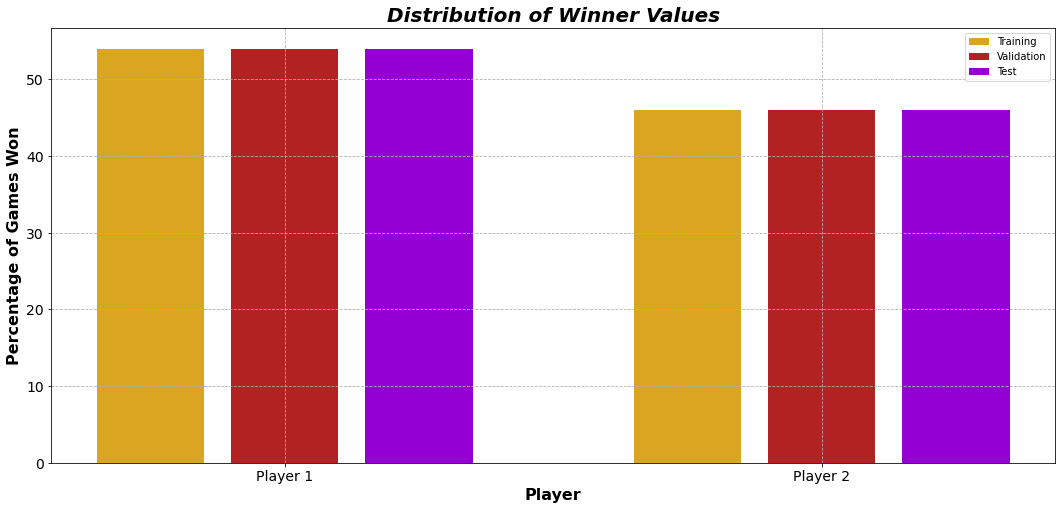

In [166]:
# plot the distribution of winner values for the three data sets
fig, ax = plt.subplots()

# set up lables for the graph
labels = ['Training', 'Validation', 'Test']

# setup list of filehash lists
list_of_filehash_lists = [
    training_filehash_list, 
    validation_filehash_list, 
    test_filehash_list
]

# for offsetting the x-axis ticks
width = 0.25

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the winner values
    # scale the values by the amount of filehashes
    winners = spawningtool_df.loc[
        mask, 
        'game_winner'
    ].value_counts()/len(filehashes)*100

    # plot the distribution of the training data
    # make the bar width proportional to the number of filehashes
    plt.bar(
        winners.index - width + (i*width),
        height=winners,
        color=list(COLOR_DICT.values())[i],
        label=labels[i],
        width=width - 0.05
    )

ax.set_xticks(winners.index, ['Player 1', 'Player 2'])
plt.legend()
plt.title('Distribution of Winner Values', style='italic')
plt.xlabel('Player')
plt.ylabel('Percentage of Games Won')
plt.show()

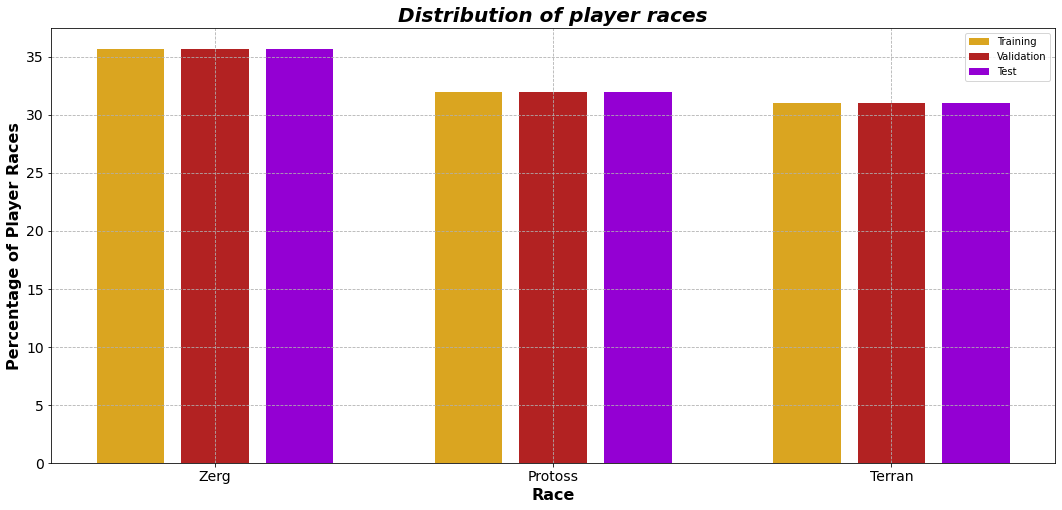

In [168]:
# plot the distribution of races for each dataset
fig, ax = plt.subplots()

x = np.arange(3)

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the count of player1 races
    race_counts = spawningtool_df.loc[
        mask, 'player1_race'
    ].value_counts()
    # add the count of player2 races
    race_counts += spawningtool_df.loc[mask, 'player2_race'].value_counts()

    # divide by the number of players
    race_counts /= len(filehashes)*2

    # plot as a bar
    plt.bar(
        x - width + i*width,
        height=race_counts.values*100,
        width=width - 0.05,
        color=list(COLOR_DICT.values())[i],
        label=labels[i]
    )

ax.set_xticks(x, race_counts.index.values)
plt.legend()
plt.title('Distribution of player races', style='italic')
plt.xlabel('Race')
plt.ylabel('Percentage of Player Races')
plt.show()
    


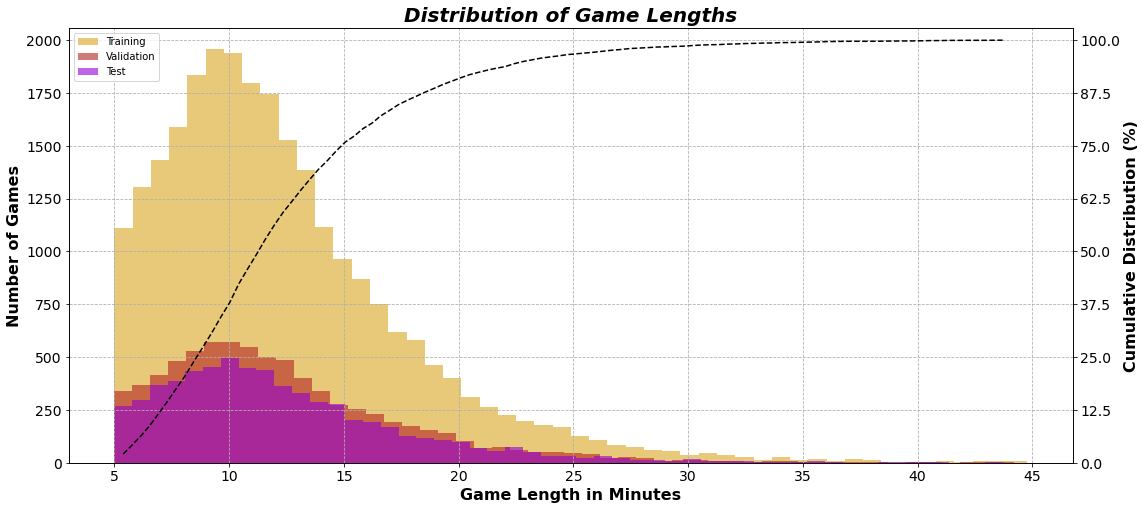

In [171]:
# plot game length 
fig, ax = plt.subplots(1,1)

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the game length values
    game_lengths = spawningtool_df.loc[
        mask, 'game_length'
    ]/60

    # plot the distribution of game lengths
    ax.hist(
        game_lengths,
        bins=50,
        color=list(COLOR_DICT.values())[i],
        label=labels[i],
        alpha=0.6,
        density=False
    )

ax.set_xlabel('Game Length in Minutes')
ax.set_ylabel('Number of Games')

# plot a line of cumulative distribution
# get twinx
ax2 = ax.twinx()

# get the cumulative distribution
count, bins_count = np.histogram(game_lengths, bins=100)

# calculate the probability distribution function
pdf = count / sum(count)

# calculate the cumulative distribution function
cdf = np.cumsum(pdf)*100

ax2.plot(
    bins_count[1:],
    cdf,
    color='black',
    linestyle='--',
    label='Cumulative Distribution'
)

ax2.set_ylabel('Cumulative Distribution (%)')
ax2.grid(False)

# get max value of ax.y
y_max = ax.get_ylim()[1]
# calculate ax2 ylim
y_max_2 = y_max/2000 * 100
y_min_2 = 0
ax2.set_ylim(y_min_2, y_max_2)

# scale ax2 ticks to ax.y
ax2.set_yticks(np.linspace(0, 100, 9))

ax.legend(loc=2)
plt.title('Distribution of Game Lengths', style='italic')
plt.show()


Game length, player races and game winner appear to be evenly distributed across all three datasets.
* **Game length**: As previously discussed, the bulk of games are around 10 minutes in length. 75% of games are under 15 minutes in length, with a long tail extending to 45 minutes.
* **Player Race**: Zerg are most represented, followed by Protoss and then Terran.
* **Game Winner**: Game wins are fairly evenly distributed between Player 1 and Player 2, with Player 1 having 55% of victories. This should be an even enough balance so as not to bias the model.

### Feature analysis
We would like to have more insight into the features that are going to be modeled. However, with the large amount of feature columns that are available, it would be too time consuming and impractical to simply plot the distribution of each.

Instead we will analyze features based on the following criteria:
* Least commonly present features - features which are present (i.e. non-zero) in the least games.
* Features with the highest variance from game to game - sum the features for each game and then calculate the variance of the sums.
* Features which correlate most strongly to game outcome - using the Pearson correlation coefficient.

These analyses will be performed on the training data, as it is the largest dataset. It would potentially be time consuming and resource heavy to combine the data for all three datasets.

#### Ensuring all dataframes match
First we need to make sure the columns of all dataframes match. To do this we will pass each dataframe through a function that compares the columns to the `master_columns_list`. The function is defined so that later it may be used in generating data for the model.

In [8]:
# function to match columns names to the master list
def match_columns_with_master(df, master_columns_list):
    """
    Matches the columns of a dataframe to the master list of columns.
    Newly added columns are assigned a value of 0 for all rows.

    Args:
        df (df): the dataframe
        master_columns_list (list, str): the master list of columns

    Returns:
        df (df): the dataframe with the columns matched
    """

    # convert the master list to a df
    master_df = pd.DataFrame(columns=master_columns_list)

    # use pd.align to align the master df and the df
    # right join to only use the master columns list
    df, _ = df.align(master_df, join='right', axis=1, fill_value=0)

    # return the dataframe with columns arranged in the master list order
    return df[master_columns_list]

In [12]:
# match the columns of the training data and reduce the size
train_df, _ = reduce_mem_usage(
    match_columns_with_master(
        train_df, 
        master_columns_list
    )
)
# match the columns of the validation data
val_df, _ = reduce_mem_usage(
    match_columns_with_master(
        val_df,
        master_columns_list
    )
)
# match the columns of the test data
test_df, _ = reduce_mem_usage(
    match_columns_with_master(
        test_df,
        master_columns_list
    )
)


	Memory usage of dataframe is : 3296.91  MB


  0%|          | 0/581 [00:00<?, ?it/s]

	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  3118.99  MB
	This is  94.6 % of the initial size
	Memory usage of dataframe is : 1359.07  MB


  0%|          | 0/581 [00:00<?, ?it/s]

	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  931.84  MB
	This is  68.56 % of the initial size
	Memory usage of dataframe is : 1295.18  MB


  0%|          | 0/581 [00:00<?, ?it/s]

	___MEMORY USAGE AFTER COMPLETION:___
	Memory usage is:  778.75  MB
	This is  60.13 % of the initial size


In [13]:
print(f'The shape of train_df is {train_df.shape}')
print(f'The shape of val_df is {val_df.shape}')
print(f'The shape of test_df is {test_df.shape}')


The shape of train_df is (3807335, 581)
The shape of val_df is (1142815, 581)
The shape of test_df is (955057, 581)



#### Correlation to game outcome
Since we are interested in predicting the game outcome, we will first investigate the linear correlation between each feature and the game outcome. Only the top 20 features with negative and positive correlation will be reported.

We are using the __[Pearson R correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__ coefficient to calculate the correlation between each feature and the game outcome. Pearson's R is a measure of linear correlation between two variables, and is calculated by the following formula:
$$ \rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} $$

where $\rho$ is the Pearson correlation coefficient, $cov(X,Y)$ is the covariance between $X$ and $Y$, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$.

Covariance is calculated by calculating the difference between each value of $X$ and $Y$ and their respective means, multiplying the two, and dividing by the number of observations:
$$ cov(X,Y) = \frac{1}{n}\sum_{i=1}^{n}(X_i - \mu_X)(Y_i - \mu_Y) $$

where $n$ is the number of observations, $X_i$ is the $i$th value of $X$, $Y_i$ is the $i$th value of $Y$, $\mu_X$ is the mean of $X$, and $\mu_Y$ is the mean of $Y$.

In [14]:
# construct pearson correlation matrix for each column of the dataframe to the winner column
def get_correlation_matrix(df, column_name):
    """
    Constructs a correlation matrix for a column of a dataframe.

    Args:
        df (df): the dataframe
        column_name (str): the name of the column

    Returns:
        df (df): the correlation matrix
    """

    # get the correlation matrix
    correlation_matrix = df.corr()[column_name].sort_values(ascending=False)

    # return the correlation matrix
    return correlation_matrix

In [30]:
# get correlation matrix for the training data
# use corrwith because we are only interested in correlating the winner column 
# with the other columns
train_corr = pd.DataFrame(
    train_df.corrwith(train_df['winner']),
    columns=['coefficient'])
train_corr.head()

,coefficient
frame,0.000349
p1_upgrade_type_name_SprayTerran,0.004215
p1_upgrade_type_name_TerranInfantryWeaponsLevel1,0.000111
p1_name_PlayerStatsEvent,-0.007506
p1_name_UnitBornEvent,0.022518


In [92]:
def plot_top_n_values(
    df, 
    column_label,
    show_negative=True,
    n_values=20
):
    """
    plot_top_correlations
    --------------------------------------------------
    Plots the top and bottom n_values from the correlation matrix.

    Args:
        df (pandas.DataFrame): the correlation matrix
        column_label (str): the label of the column used to title the plot
        show_negative (bool): whether to show negative values as negative or positive
        n_values (int): the number of top correlations to plot
    """

    # get the column name
    column_name = df.columns[0]

    # get the largest n_values that are positive
    pos_df = df.nlargest(n_values, column_name).sort_values(
        by=column_name,
        ascending=False
    )
    # get the largest n_values that are negative
    neg_df = df.nsmallest(n_values, column_name).sort_values(
        by=column_name,
        ascending=False
    )

    # plotting is adapted from Boris Shabash in Brainstation Education material
    # https://www.brainstation.io/

    # setup the plot
    fig, ax = plt.subplots(2, 1, figsize=(18, 18))

    # plot the negative correlations
    neg_df.plot(
        kind='bar',
        rot=45,
        ax=ax[0],
        color=list(COLOR_DICT.values())[0])
    ax[0].set_title('Top Negative', style='italic')
    ax[0].legend().set_visible(False)
    ax[0].set_ylabel(f'{column_name} value')
    # right align the x-axis tick labels
    labels = [l.get_text() for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels, ha='right', fontsize=14)
    if not show_negative:
        # convert y-tick labels to positive
        ax[0].set_yticklabels(
            [f'{abs(float(l))}' for l in ax[0].get_yticklabels()]
        )
        

    # plot the positive correlations
    pos_df.head(n_values).plot(
        kind='bar',
        rot=45,
        ax=ax[1],
        color=list(COLOR_DICT.values())[1])
    ax[1].set_title('Top Positive', style='italic')
    ax[1].legend().set_visible(False)
    ax[1].set_ylabel(f'{column_name} value')
    # right align the x-axis tick labels
    labels = [l.get_text() for l in ax[1].get_xticklabels()]
    ax[1].set_xticklabels(labels, ha='right', fontsize=14)

    sns.despine()
    plt.suptitle(f'Top {n_values} {column_label}', style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

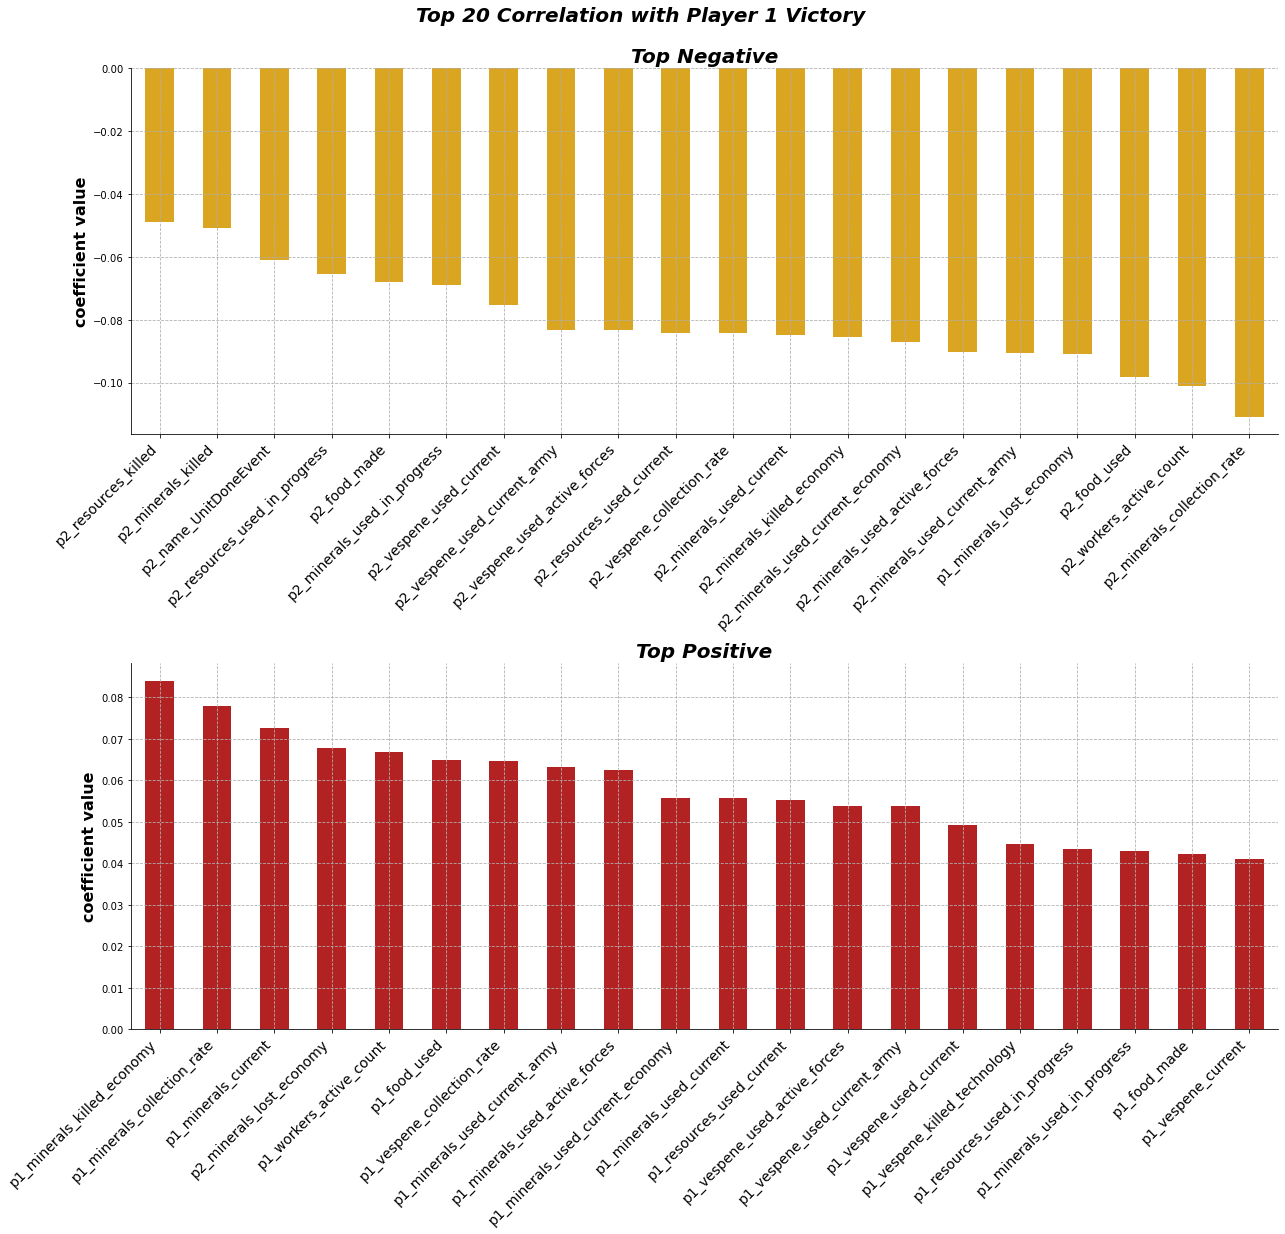

In [93]:
# drop winner row because it will always correlate to itself
# train_corr = train_corr.drop('winner')

# plot the top negative and positive correlations
plot_top_n_values(train_corr, 'Correlation with Player 1 Victory')

The results of the above correlation are interesting and promising. 

The highest 5 correlations with game outcome are fitting because:
1. `p1_minerals_killed_economy` - It is always advantageous to destroy the economy of the enemy.
2. `p1_minerals_collection_rate` - Collecting minerals is one of the chief focuses of the game. Player 1 would then have more economy available to build structures, units and upgrades.
3. `p1_minerals_current` - Having more minerals implies allows for more spending, and more production. This one is interesting because it is a common mantra in the StarCraft community that one should "spend their money". It is considered bad play to have too large a bank of resources, as those resources are doing nothing in the bank, whereas they could be used to build structures, units and upgrades.
4. `p2_minerals_lost_economy` - Similar to reasoning to (1).
5. `p1_workers_active_count` - Having more workers means more economy, and would give Player 1 an advantage.

The highest 5 negative correlations with game outcome are:
1. `p2_minerals_collection_rate` - The inverse of (2) from the positive correlations.
2. `p2_workers_active_count` - The inverse of (5) from the positive correlations.
3. `p2_food_used` - "Food" (otherwise known as supply) is a count of the number of workers and fighting units that the player has. The more Player 2 has, the more unlikely one would expect it to be that Player 1 would win.
4. `p1_minerals_lost_economy` - The inverse of (4) from the positive correlations.
5. `p2_minerals_used_current_army` - The more expensive an army, the higher one would assume the quality would be. This would then be expected to give Player 2 an advantage.

It is interesting to note that the lists are not exact mirrors of one another. This suggests that perhaps there is some variance even in the balanced dataset that we have collected. However, it would not be practical to rework the data for each feature. Future work could perhaps focus on creating new features by measuring the difference between these mirror values (i.e. `p1_food_used` minus `p2_food_used`) instead of using the raw values.

#### Least common features

Next we will examine the most and least common features. To do this we will count the number of times a column is non-zero for each game (filehash) in train_df.

In [64]:
# use groupby to collect data into individual games
summed_df = train_df.groupby('filehash').sum()
summed_df.head()

,frame,p1_upgrade_type_name_SprayTerran,p1_upgrade_type_name_TerranInfantryWeaponsLevel1,p1_name_PlayerStatsEvent,p1_name_UnitBornEvent,p1_name_UnitDiedEvent,p1_name_UnitDoneEvent,p1_name_UpgradeCompleteEvent,p1_unit_type_name_Cyclone,p1_unit_type_name_Liberator,p1_unit_type_name_Marine,p1_unit_type_name_Medivac,p1_unit_type_name_Raven,p1_unit_type_name_SCV,p1_unit_type_name_SiegeTank,p1_unit_type_name_VikingFighter,p1_resources_used_current,p1_vespene_used_current_technology,p1_vespene_used_in_progress,p1_vespene_lost_economy,p1_vespene_killed,p1_vespene_current,p1_vespene_used_in_progress_army,p1_workers_active_count,p1_minerals_current,p1_minerals_killed_army,p1_minerals_used_current_economy,p1_vespene_lost_technology,p1_vespene_used_current_economy,p1_vespene_used_current_army,p1_vespene_lost_army,p1_vespene_killed_army,p1_food_made,p1_vespene_killed_technology,p1_resources_lost,p1_vespene_used_in_progress_economy,p1_minerals_used_current_technology,p1_minerals_used_in_progress_technology,p1_vespene_used_active_forces,p1_minerals_killed_economy,p1_minerals_used_active_forces,p1_minerals_used_current_army,p1_minerals_lost_army,p1_minerals_used_in_progress_economy,p1_food_used,p1_minerals_lost_economy,p1_vespene_used_in_progress_technology,p1_minerals_used_in_progress,p1_minerals_lost,p1_resources_used_in_progress,p1_vespene_collection_rate,p1_vespene_used_current,p1_minerals_collection_rate,p1_minerals_killed_technology,p1_vespene_lost,p1_resources_killed,p1_vespene_killed_economy,p1_minerals_lost_technology,p1_minerals_used_current,p1_minerals_used_in_progress_army,p1_minerals_killed,p2_upgrade_type_name_GraviticDrive,p2_upgrade_type_name_PhoenixRangeUpgrade,p2_upgrade_type_name_ProtossAirWeaponsLevel1,p2_upgrade_type_name_ProtossAirWeaponsLevel2,p2_upgrade_type_name_SprayProtoss,p2_upgrade_type_name_WarpGateResearch,p2_name_PlayerStatsEvent,p2_name_UnitBornEvent,p2_name_UnitDiedEvent,p2_name_UnitDoneEvent,p2_name_UpgradeCompleteEvent,p2_unit_type_name_Disruptor,p2_unit_type_name_DisruptorPhased,p2_unit_type_name_Phoenix,p2_unit_type_name_Probe,p2_unit_type_name_Stalker,p2_unit_type_name_WarpPrism,p2_unit_type_name_Zealot,p2_resources_used_current,p2_vespene_used_current_technology,p2_vespene_used_in_progress,p2_vespene_lost_economy,p2_vespene_killed,p2_vespene_current,p2_vespene_used_in_progress_army,p2_workers_active_count,p2_minerals_current,p2_minerals_killed_army,p2_minerals_used_current_economy,p2_vespene_lost_technology,p2_vespene_used_current_economy,p2_vespene_used_current_army,p2_vespene_lost_army,p2_vespene_killed_army,p2_food_made,p2_vespene_killed_technology,p2_resources_lost,p2_vespene_used_in_progress_economy,p2_minerals_used_current_technology,...,p1_unit_type_name_KrakenPod,p1_unit_type_name_Leviathan,p1_unit_type_name_LocustFlying,p1_unit_type_name_Mantis,p1_unit_type_name_SwarmHostSplitB,p2_upgrade_type_name_ProtossDNA,p2_unit_type_name_CarrierRepairDrone,p2_unit_type_name_DestructibleDebris4x4_P,p2_unit_type_name_DestructibleDebris6x6,p2_unit_type_name_DestructibleDebris6x6_P,p2_unit_type_name_Firebat,p2_unit_type_name_Goliath,p2_unit_type_name_HERC,p2_unit_type_name_MarineGunner,p2_unit_type_name_MarineResoc,p2_unit_type_name_Medic,p2_unit_type_name_Nuke2,p2_unit_type_name_Predator,p2_unit_type_name_Vulture,p1_unit_type_name_CollapsibleRockTowerPushUnitRampLeft,p1_unit_type_name_CollapsibleTerranTowerPushUnitRampLeft,p1_unit_type_name_HighTemplar,p1_upgrade_type_name_SnowVisualMP,p2_upgrade_type_name_SnowVisualMP,p2_unit_type_name_DarkTemplar,p2_unit_type_name_ForceFieldBlue,p1_upgrade_type_name_RavenRecalibratedExplosives,p1_unit_type_name_RavenRepairDrone,p1_upgrade_type_name_MicrobialShroud,p1_unit_type_name_DarkTemplar,p2_upgrade_type_name_MicrobialShroud,p2_upgrade_type_name_RavenRecalibratedExplosives,p2_unit_type_name_ReleaseInterceptorsBeacon,p2_upgrade_type_name_GhostMoebiusReactor,p2_unit_type_name_RavenRepairDrone,p1_upgrade_type_name_TerranVehicleAndShipWeaponsLevel1,p2_unit_type_name_Colla

In [99]:
# create an empty dataframe to store the counts
common_features = summed_df.astype(bool).sum(axis=0).sort_values(ascending=True)
common_features.head(15)

p2_upgrade_type_name_RavenEnhancedMunitions                     0
p1_upgrade_type_name_RavagerRange                               0
p2_upgrade_type_name_ZergMissileWeaponsLevel4                   0
p2_unit_type_name_CollapsibleRockTowerPushUnitRampRightGreen    0
p2_unit_type_name_ForceFieldRed                                 0
p1_unit_type_name_ForceFieldRed                                 0
p1_unit_type_name_CollapsibleRockTowerPushUnitRampRightGreen    0
p1_unit_type_name_KrakenPod                                     1
p1_unit_type_name_InfestorTerran                                1
p1_unit_type_name_HunterKiller                                  1
p1_unit_type_name_HotSRaptor                                    1
p1_unit_type_name_HotSHunter                                    1
p1_unit_type_name_DragonPod                                     1
p1_unit_type_name_DestructibleDebris6x6_P                       1
p1_unit_type_name_BehemothPod                                   1
dtype: int

A number of features have no representation in the training data. It might be worthwhile to remove features below a certain threshold. There are 25,547 games in total, so we will choose a threshold of 1% of the total games, which is around 250 games. 

In [153]:
# show features with values less than equal to 600
thresh = 250
number_removed = len(common_features[common_features <= thresh])
print(f'A threshold of {thresh} would remove {number_removed} features')

A threshold of 250 would remove 186 features


These features will not be removed currently, but during modeling the functionality may be added to allow for testing the effect of removing these features on accuracy and performance.